In [17]:
%cd /home/matthandzel/Code/Python/PlayingForager
from PIL.Image import PERSPECTIVE
#from tensorflow.python.framework.ops import add_to_collections
from mapInput import *
from environment import *
from agent import *
from utils import *
from dataManager import Manager
import time, keras, os

class Gym:
  env = Environment()
  manager = Manager()
  
  action_space_size = [5, 2]

  data = []
  
  nEpisodes = 0
  nSteps = 0

  framerate = 5
  actionsArray = []
  
  trainTimes = 10

  explorationRate = 0.95



  def __init__(self, load = True):
    self.agent = Agent(self)

    self.input = Input()
    # input dims = [[68, 135], 3]
    # output dims = 6
    input_vision_dimensions = [50, 50, 1]
    self.agent.define_model(input_vision_dimensions, self.action_space_size)
    stats = self.manager.loadMetadata()
    self.nEpisodes = stats["nEpisodes"]
    self.nSteps = stats["nSteps"]
    if load:
      temp = self.trainTimes
      self.trainTimes = 1
      self.trainOnPrevData(1)
      self.trainTimes = temp
      self.manager.loadPreviousSession(self.agent, self.nEpisodes)
    self.input.run()
    
  
  def initallyTrain(self):
    self.agent.updateTargetModel()
    self.trainOnPrevData(500000)
    input("...")
  
  def trainOnPrevData(self,nSteps):
    totalSteps = 0
    while totalSteps < nSteps:
      print(f"\n{totalSteps}/{nSteps}")
      self.agent.experienceReplay = self.manager.loadRandomSample()
      self.train()
      print(len(self.agent.experienceReplay))
      totalSteps += len(self.agent.experienceReplay) * self.trainTimes
    self.agent.experienceReplay = ReplayExperience(maxlen = 5000)

  def runHeuristic(self):
    while not self.input.terminated:
      self.heuristicEpisode()

  def run(self):
    if(self.trainer == None):
      raise Exception("YOU NEED TO SET THE TRAINER (gym.setTrainer(trainer))")
    while not self.input.terminated:
      print("Starting the episode..")
      self.episode()
      self.betweenEpisodes()
      print("SAVING MODELS...")
      self.manager.saveSession(self.agent, self.nEpisodes)
  
  def betweenEpisodes(self):
    pass

  def updateMetadata(self):
    self.manager.updateMetadata(self.getStats())
  
  def getStats(self):
    return {"nEpisodes" : self.nEpisodes,
            "nSteps" : self.nSteps}

  def episode(self):
    # check if training
    #   - if training:
    #       train
    # check if updating target model
    # update to history
    
    alive = True
    
    start_steps = self.nSteps

    game_data = self.env.getDataFromGame()
    current_state = game_data[0]
    self.nEpisodes += 1

    while alive and not self.input.terminated:
      self.nSteps += 1

      if random.random() > self.explorationRate:
        predictions = self.agent.predictRewardsForActions(current_state)
        actions = [np.argmax(predictions[0]), np.argmax(predictions[1])]
      else:
        actions = [random.randint(0,self.action_space_size[0]-1),random.randint(0,self.action_space_size[1]-1)] 
      
      if self.input.movementInputs[actions[0]] != None:
        self.input.keyboard.press(self.input.movementInputs[actions[0]])
      if self.input.actionInputs[actions[1]] != None:
        self.input.keyboard.press(self.input.actionInputs[actions[1]])

      next_game_data = self.env.getDataFromGame()
      next_state = next_game_data[0]

      time.sleep(1/self.framerate)

      if self.input.movementInputs[actions[0]] != None:
        self.input.keyboard.release(self.input.movementInputs[actions[0]])
      if self.input.actionInputs[actions[1]] != None:
        self.input.keyboard.release(self.input.actionInputs[actions[1]])
      
      # set data to experience replay
      self.agent.experienceReplay.append([current_state, actions, self.env.computeReward(game_data[1:], next_game_data[1:]), next_state[1] == 0,  next_state])
      print(game_data[1:])
      game_data = next_game_data
      current_state = next_state
      if self.explorationRate > 0.5:
        self.explorationRate *= 0.999998
      
      if game_data[1] == 0:
        alive = False
        if self.nSteps - start_steps >= 10: # This is so that if the episode is really short we dont save it
          self.manager.addEpisode(np.array(self.agent.experienceReplay, dtype=object))
    self.printMetadataOfEpisode(self.agent.experienceReplay)
    self.agent.experienceReplay.clear()
    self.updateMetadata()
    self.resetEnv()
    print("KILLING")

  def showAiPredictions(self):
    current_state = self.env.getDataFromGame()
    predictions = self.agent.predictRewardsForActions(current_state)
    print("MOVEMENT:")
    for i in range(len(predictions[0][0])):
      print(f"\t{self.input.movementInputs[i]}:\t{round(predictions[0][0][i] * 1000) / 1000}")
    print("ACTION:")
    for i in range(len(predictions[1][0])):
      print(f"\t{self.input.actionInputs[i]}:\t{round(predictions[1][0][i] * 1000) / 1000}")
    print("\n")

  def heuristicEpisode(self):
    # check if training
    #   - if training:
    #       train
    # check if updating target model
    # update to history
    
    alive = True
    
    current_state = self.env.getDataFromGame()
    self.nEpisodes += 1

    while alive and not self.input.terminated:
      self.nSteps += 1

      if random.random() > self.explorationRate:
        predictions = self.agent.predictRewardsForActions(current_state)
        actions = [np.argmax(predictions[0]), np.argmax(predictions[1])]
      else:
        actions = [random.randint(0,self.action_space_size[0]-1),random.randint(0,self.action_space_size[1]-1)] 
      
      if self.input.movementInputs[actions[0]] != None:
        self.input.keyboard.press(self.input.movementInputs[actions[0]])
      if self.input.actionInputs[actions[1]] != None:
        self.input.keyboard.press(self.input.actionInputs[actions[1]])

      next_game_data = self.env.getDataFromGame()
      next_state = next_game_data[0]

      time.sleep(1/self.framerate) 

      if self.input.movementInputs[actions[0]] != None:
        self.input.keyboard.release(self.input.movementInputs[actions[0]])
      if self.input.actionInputs[actions[1]] != None:
        self.input.keyboard.release(self.input.actionInputs[actions[1]])
      
      # set data to experience replay
      self.agent.experienceReplay.append([current_state, actions, self.env.computeReward(game_data[1:], next_game_data[1:]), next_state[1] == 0,  next_state])
      
      current_state = next_state
      game_data = next_game_data
      if game_data[1] == 0: 
        alive = False
        if(self.nSteps > 5):
          self.manager.addEpisode(np.array(self.agent.experienceReplay, dtype=object))
        self.printMetadataOfEpisode(self.agent.experienceReplay)
        self.agent.experienceReplay.clear()
        self.updateMetadata()
        self.resetEnv()
        print("KILLING")

  def resetEnv(self):
    print("RESETING ENV")
    restarting = True
    delay = 0.35
    self.input.click(delay)
    self.input.mouse.release(mouse.Button.right)
    self.input.mouse.release(mouse.Button.left)
    while restarting:
      while not self.env.checkIfMainScreen():
        print("\nWe not on main screen\n!")
        self.trainer.train(1, 1)
        self.input.keyboard.press('e')
      # self.trainOnPrevData(50000)
      # press play button
      y_offset = 30
      time.sleep(delay * 3)
      self.input.mouse.position = (1116, 425 + y_offset)
      time.sleep(delay)
      self.input.click(delay)
      time.sleep(delay)
      # Press delete button
      self.input.mouse.position = (1819, 399 + y_offset)
      time.sleep(delay)
      self.input.click(delay)
      time.sleep(delay)
      # NO POSITIOn
      #self.input.mouse.position = (1545, 551 + y_offset)
      # YES POSITIOn
      self.input.mouse.position = (1367, 546 + y_offset)
      time.sleep(delay)
      self.input.click(delay)
      time.sleep(delay * 2)
      self.input.mouse.position = (1441, 518 + y_offset)
      time.sleep(delay)
      self.input.click(delay)
      # Classic mode
      self.input.mouse.position = (1154, 542 + y_offset)
      # Single island challenge
      # self.input.mouse.position = (1534, 539 + y_offset)
      time.sleep(delay)
      self.input.click(delay)
      time.sleep(delay)
      self.input.mouse.position = (1453, 699 + y_offset)
      time.sleep(delay)
      self.input.click(delay)
      time.sleep(delay)
      time.sleep(2.5)
      self.input.mouse.press(mouse.Button.right)
      time.sleep(delay)
      self.input.mouse.release(mouse.Button.right)
      time.sleep(delay)
      self.input.mouse.position = (1256, 350 + y_offset)
      time.sleep(delay)
      self.input.click(delay)
      restarting = False
    print("ENV READY")
  
  def setTrainer(self, trainer):
    self.trainer = trainer

  def endSession(self):
    self.manager.addData(self.data)
  
  def printMetadataOfEpisode(self, episodeData):
    episodeData = np.array(episodeData, dtype=object)
    episodeLength = len(episodeData[:,2])
    print(f"META DATA FOR EPISODE: {self.nEpisodes}")
    print(f"\tMISC:")
    print(f"\t\tNSTEPS: {episodeLength} ({episodeLength * (1/self.framerate)}) seconds")
    print("\tREWARDS:")
    print(f"\t\tTOTAL: {np.sum(episodeData[:,2])}")
    print(f"\t\tAVERAGE: {np.sum(episodeData[:,2])/episodeLength}")
    print(f"\t\tSTD:\t{np.std(episodeData[:,2])}")
    print(f"\t\tMIN: {np.min(episodeData[:,2])}\t\tMAX: {np.max(episodeData[:,2])}")
  
  def train(self):
    print("CURRENTLY TRAINING MODEL...")
    for i in range(self.trainTimes):
      print(f"LOSS {i+1} / {self.trainTimes}: {np.sum(self.agent.train(epochs=1))}")
    print("UPDATING TARGET MODEL")
    self.agent.updateTargetModel()

if __name__ == "__main__":
  gym = Gym(False)

  from trainAi import Trainer
  trainer = Trainer(gym)
  gym.setTrainer(trainer)

  all_data = gym.manager.loadAllData()
  all_data = np.concatenate(all_data)
  all_data = all_data[all_data[:,2] < 3]

  trainer.trainOnData(all_data,2, 2, use_target=False)
  # try:
  gym.run()
  # except KeyboardInterrupt or Exception or OSError or ValueError as e:
  #   print(e)
  #   gym.input.stopListener()

/home/matthandzel/Code/Python/PlayingForager


/tmp/ipykernel_357700/3162558882.py:2: DeprecationWarning: PERSPECTIVE is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transform.PERSPECTIVE instead.
  from PIL.Image import PERSPECTIVE


TRAINING MODEL...
	TIME: 0.0	LOSS 1 / 2: 36.61470136664747
	TIME: 76.8	LOSS 2 / 2: 0.14988056749406756
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0236/assets


INFO:tensorflow:Assets written to: ./models/model_0236/assets


Starting the episode..
[0, 40, 0]
META DATA FOR EPISODE: 237
	MISC:
		NSTEPS: 1 (0.2) seconds
	REWARDS:
		TOTAL: -0.01
		AVERAGE: -0.01
		STD:	0.0
		MIN: -0.01		MAX: -0.01
RESETING ENV
ENV READY
KILLING
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0237/assets


INFO:tensorflow:Assets written to: ./models/model_0237/assets


Starting the episode..
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 38, 2]
[3, 37, 3]
[3, 37, 4]
[3, 37, 4]
[3, 37, 4]
[3, 37, 4]
[3, 37, 4]
[3, 37, 4]
[3, 37, 4]
[3, 37, 4]
[3, 37, 4]
[3, 37, 4]
[3, 37, 4]
[3, 36, 4]
[3, 36, 4]
[3, 36, 4]
[3, 36, 4]
[3, 36, 4]
[3, 36, 4]
[3, 36, 4]
[3, 36, 4]
[3, 36, 4]
[3, 36, 4]
[3, 36, 4]
[3, 36, 4]
[3, 36, 4]
[3, 36, 4]
[3, 36, 4]
[3, 36, 4]
[3, 36, 4]
[3, 36, 4]
[3, 35, 4]
[3, 35, 4]
[3, 35, 4]
[3, 35, 4]
[3, 35, 4]
[3, 35, 4]
[3, 35, 4]
[3, 35, 4]
[3, 35, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 6]
[3, 34, 8]
[3, 34, 11]
[3, 34, 13]
[3, 33, 15]
[3, 33, 15]
[3, 33, 16]
[3, 34, 16]
[3, 34, 16]
[3, 34, 16]
[3, 33, 16]
[3, 33, 16]
[3, 33, 16]
[3, 33, 16]
[3, 33, 16]
[3, 33, 16]
[3, 33, 16]
[3, 33, 16]
[3, 33, 16]
[3, 33, 16]
[3, 33, 16]
[3, 33, 16]
[3, 33, 16]
[3, 33, 16]
[3, 33, 16]
[3, 33, 16]
[3, 33, 19]
[3, 33, 20]
[3, 33, 22]
[3, 32, 22]
[3, 32, 22]
[3, 32, 22]
[3, 32, 22]
[3, 32, 22]
[3, 32, 22]
[3, 32, 22]
[3, 32, 

INFO:tensorflow:Assets written to: ./models/model_0239/assets


INFO:tensorflow:Assets written to: ./models/model_0239/assets



We not on main screen
!
TRAINING MODEL...
	TIME: 0.0	LOSS 1 / 1: 0.12332209233652082
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0240/assets


INFO:tensorflow:Assets written to: ./models/model_0240/assets



We not on main screen
!
TRAINING MODEL...
	TIME: 0.0	LOSS 1 / 1: 0.12978974471849575
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0241/assets


INFO:tensorflow:Assets written to: ./models/model_0241/assets



We not on main screen
!
TRAINING MODEL...
	TIME: 0.0	LOSS 1 / 1: 0.11262814766103095
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0242/assets


INFO:tensorflow:Assets written to: ./models/model_0242/assets


ENV READY
KILLING
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0242/assets


INFO:tensorflow:Assets written to: ./models/model_0242/assets


INFO:tensorflow:Assets written to: ./models/model_0243/assets


INFO:tensorflow:Assets written to: ./models/model_0243/assets


Starting the episode..
[0, 40, 0]
META DATA FOR EPISODE: 243
	MISC:
		NSTEPS: 1 (0.2) seconds
	REWARDS:
		TOTAL: -0.01
		AVERAGE: -0.01
		STD:	0.0
		MIN: -0.01		MAX: -0.01
RESETING ENV
ENV READY
KILLING
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0243/assets


INFO:tensorflow:Assets written to: ./models/model_0243/assets


INFO:tensorflow:Assets written to: ./models/model_0244/assets


INFO:tensorflow:Assets written to: ./models/model_0244/assets


Starting the episode..
[3, 38, 0]
[3, 38, 0]
[3, 38, 1]
[3, 38, 3]
[3, 38, 3]
[3, 38, 4]
[3, 37, 4]
[3, 37, 4]
[3, 37, 4]
[3, 37, 4]
[3, 37, 4]
[3, 37, 4]
[3, 36, 4]
[3, 36, 4]
[3, 36, 4]
[3, 36, 4]
[3, 36, 4]
[3, 36, 4]
[3, 36, 4]
[3, 36, 4]
[3, 36, 4]
[3, 36, 4]
[3, 36, 4]
[3, 36, 4]
[3, 36, 4]
[3, 36, 4]
[3, 36, 4]
[3, 35, 4]
[3, 35, 4]
[3, 35, 4]
[3, 35, 4]
[3, 35, 4]
[3, 35, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 5]
[3, 34, 5]
[3, 34, 5]
[3, 34, 5]
[3, 34, 5]
[3, 34, 5]
[3, 34, 5]
[3, 34, 5]
[3, 34, 5]
[3, 34, 5]
[3, 34, 5]
[3, 34, 5]
[3, 33, 5]
[3, 33, 5]
[3, 33, 5]
[3, 33, 5]
[3, 33, 5]
[3, 33, 5]
[3, 33, 5]
[3, 33, 5]
[3, 33, 5]
[3, 33, 5]
[3, 32, 5]
[3, 32, 5]
[3, 32, 5]
[3, 32, 5]
[3, 32, 5]
[3, 32, 5]
[3, 32, 5]
[3, 32, 5]
[3, 32, 5]
[3, 32, 5]
[3, 32, 5]
[3, 32, 5]
[3, 32, 5]
[3, 32, 5]
[3, 32, 5]
[3, 32, 5]
[3, 32, 5]
[3, 32, 5]
[3, 32, 5]
[3, 32, 5]
[3, 32, 4]
[3, 32, 4]
[3, 32, 4]
[3, 32, 4]
[3, 32, 4]
[3, 32, 4]
[3, 32, 4]
[3, 31, 4]
[3, 31, 4]
[3, 31, 4

INFO:tensorflow:Assets written to: ./models/model_0245/assets


INFO:tensorflow:Assets written to: ./models/model_0245/assets



We not on main screen
!
TRAINING MODEL...
	TIME: 0.0	LOSS 1 / 1: 0.09332457382528427
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0246/assets


INFO:tensorflow:Assets written to: ./models/model_0246/assets



We not on main screen
!
TRAINING MODEL...
	TIME: 0.0	LOSS 1 / 1: 0.09277958689111003
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0247/assets


INFO:tensorflow:Assets written to: ./models/model_0247/assets


ENV READY
KILLING
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0247/assets


INFO:tensorflow:Assets written to: ./models/model_0247/assets


INFO:tensorflow:Assets written to: ./models/model_0248/assets


INFO:tensorflow:Assets written to: ./models/model_0248/assets


Starting the episode..
[0, 40, 0]
META DATA FOR EPISODE: 248
	MISC:
		NSTEPS: 1 (0.2) seconds
	REWARDS:
		TOTAL: -0.01
		AVERAGE: -0.01
		STD:	0.0
		MIN: -0.01		MAX: -0.01
RESETING ENV
ENV READY
KILLING
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0248/assets


INFO:tensorflow:Assets written to: ./models/model_0248/assets


INFO:tensorflow:Assets written to: ./models/model_0249/assets


INFO:tensorflow:Assets written to: ./models/model_0249/assets


Starting the episode..
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 33, 0]
[3, 33, 0

INFO:tensorflow:Assets written to: ./models/model_0250/assets


INFO:tensorflow:Assets written to: ./models/model_0250/assets



We not on main screen
!
TRAINING MODEL...
	TIME: 0.0	LOSS 1 / 1: 0.07060652701156017
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0251/assets


INFO:tensorflow:Assets written to: ./models/model_0251/assets



We not on main screen
!
TRAINING MODEL...
	TIME: 0.0	LOSS 1 / 1: 0.111211982999472
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0252/assets


INFO:tensorflow:Assets written to: ./models/model_0252/assets



We not on main screen
!
TRAINING MODEL...
	TIME: 0.0	LOSS 1 / 1: 0.12128003083379492
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0253/assets


INFO:tensorflow:Assets written to: ./models/model_0253/assets


ENV READY
KILLING
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0253/assets


INFO:tensorflow:Assets written to: ./models/model_0253/assets


INFO:tensorflow:Assets written to: ./models/model_0254/assets


INFO:tensorflow:Assets written to: ./models/model_0254/assets


Starting the episode..
[0, 40, 0]
META DATA FOR EPISODE: 254
	MISC:
		NSTEPS: 1 (0.2) seconds
	REWARDS:
		TOTAL: -0.01
		AVERAGE: -0.01
		STD:	0.0
		MIN: -0.01		MAX: -0.01
RESETING ENV
ENV READY
KILLING
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0254/assets


INFO:tensorflow:Assets written to: ./models/model_0254/assets


INFO:tensorflow:Assets written to: ./models/model_0255/assets


INFO:tensorflow:Assets written to: ./models/model_0255/assets


Starting the episode..
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 33, 0]
[3, 33, 0]
[3, 33, 0]
[3, 33, 0]
[3, 33, 0]
[3, 33, 0]
[3, 33, 0]
[3, 33, 0]
[3, 32, 0]
[3, 32, 0]
[3, 32, 0]
[3, 32, 0]
[3, 32, 0]
[3, 32, 0]
[3, 32, 0]
[3, 32, 0]
[3, 32, 0

INFO:tensorflow:Assets written to: ./models/model_0256/assets


INFO:tensorflow:Assets written to: ./models/model_0256/assets



We not on main screen
!
TRAINING MODEL...
	TIME: 0.0	LOSS 1 / 1: 0.11273547233297275
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0257/assets


INFO:tensorflow:Assets written to: ./models/model_0257/assets



We not on main screen
!
TRAINING MODEL...
	TIME: 0.0	LOSS 1 / 1: 0.12223851450826718
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0258/assets


INFO:tensorflow:Assets written to: ./models/model_0258/assets



We not on main screen
!
TRAINING MODEL...
	TIME: 0.0	LOSS 1 / 1: 0.11638900863221917
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0259/assets


INFO:tensorflow:Assets written to: ./models/model_0259/assets


ENV READY
KILLING
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0259/assets


INFO:tensorflow:Assets written to: ./models/model_0259/assets


INFO:tensorflow:Assets written to: ./models/model_0260/assets


INFO:tensorflow:Assets written to: ./models/model_0260/assets


Starting the episode..
[0, 40, 0]
META DATA FOR EPISODE: 260
	MISC:
		NSTEPS: 1 (0.2) seconds
	REWARDS:
		TOTAL: -0.01
		AVERAGE: -0.01
		STD:	0.0
		MIN: -0.01		MAX: -0.01
RESETING ENV
ENV READY
KILLING
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0260/assets


INFO:tensorflow:Assets written to: ./models/model_0260/assets


INFO:tensorflow:Assets written to: ./models/model_0261/assets


INFO:tensorflow:Assets written to: ./models/model_0261/assets


Starting the episode..
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 35, 1]
[3, 35, 3]
[3, 35, 3]
[3, 35, 4]
[3, 35, 4]
[3, 35, 4]
[3, 35, 4]
[3, 35, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 33, 4]
[3, 33, 4]
[3, 33, 4]
[3, 33, 4]
[3, 33, 4]
[3, 33, 4]
[3, 33, 4]
[3, 33, 4]
[3, 33, 4]
[3, 33, 4]
[3, 32, 4]
[3, 32, 4]
[3, 32, 4]
[3, 32, 4]
[3, 32, 4]
[3, 32, 4]
[3, 32, 4]
[3, 32, 4]
[3, 31, 4]
[3, 31, 4]
[3, 31, 4]
[3, 31, 4]
[3, 31, 4]
[3, 31, 4]
[3, 31, 4]
[3, 31, 4]
[3, 31, 4]
[3, 31, 4]
[3, 31, 4

INFO:tensorflow:Assets written to: ./models/model_0262/assets


INFO:tensorflow:Assets written to: ./models/model_0262/assets



We not on main screen
!
TRAINING MODEL...
	TIME: 0.0	LOSS 1 / 1: 0.13153054186841473
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0263/assets


INFO:tensorflow:Assets written to: ./models/model_0263/assets



We not on main screen
!
TRAINING MODEL...
	TIME: 0.0	LOSS 1 / 1: 0.10628871648542343
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0264/assets


INFO:tensorflow:Assets written to: ./models/model_0264/assets


ENV READY
KILLING
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0264/assets


INFO:tensorflow:Assets written to: ./models/model_0264/assets


INFO:tensorflow:Assets written to: ./models/model_0265/assets


INFO:tensorflow:Assets written to: ./models/model_0265/assets


Starting the episode..
[0, 40, 0]
META DATA FOR EPISODE: 265
	MISC:
		NSTEPS: 1 (0.2) seconds
	REWARDS:
		TOTAL: -0.01
		AVERAGE: -0.01
		STD:	0.0
		MIN: -0.01		MAX: -0.01
RESETING ENV
ENV READY
KILLING
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0265/assets


INFO:tensorflow:Assets written to: ./models/model_0265/assets


INFO:tensorflow:Assets written to: ./models/model_0266/assets


INFO:tensorflow:Assets written to: ./models/model_0266/assets


Starting the episode..
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 33, 0]
[3, 33, 0]
[3, 33, 0]
[3, 33, 0]
[3, 33, 0]
[3, 33, 0]
[3, 33, 0]
[3, 33, 0]
[3, 32, 0]
[3, 32, 0]
[3, 32, 0]
[3, 32, 0]
[3, 32, 0]
[3, 32, 0]
[3, 32, 0]
[3, 32, 0]
[3, 32, 0]
[3, 32, 0]
[3, 31, 0]
[3, 31, 0]
[3, 31, 0]
[3, 31, 0]
[3, 31, 0]
[3, 31, 0]
[3, 31, 0]
[3, 31, 0]
[3, 31, 0

INFO:tensorflow:Assets written to: ./models/model_0267/assets


INFO:tensorflow:Assets written to: ./models/model_0267/assets



We not on main screen
!
TRAINING MODEL...
	TIME: 0.0	LOSS 1 / 1: 0.1339146627569825
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0268/assets


INFO:tensorflow:Assets written to: ./models/model_0268/assets



We not on main screen
!
TRAINING MODEL...
	TIME: 0.0	LOSS 1 / 1: 0.09404711699558914
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0269/assets


INFO:tensorflow:Assets written to: ./models/model_0269/assets



We not on main screen
!
TRAINING MODEL...
	TIME: 0.0	LOSS 1 / 1: 0.09319423359026884
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0270/assets


INFO:tensorflow:Assets written to: ./models/model_0270/assets


ENV READY
KILLING
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0270/assets


INFO:tensorflow:Assets written to: ./models/model_0270/assets


INFO:tensorflow:Assets written to: ./models/model_0271/assets


INFO:tensorflow:Assets written to: ./models/model_0271/assets


Starting the episode..
[0, 40, 0]
META DATA FOR EPISODE: 271
	MISC:
		NSTEPS: 1 (0.2) seconds
	REWARDS:
		TOTAL: -0.01
		AVERAGE: -0.01
		STD:	0.0
		MIN: -0.01		MAX: -0.01
RESETING ENV
ENV READY
KILLING
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0271/assets


INFO:tensorflow:Assets written to: ./models/model_0271/assets


INFO:tensorflow:Assets written to: ./models/model_0272/assets


INFO:tensorflow:Assets written to: ./models/model_0272/assets


Starting the episode..
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 35, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 33, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 33, 0]
[3, 33, 0]
[3, 33, 0]
[3, 33, 0]
[3, 33, 0]
[3, 33, 0]
[3, 33, 0]
[3, 32, 0]
[3, 32, 0]
[3, 32, 0]
[3, 32, 0]
[3, 32, 0]
[3, 32, 0]
[3, 32, 0]
[3, 32, 0]
[3, 32, 0]
[3, 32, 0]
[3, 32, 0]
[3, 32, 0]
[3, 32, 0]
[3, 31, 0]
[3, 31, 0]
[3, 31, 0]
[3, 31, 0]
[3, 31, 0]
[3, 31, 0

INFO:tensorflow:Assets written to: ./models/model_0273/assets


INFO:tensorflow:Assets written to: ./models/model_0273/assets



We not on main screen
!
TRAINING MODEL...
	TIME: 0.0	LOSS 1 / 1: 0.1041750526686671
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0274/assets


INFO:tensorflow:Assets written to: ./models/model_0274/assets



We not on main screen
!
TRAINING MODEL...
	TIME: 0.0	LOSS 1 / 1: 0.1081876505452853
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0275/assets


INFO:tensorflow:Assets written to: ./models/model_0275/assets



We not on main screen
!
TRAINING MODEL...
	TIME: 0.0	LOSS 1 / 1: 0.1610615649900365
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0276/assets


INFO:tensorflow:Assets written to: ./models/model_0276/assets


ENV READY
KILLING
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0276/assets


INFO:tensorflow:Assets written to: ./models/model_0276/assets


INFO:tensorflow:Assets written to: ./models/model_0277/assets


INFO:tensorflow:Assets written to: ./models/model_0277/assets


Starting the episode..
[0, 40, 0]
META DATA FOR EPISODE: 277
	MISC:
		NSTEPS: 1 (0.2) seconds
	REWARDS:
		TOTAL: -0.01
		AVERAGE: -0.01
		STD:	0.0
		MIN: -0.01		MAX: -0.01
RESETING ENV
ENV READY
KILLING
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0277/assets


INFO:tensorflow:Assets written to: ./models/model_0277/assets


INFO:tensorflow:Assets written to: ./models/model_0278/assets


INFO:tensorflow:Assets written to: ./models/model_0278/assets


Starting the episode..
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 33, 0]
[3, 33, 2]
[3, 33, 3]
[3, 33, 3]
[3, 33, 4]
[3, 33, 4]
[3, 33, 4]
[3, 33, 4]
[3, 33, 4]
[3, 33, 4]
[3, 32, 4]
[3, 32, 4]
[3, 32, 4]
[3, 32, 4]
[3, 32, 4]
[3, 32, 4]
[3, 32, 4]
[3, 32, 4]
[3, 32, 4]
[3, 32, 4]
[3, 32, 4]
[3, 32, 4]
[3, 32, 4]
[3, 32, 4]
[3, 32, 4]
[3, 32, 4]
[3, 32, 4]
[3, 32, 4]
[3, 31, 4]
[3, 31, 4]
[3, 31, 4]
[3, 31, 4]
[3, 31, 4]
[3, 31, 4]
[3, 31, 4]
[3, 31, 4]
[3, 31, 4

INFO:tensorflow:Assets written to: ./models/model_0279/assets


INFO:tensorflow:Assets written to: ./models/model_0279/assets



We not on main screen
!
TRAINING MODEL...
	TIME: 0.0	LOSS 1 / 1: 0.10330596706211168
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0280/assets


INFO:tensorflow:Assets written to: ./models/model_0280/assets



We not on main screen
!
TRAINING MODEL...
	TIME: 0.0	LOSS 1 / 1: 0.1318226315742919
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0281/assets


INFO:tensorflow:Assets written to: ./models/model_0281/assets



We not on main screen
!
TRAINING MODEL...
	TIME: 0.0	LOSS 1 / 1: 0.15763549127193713
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0282/assets


INFO:tensorflow:Assets written to: ./models/model_0282/assets



We not on main screen
!
TRAINING MODEL...
	TIME: 0.0	LOSS 1 / 1: 0.10275287789138243
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0283/assets


INFO:tensorflow:Assets written to: ./models/model_0283/assets


ENV READY
KILLING
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0283/assets


INFO:tensorflow:Assets written to: ./models/model_0283/assets


INFO:tensorflow:Assets written to: ./models/model_0284/assets


INFO:tensorflow:Assets written to: ./models/model_0284/assets


Starting the episode..
[0, 40, 0]
META DATA FOR EPISODE: 284
	MISC:
		NSTEPS: 1 (0.2) seconds
	REWARDS:
		TOTAL: -0.01
		AVERAGE: -0.01
		STD:	0.0
		MIN: -0.01		MAX: -0.01
RESETING ENV
ENV READY
KILLING
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0284/assets


INFO:tensorflow:Assets written to: ./models/model_0284/assets


INFO:tensorflow:Assets written to: ./models/model_0285/assets


INFO:tensorflow:Assets written to: ./models/model_0285/assets


Starting the episode..
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 3]
[3, 37, 3]
[3, 37, 4]
[3, 37, 4]
[3, 37, 4]
[3, 36, 4]
[3, 36, 4]
[3, 36, 4]
[3, 36, 4]
[3, 36, 4]
[3, 36, 4]
[3, 36, 4]
[3, 36, 4]
[3, 36, 4]
[3, 36, 4]
[3, 36, 4]
[3, 36, 4]
[3, 36, 4]
[3, 36, 4]
[3, 36, 4]
[3, 36, 4]
[3, 36, 4]
[3, 36, 4]
[3, 36, 4]
[3, 36, 4]
[3, 36, 4]
[3, 36, 4]
[3, 36, 4]
[3, 36, 4]
[3, 36, 4]
[3, 35, 4]
[3, 35, 4]
[3, 35, 4]
[3, 35, 4]
[3, 35, 4]
[3, 35, 4]
[3, 35, 4]
[3, 35, 4]
[3, 35, 4]
[3, 35, 4]
[3, 34, 4]
[3, 34, 6]
[3, 34, 8]
[3, 34, 9]
[3, 34, 10]
[3, 34, 10]
[3, 34, 10]
[3, 34, 10]
[3, 34, 10]
[3, 34, 10]
[3, 34, 10]
[3, 33, 10]
[3, 34, 10]
[3, 34, 10]
[3, 34, 10]
[3, 34, 10]
[3, 34, 10]
[3, 34, 10]
[3, 34, 10]
[3, 34, 10]
[3, 34, 10]
[3, 34, 10]
[3, 34, 10]
[3, 34, 10]
[3, 33, 10]
[3, 33, 10]
[3, 33, 10]
[3, 33, 10]
[3, 33, 10]
[3, 33, 10]
[3, 33, 10]
[3, 33, 10]
[3, 33, 10]
[3, 33, 10]
[

INFO:tensorflow:Assets written to: ./models/model_0286/assets


INFO:tensorflow:Assets written to: ./models/model_0286/assets



We not on main screen
!
TRAINING MODEL...
	TIME: 0.0	LOSS 1 / 1: 0.1458163655332624
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0287/assets


INFO:tensorflow:Assets written to: ./models/model_0287/assets



We not on main screen
!
TRAINING MODEL...
	TIME: 0.0	LOSS 1 / 1: 0.14774764766616205
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0288/assets


INFO:tensorflow:Assets written to: ./models/model_0288/assets


ENV READY
KILLING
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0288/assets


INFO:tensorflow:Assets written to: ./models/model_0288/assets


INFO:tensorflow:Assets written to: ./models/model_0289/assets


INFO:tensorflow:Assets written to: ./models/model_0289/assets


Starting the episode..
[0, 40, 0]
META DATA FOR EPISODE: 289
	MISC:
		NSTEPS: 1 (0.2) seconds
	REWARDS:
		TOTAL: -0.01
		AVERAGE: -0.01
		STD:	0.0
		MIN: -0.01		MAX: -0.01
RESETING ENV
ENV READY
KILLING
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0289/assets


INFO:tensorflow:Assets written to: ./models/model_0289/assets


INFO:tensorflow:Assets written to: ./models/model_0290/assets


INFO:tensorflow:Assets written to: ./models/model_0290/assets


Starting the episode..
[3, 38, 1]
[3, 38, 1]
[3, 38, 1]
[3, 38, 1]
[3, 38, 2]
[3, 38, 3]
[3, 37, 3]
[3, 37, 4]
[3, 37, 4]
[3, 37, 4]
[3, 37, 4]
[3, 37, 4]
[3, 36, 4]
[3, 36, 4]
[3, 36, 4]
[3, 36, 4]
[3, 36, 4]
[3, 36, 4]
[3, 36, 4]
[3, 36, 4]
[3, 36, 4]
[3, 35, 4]
[3, 35, 4]
[3, 35, 4]
[3, 35, 4]
[3, 35, 4]
[3, 35, 4]
[3, 35, 4]
[3, 35, 4]
[3, 35, 4]
[3, 35, 4]
[3, 35, 4]
[3, 35, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 6]
[3, 34, 8]
[3, 34, 9]
[3, 34, 10]
[3, 34, 10]
[3, 34, 10]
[3, 34, 10]
[3, 34, 10]
[3, 34, 10]
[3, 34, 10]
[3, 34, 10]
[3, 34, 10]
[3, 34, 10]
[3, 34, 10]
[3, 34, 10]
[3, 34, 10]
[3, 33, 10]
[3, 33, 10]
[3, 33, 12]
[3, 33, 14]
[3, 33, 15]
[3, 33, 16]
[3, 33, 16]
[3, 33, 16]
[3, 33, 16]
[3, 33, 16]
[3, 33, 16]
[3, 33, 16]
[3, 33, 16]
[3, 33, 16]
[3, 32, 16]
[3, 32, 16]
[3, 32, 16]
[3, 32, 16]
[3, 32, 16]
[3, 32, 16]
[3, 32, 16]
[3, 32, 16]
[3, 32, 16]
[3, 32, 16]
[3, 32, 16]
[3, 32, 16]
[3, 32, 16]
[3, 32, 16]
[3, 32, 16]
[3, 31, 16]
[3, 31, 16]
[3, 31, 16]
[3, 31, 16]
[3, 31,

INFO:tensorflow:Assets written to: ./models/model_0291/assets


INFO:tensorflow:Assets written to: ./models/model_0291/assets



We not on main screen
!
TRAINING MODEL...
	TIME: 0.0	LOSS 1 / 1: 0.09742001318401354
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0292/assets


INFO:tensorflow:Assets written to: ./models/model_0292/assets



We not on main screen
!
TRAINING MODEL...
	TIME: 0.0	LOSS 1 / 1: 0.12223491488167873
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0293/assets


INFO:tensorflow:Assets written to: ./models/model_0293/assets



We not on main screen
!
TRAINING MODEL...
	TIME: 0.0	LOSS 1 / 1: 0.09311777927459927
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0294/assets


INFO:tensorflow:Assets written to: ./models/model_0294/assets



We not on main screen
!
TRAINING MODEL...
	TIME: 0.0	LOSS 1 / 1: 0.1337170465279464
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0295/assets


INFO:tensorflow:Assets written to: ./models/model_0295/assets


ENV READY
KILLING
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0295/assets


INFO:tensorflow:Assets written to: ./models/model_0295/assets


INFO:tensorflow:Assets written to: ./models/model_0296/assets


INFO:tensorflow:Assets written to: ./models/model_0296/assets


Starting the episode..
[0, 40, 0]
META DATA FOR EPISODE: 296
	MISC:
		NSTEPS: 1 (0.2) seconds
	REWARDS:
		TOTAL: -0.01
		AVERAGE: -0.01
		STD:	0.0
		MIN: -0.01		MAX: -0.01
RESETING ENV
ENV READY
KILLING
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0296/assets


INFO:tensorflow:Assets written to: ./models/model_0296/assets


INFO:tensorflow:Assets written to: ./models/model_0297/assets


INFO:tensorflow:Assets written to: ./models/model_0297/assets


Starting the episode..
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 35, 1]
[3, 35, 3]
[3, 35, 3]
[3, 35, 4]
[3, 35, 4]
[3, 35, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 7]
[3, 34, 8]
[3, 34, 10]
[3, 34, 10]
[3, 34, 10]
[3, 34, 10]
[3, 34, 10]
[3, 33, 10]
[3, 33, 10]
[3, 33, 10]
[3, 33, 10]
[3, 33, 10]
[3, 33, 10]
[3, 33, 10]
[3, 33, 10]
[3, 33, 10]
[3, 33, 10]
[3, 33, 10]
[3, 33, 10]
[3, 33, 10]
[3, 33, 10]
[3, 33, 10]
[3, 33, 10]
[3, 32, 10]
[3, 32, 10]
[3, 32, 10]
[3, 32, 10]
[3, 32, 10]
[3, 32, 10]
[3, 

INFO:tensorflow:Assets written to: ./models/model_0298/assets


INFO:tensorflow:Assets written to: ./models/model_0298/assets



We not on main screen
!
TRAINING MODEL...
	TIME: 0.0	LOSS 1 / 1: 0.1924449028308919
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0299/assets


INFO:tensorflow:Assets written to: ./models/model_0299/assets



We not on main screen
!
TRAINING MODEL...
	TIME: 0.0	LOSS 1 / 1: 0.22691696456173216
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0300/assets


INFO:tensorflow:Assets written to: ./models/model_0300/assets


ENV READY
KILLING
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0300/assets


INFO:tensorflow:Assets written to: ./models/model_0300/assets


INFO:tensorflow:Assets written to: ./models/model_0301/assets


INFO:tensorflow:Assets written to: ./models/model_0301/assets


Starting the episode..
[0, 40, 0]
META DATA FOR EPISODE: 301
	MISC:
		NSTEPS: 1 (0.2) seconds
	REWARDS:
		TOTAL: -0.01
		AVERAGE: -0.01
		STD:	0.0
		MIN: -0.01		MAX: -0.01
RESETING ENV
ENV READY
KILLING
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0301/assets


INFO:tensorflow:Assets written to: ./models/model_0301/assets


INFO:tensorflow:Assets written to: ./models/model_0302/assets


INFO:tensorflow:Assets written to: ./models/model_0302/assets


Starting the episode..
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 33, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 33, 0]
[3, 33, 0]
[3, 33, 0]
[3, 33, 0]
[3, 33, 0]
[3, 33, 0]
[3, 33, 0]
[3, 33, 0]
[3, 33, 0]
[3, 33, 0]
[3, 33, 0]
[3, 33, 0]
[3, 32, 0]
[3, 32, 0]
[3, 32, 0]
[3, 32, 0]
[3, 32, 0]
[3, 32, 0]
[3, 32, 0]
[3, 32, 0]
[3, 32, 0]
[3, 32, 0]
[3, 32, 0]
[3, 32, 0

INFO:tensorflow:Assets written to: ./models/model_0303/assets


INFO:tensorflow:Assets written to: ./models/model_0303/assets



We not on main screen
!
TRAINING MODEL...
	TIME: 0.0	LOSS 1 / 1: 0.11723179514743413
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0304/assets


INFO:tensorflow:Assets written to: ./models/model_0304/assets



We not on main screen
!
TRAINING MODEL...
	TIME: 0.0	LOSS 1 / 1: 0.11860001305921362
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0305/assets


INFO:tensorflow:Assets written to: ./models/model_0305/assets



We not on main screen
!
TRAINING MODEL...
	TIME: 0.0	LOSS 1 / 1: 0.21287907819212812
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0306/assets


INFO:tensorflow:Assets written to: ./models/model_0306/assets


ENV READY
KILLING
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0306/assets


INFO:tensorflow:Assets written to: ./models/model_0306/assets


INFO:tensorflow:Assets written to: ./models/model_0307/assets


INFO:tensorflow:Assets written to: ./models/model_0307/assets


Starting the episode..
[0, 40, 0]
META DATA FOR EPISODE: 307
	MISC:
		NSTEPS: 1 (0.2) seconds
	REWARDS:
		TOTAL: -0.01
		AVERAGE: -0.01
		STD:	0.0
		MIN: -0.01		MAX: -0.01
RESETING ENV
ENV READY
KILLING
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0307/assets


INFO:tensorflow:Assets written to: ./models/model_0307/assets


INFO:tensorflow:Assets written to: ./models/model_0308/assets


INFO:tensorflow:Assets written to: ./models/model_0308/assets


Starting the episode..
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 33, 0]
[3, 33, 0

INFO:tensorflow:Assets written to: ./models/model_0309/assets


INFO:tensorflow:Assets written to: ./models/model_0309/assets



We not on main screen
!
TRAINING MODEL...
	TIME: 0.0	LOSS 1 / 1: 0.17337498804290988
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0310/assets


INFO:tensorflow:Assets written to: ./models/model_0310/assets



We not on main screen
!
TRAINING MODEL...
	TIME: 0.0	LOSS 1 / 1: 0.23294350713331088
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0311/assets


INFO:tensorflow:Assets written to: ./models/model_0311/assets



We not on main screen
!
TRAINING MODEL...
	TIME: 0.0	LOSS 1 / 1: 0.2518106250013885
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0312/assets


INFO:tensorflow:Assets written to: ./models/model_0312/assets


ENV READY
KILLING
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0312/assets


INFO:tensorflow:Assets written to: ./models/model_0312/assets


INFO:tensorflow:Assets written to: ./models/model_0313/assets


INFO:tensorflow:Assets written to: ./models/model_0313/assets


Starting the episode..
[0, 40, 0]
META DATA FOR EPISODE: 313
	MISC:
		NSTEPS: 1 (0.2) seconds
	REWARDS:
		TOTAL: -0.01
		AVERAGE: -0.01
		STD:	0.0
		MIN: -0.01		MAX: -0.01
RESETING ENV
ENV READY
KILLING
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0313/assets


INFO:tensorflow:Assets written to: ./models/model_0313/assets


INFO:tensorflow:Assets written to: ./models/model_0314/assets


INFO:tensorflow:Assets written to: ./models/model_0314/assets


Starting the episode..
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 1]
[3, 34, 3]
[3, 34, 3]
[3, 34, 4]
[3, 34, 6]
[3, 34, 8]
[3, 34, 9]
[3, 34, 10]
[3, 33, 10]
[3, 33, 10]
[3, 33, 10]
[3, 33, 10]
[3, 33, 10]
[3, 33, 10]
[3, 33, 10]
[3, 33, 10]
[3, 32, 10]
[3, 32, 10]
[3, 32, 10]
[3, 32, 10]
[3, 32, 10]
[3, 32, 10]
[3, 32, 10]
[3, 32, 10]
[3, 32, 10]
[3, 32, 10]
[3, 32, 13]
[3, 32, 15]
[3, 32, 15]
[3, 32, 16]
[3, 32, 16]
[3, 32, 16]
[3, 31, 16]
[3, 31, 16]
[3, 31, 16]
[3, 31, 16]
[3

INFO:tensorflow:Assets written to: ./models/model_0315/assets


INFO:tensorflow:Assets written to: ./models/model_0315/assets



We not on main screen
!
TRAINING MODEL...
	TIME: 0.0	LOSS 1 / 1: 0.16052335616801117
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0316/assets


INFO:tensorflow:Assets written to: ./models/model_0316/assets



We not on main screen
!
TRAINING MODEL...
	TIME: 0.0	LOSS 1 / 1: 0.12438771068879048
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0317/assets


INFO:tensorflow:Assets written to: ./models/model_0317/assets



We not on main screen
!
TRAINING MODEL...
	TIME: 0.0	LOSS 1 / 1: 0.12686030795940986
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0318/assets


INFO:tensorflow:Assets written to: ./models/model_0318/assets


ENV READY
KILLING
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0318/assets


INFO:tensorflow:Assets written to: ./models/model_0318/assets


INFO:tensorflow:Assets written to: ./models/model_0319/assets


INFO:tensorflow:Assets written to: ./models/model_0319/assets


Starting the episode..
[0, 40, 0]
META DATA FOR EPISODE: 319
	MISC:
		NSTEPS: 1 (0.2) seconds
	REWARDS:
		TOTAL: -0.01
		AVERAGE: -0.01
		STD:	0.0
		MIN: -0.01		MAX: -0.01
RESETING ENV
ENV READY
KILLING
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0319/assets


INFO:tensorflow:Assets written to: ./models/model_0319/assets


INFO:tensorflow:Assets written to: ./models/model_0320/assets


INFO:tensorflow:Assets written to: ./models/model_0320/assets


Starting the episode..
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 33, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 33, 0]
[3, 33, 0]
[3, 33, 0]
[3, 33, 3

INFO:tensorflow:Assets written to: ./models/model_0321/assets


INFO:tensorflow:Assets written to: ./models/model_0321/assets



We not on main screen
!
TRAINING MODEL...
	TIME: 0.0	LOSS 1 / 1: 0.13614013252658813
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0322/assets


INFO:tensorflow:Assets written to: ./models/model_0322/assets



We not on main screen
!
TRAINING MODEL...
	TIME: 0.0	LOSS 1 / 1: 0.1340459625893148
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0323/assets


INFO:tensorflow:Assets written to: ./models/model_0323/assets


ENV READY
KILLING
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0323/assets


INFO:tensorflow:Assets written to: ./models/model_0323/assets


INFO:tensorflow:Assets written to: ./models/model_0324/assets


INFO:tensorflow:Assets written to: ./models/model_0324/assets


Starting the episode..
[0, 40, 0]
META DATA FOR EPISODE: 324
	MISC:
		NSTEPS: 1 (0.2) seconds
	REWARDS:
		TOTAL: -0.01
		AVERAGE: -0.01
		STD:	0.0
		MIN: -0.01		MAX: -0.01
RESETING ENV
ENV READY
KILLING
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0324/assets


INFO:tensorflow:Assets written to: ./models/model_0324/assets


INFO:tensorflow:Assets written to: ./models/model_0325/assets


INFO:tensorflow:Assets written to: ./models/model_0325/assets


Starting the episode..
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 36, 3]
[3, 36, 3]
[3, 36, 4]
[3, 36, 4]
[3, 36, 4]
[3, 36, 4]
[3, 36, 4]
[3, 36, 4]
[3, 35, 4]
[3, 35, 4]
[3, 35, 4]
[3, 35, 4]
[3, 35, 4]
[3, 35, 4]
[3, 35, 4]
[3, 35, 4]
[3, 35, 4]
[3, 35, 4]
[3, 35, 4]
[3, 35, 4]
[3, 35, 4]
[3, 35, 4]
[3, 35, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 33, 4]
[3, 33, 4]
[3, 33, 4]
[3, 33, 4]
[3, 33, 4]
[3, 33, 4]
[3, 33, 4]
[3, 33, 4]
[3, 33, 4]
[3, 33, 4]
[3, 33, 4]
[3, 33, 4]
[3, 33, 4]
[3, 32, 4]
[3, 32, 4]
[3, 32, 4]
[3, 32, 5]
[3, 32, 5]
[3, 32, 5]
[3, 32, 5]
[3, 32, 5]
[3, 32, 5]
[3, 31, 4]
[3, 31, 4]
[3, 31, 6]
[3, 31, 8]
[3, 31, 9]
[3, 31, 10]
[3, 31, 10]
[3, 31, 10]
[3, 30, 12]
[3, 30, 15]
[3, 30, 15]
[3, 30, 16]
[3, 30, 16]
[3, 30, 16]
[3, 30, 16]
[3, 30, 16]
[3, 30, 16]
[3, 30, 16]
[3, 30,

INFO:tensorflow:Assets written to: ./models/model_0326/assets


INFO:tensorflow:Assets written to: ./models/model_0326/assets



We not on main screen
!
TRAINING MODEL...
	TIME: 0.0	LOSS 1 / 1: 0.21030542635826316
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0327/assets


INFO:tensorflow:Assets written to: ./models/model_0327/assets



We not on main screen
!
TRAINING MODEL...
	TIME: 0.0	LOSS 1 / 1: 0.09328275913960182
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0328/assets


INFO:tensorflow:Assets written to: ./models/model_0328/assets



We not on main screen
!
TRAINING MODEL...
	TIME: 0.0	LOSS 1 / 1: 0.2192481397651136
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0329/assets


INFO:tensorflow:Assets written to: ./models/model_0329/assets


ENV READY
KILLING
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0329/assets


INFO:tensorflow:Assets written to: ./models/model_0329/assets


INFO:tensorflow:Assets written to: ./models/model_0330/assets


INFO:tensorflow:Assets written to: ./models/model_0330/assets


Starting the episode..
[0, 40, 0]
META DATA FOR EPISODE: 330
	MISC:
		NSTEPS: 1 (0.2) seconds
	REWARDS:
		TOTAL: -0.01
		AVERAGE: -0.01
		STD:	0.0
		MIN: -0.01		MAX: -0.01
RESETING ENV
ENV READY
KILLING
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0330/assets


INFO:tensorflow:Assets written to: ./models/model_0330/assets


INFO:tensorflow:Assets written to: ./models/model_0331/assets


INFO:tensorflow:Assets written to: ./models/model_0331/assets


Starting the episode..
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 38, 3]
[3, 38, 3]
[3, 38, 4]
[3, 37, 4]
[3, 37, 4]
[3, 37, 4]
[3, 37, 4]
[3, 37, 4]
[3, 37, 6]
[3, 37, 8]
[3, 37, 9]
[3, 37, 10]
[3, 37, 10]
[3, 37, 10]
[3, 36, 10]
[3, 36, 10]
[3, 36, 10]
[3, 36, 10]
[3, 36, 10]
[3, 36, 10]
[3, 36, 10]
[3, 36, 10]
[3, 36, 10]
[3, 36, 10]
[3, 36, 10]
[3, 36, 10]
[3, 36, 10]
[3, 36, 10]
[3, 36, 10]
[3, 36, 10]
[3, 35, 10]
[3, 35, 10]
[3, 35, 10]
[3, 35, 10]
[3, 35, 10]
[3, 35, 10]
[3, 35, 10]
[3, 35, 10]
[3, 35, 10]
[3, 35, 10]
[3, 35, 10]
[3, 35, 10]
[3, 35, 10]
[3, 34, 10]
[3, 34, 10]
[3, 34, 10]
[3, 34, 10]
[3, 34, 10]
[3, 34, 10]
[3, 34, 10]
[3, 34, 10]
[3, 34, 10]
[3, 34, 10]
[3, 34, 10]
[3, 34, 10]
[3, 33, 10]
[3, 34, 10]
[3, 33, 10]
[3, 33, 10]
[3, 33, 10]
[3, 33, 10]
[3, 33, 10]
[3, 33, 10]
[3, 33, 10]
[3, 33, 10]
[3, 33, 12]
[3, 33, 14]
[3, 33, 15]
[3, 33, 16]
[3, 32, 16]
[3, 32, 16]
[3, 32, 16]
[3, 32, 16]
[3, 32, 16]
[3, 32, 16]
[3, 32, 16]
[3, 32, 16]
[3, 32, 16]
[3, 32, 16]
[3, 32,

INFO:tensorflow:Assets written to: ./models/model_0332/assets


INFO:tensorflow:Assets written to: ./models/model_0332/assets



We not on main screen
!
TRAINING MODEL...
	TIME: 0.0	LOSS 1 / 1: 0.12136256229583574
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0333/assets


INFO:tensorflow:Assets written to: ./models/model_0333/assets



We not on main screen
!
TRAINING MODEL...
	TIME: 0.0	LOSS 1 / 1: 0.1751301402915014
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0334/assets


INFO:tensorflow:Assets written to: ./models/model_0334/assets


ENV READY
KILLING
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0334/assets


INFO:tensorflow:Assets written to: ./models/model_0334/assets


INFO:tensorflow:Assets written to: ./models/model_0335/assets


INFO:tensorflow:Assets written to: ./models/model_0335/assets


Starting the episode..
[0, 40, 0]
META DATA FOR EPISODE: 335
	MISC:
		NSTEPS: 1 (0.2) seconds
	REWARDS:
		TOTAL: -0.01
		AVERAGE: -0.01
		STD:	0.0
		MIN: -0.01		MAX: -0.01
RESETING ENV
ENV READY
KILLING
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0335/assets


INFO:tensorflow:Assets written to: ./models/model_0335/assets


INFO:tensorflow:Assets written to: ./models/model_0336/assets


INFO:tensorflow:Assets written to: ./models/model_0336/assets


Starting the episode..
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 33, 0]
[3, 33, 0]
[3, 33, 0]
[3, 33, 0]
[3, 33, 0]
[3, 33, 0]
[3, 33, 0]
[3, 33, 0]
[3, 32, 0]
[3, 32, 0]
[3, 32, 0]
[3, 32, 0]
[3, 32, 0]
[3, 32, 0]
[3, 32, 0]
[3, 32, 0]
[3, 31, 0]
[3, 31, 0]
[3, 31, 0]
[3, 31, 0]
[3, 31, 0]
[3, 31, 0]
[3, 31, 0]
[3, 30, 0]
[3, 30, 0]
[3, 30, 3]
[3, 30, 3]
[3, 30, 4]
[3, 30, 4]
[3, 30, 4]
[3, 30, 4]
[3, 29, 4]
[3, 29, 4]
[3, 29, 4]
[3, 29, 4]
[3, 29, 4]
[3, 29, 4]
[3, 29, 4]
[3, 28, 4]
[3, 28, 4]
[3, 28, 4]
[3, 28, 4

INFO:tensorflow:Assets written to: ./models/model_0337/assets


INFO:tensorflow:Assets written to: ./models/model_0337/assets



We not on main screen
!
TRAINING MODEL...
	TIME: 0.0	LOSS 1 / 1: 0.1872868000628045
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0338/assets


INFO:tensorflow:Assets written to: ./models/model_0338/assets



We not on main screen
!
TRAINING MODEL...
	TIME: 0.0	LOSS 1 / 1: 0.16605825719257064
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0339/assets


INFO:tensorflow:Assets written to: ./models/model_0339/assets


ENV READY
KILLING
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0339/assets


INFO:tensorflow:Assets written to: ./models/model_0339/assets


INFO:tensorflow:Assets written to: ./models/model_0340/assets


INFO:tensorflow:Assets written to: ./models/model_0340/assets


Starting the episode..
[0, 40, 0]
META DATA FOR EPISODE: 340
	MISC:
		NSTEPS: 1 (0.2) seconds
	REWARDS:
		TOTAL: -0.01
		AVERAGE: -0.01
		STD:	0.0
		MIN: -0.01		MAX: -0.01
RESETING ENV
ENV READY
KILLING
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0340/assets


INFO:tensorflow:Assets written to: ./models/model_0340/assets


INFO:tensorflow:Assets written to: ./models/model_0341/assets


INFO:tensorflow:Assets written to: ./models/model_0341/assets


Starting the episode..
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 37, 0]
[3, 37, 3]
[3, 37, 3]
[3, 37, 4]
[3, 37, 4]
[3, 37, 4]
[3, 37, 4]
[3, 36, 4]
[3, 36, 4]
[3, 36, 4]
[3, 36, 4]
[3, 36, 4]
[3, 36, 4]
[3, 36, 6]
[3, 36, 8]
[3, 36, 9]
[3, 36, 10]
[3, 36, 10]
[3, 36, 10]
[3, 36, 10]
[3, 36, 10]
[3, 36, 10]
[3, 35, 10]
[3, 35, 10]
[3, 35, 10]
[3, 35, 10]
[3, 35, 10]
[3, 35, 10]
[3, 35, 10]
[3, 35, 10]
[3, 34, 10]
[3, 34, 10]
[3, 34, 10]
[3, 34, 10]
[3, 34, 10]
[3, 34, 10]
[3, 34, 10]
[3, 34, 10]
[3, 34, 10]
[3, 34, 10]
[3, 33, 12]
[3, 33, 15]
[3, 33, 15]
[3, 33, 16]
[3, 33, 16]
[3, 33, 16]
[3, 33, 16]
[3, 33, 16]
[3, 33, 16]
[3, 33, 16]
[3, 33, 16]
[3, 33, 16]
[3, 32, 16]
[3, 32, 16]
[3, 32, 16]
[3, 32, 16]
[3, 32, 16]
[3, 32, 16]
[3, 32, 16]
[3, 32, 16]
[3, 32, 19]
[3, 32, 20]
[3, 32, 22]
[3, 32, 22]
[3, 32, 22]
[3, 31, 22]
[3, 31, 22]
[3, 31, 22]
[3, 31, 22]
[3, 31, 22]
[3, 31, 22]
[3, 31, 22]
[3, 31, 22]
[3, 30, 22]
[3, 30, 22]
[3, 30, 22]
[3, 30, 22]
[3,

INFO:tensorflow:Assets written to: ./models/model_0342/assets


INFO:tensorflow:Assets written to: ./models/model_0342/assets



We not on main screen
!
TRAINING MODEL...
	TIME: 0.0	LOSS 1 / 1: 0.12062612197887213
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0343/assets


INFO:tensorflow:Assets written to: ./models/model_0343/assets



We not on main screen
!
TRAINING MODEL...
	TIME: 0.0	LOSS 1 / 1: 0.163371805173077
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0344/assets


INFO:tensorflow:Assets written to: ./models/model_0344/assets



We not on main screen
!
TRAINING MODEL...
	TIME: 0.0	LOSS 1 / 1: 0.1788180284728435
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0345/assets


INFO:tensorflow:Assets written to: ./models/model_0345/assets


ENV READY
KILLING
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0345/assets


INFO:tensorflow:Assets written to: ./models/model_0345/assets


INFO:tensorflow:Assets written to: ./models/model_0346/assets


INFO:tensorflow:Assets written to: ./models/model_0346/assets


Starting the episode..
[0, 40, 0]
META DATA FOR EPISODE: 346
	MISC:
		NSTEPS: 1 (0.2) seconds
	REWARDS:
		TOTAL: -0.01
		AVERAGE: -0.01
		STD:	0.0
		MIN: -0.01		MAX: -0.01
RESETING ENV
ENV READY
KILLING
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0346/assets


INFO:tensorflow:Assets written to: ./models/model_0346/assets


INFO:tensorflow:Assets written to: ./models/model_0347/assets


INFO:tensorflow:Assets written to: ./models/model_0347/assets


Starting the episode..
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 36, 2]
[3, 36, 3]
[3, 36, 4]
[3, 36, 4]
[3, 36, 4]
[3, 36, 4]
[3, 36, 4]
[3, 36, 4]
[3, 36, 4]
[3, 36, 4]
[3, 36, 4]
[3, 36, 4]
[3, 36, 4]
[3, 36, 4]
[3, 36, 4]
[3, 36, 4]
[3, 36, 4]
[3, 36, 4]
[3, 36, 4]
[3, 35, 5]
[3, 35, 5]
[3, 35, 5]
[3, 35, 5]
[3, 35, 4]
[3, 35, 4]
[3, 35, 4]
[3, 35, 6]
[3, 35, 8]
[3, 35, 9]
[3, 34, 10]
[3, 34, 10]
[3, 34, 10]
[3, 34, 10]
[3, 34, 10]
[3, 34, 10]
[3, 34, 10]
[3, 34, 10]
[3, 34, 10]
[3, 34, 10]
[3, 34, 10]
[3, 34, 10]
[3, 34, 10]
[3, 34, 10]
[3, 34, 10]
[3, 34, 10]
[3, 34, 10]
[3, 33, 10]
[3, 33, 10]
[3, 33, 10]
[3, 33, 10]
[3, 33, 10]
[3, 33, 10]
[3, 33, 10]
[3, 33, 10]
[3, 33, 10]
[3, 33, 10]
[3, 33, 10]
[3, 33, 10]
[3, 33, 10]
[3, 33, 10]
[3, 33, 10]
[3, 33, 11]
[3, 32, 14]
[3, 32, 15]
[3, 32, 16]
[3, 32, 16]
[3, 32, 16]
[3, 32, 16]
[3, 32, 16]
[3, 32, 16]
[3, 32, 16]
[3, 32, 16]

INFO:tensorflow:Assets written to: ./models/model_0348/assets


INFO:tensorflow:Assets written to: ./models/model_0348/assets



We not on main screen
!
TRAINING MODEL...
	TIME: 0.0	LOSS 1 / 1: 0.16779219349283883
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0349/assets


INFO:tensorflow:Assets written to: ./models/model_0349/assets



We not on main screen
!
TRAINING MODEL...
	TIME: 0.0	LOSS 1 / 1: 0.18173003806578403
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0350/assets


INFO:tensorflow:Assets written to: ./models/model_0350/assets



We not on main screen
!
TRAINING MODEL...
	TIME: 0.0	LOSS 1 / 1: 0.21193008207072137
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0351/assets


INFO:tensorflow:Assets written to: ./models/model_0351/assets


ENV READY
KILLING
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0351/assets


INFO:tensorflow:Assets written to: ./models/model_0351/assets


INFO:tensorflow:Assets written to: ./models/model_0352/assets


INFO:tensorflow:Assets written to: ./models/model_0352/assets


Starting the episode..
[0, 40, 0]
META DATA FOR EPISODE: 352
	MISC:
		NSTEPS: 1 (0.2) seconds
	REWARDS:
		TOTAL: -0.01
		AVERAGE: -0.01
		STD:	0.0
		MIN: -0.01		MAX: -0.01
RESETING ENV
ENV READY
KILLING
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0352/assets


INFO:tensorflow:Assets written to: ./models/model_0352/assets


INFO:tensorflow:Assets written to: ./models/model_0353/assets


INFO:tensorflow:Assets written to: ./models/model_0353/assets


Starting the episode..
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 37, 3]
[3, 37, 3]
[3, 37, 4]
[3, 37, 4]
[3, 37, 4]
[3, 37, 4]
[3, 37, 4]
[3, 37, 4]
[3, 37, 4]
[3, 37, 4]
[3, 37, 4]
[3, 36, 4]
[3, 36, 4]
[3, 36, 4]
[3, 36, 4]
[3, 36, 4]
[3, 36, 4]
[3, 36, 4]
[3, 36, 4]
[3, 36, 4]
[3, 36, 4]
[3, 35, 4]
[3, 35, 4]
[3, 35, 4]
[3, 35, 4]
[3, 35, 4]
[3, 35, 4]
[3, 35, 4]
[3, 35, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 33, 4]
[3, 33, 4]
[3, 33, 4]
[3, 33, 4]
[3, 33, 4]
[3, 33, 4]
[3, 33, 4]
[3, 33, 4]
[3, 32, 4]
[3, 32, 4]
[3, 32, 4]
[3, 32, 4]
[3, 32, 4]
[3, 32, 4]
[3, 32, 4]
[3, 32, 4]
[3, 32, 4]
[3, 32, 4]
[3, 32, 4]
[3, 32, 4]
[3, 32, 4]
[3, 32, 6]
[3, 32, 9]
[3, 31, 10]
[3, 31, 10]
[3, 31, 10]
[3, 31, 10]
[3, 31, 10]
[3, 31, 10]
[3, 31, 10]
[3, 31, 10]
[3, 31, 10]
[3, 31, 10]
[3, 31, 10]
[3, 30, 23]
[3, 30, 

INFO:tensorflow:Assets written to: ./models/model_0354/assets


INFO:tensorflow:Assets written to: ./models/model_0354/assets



We not on main screen
!
TRAINING MODEL...
	TIME: 0.0	LOSS 1 / 1: 0.14931767916400435
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0355/assets


INFO:tensorflow:Assets written to: ./models/model_0355/assets



We not on main screen
!
TRAINING MODEL...
	TIME: 0.0	LOSS 1 / 1: 0.20276842821028926
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0356/assets


INFO:tensorflow:Assets written to: ./models/model_0356/assets


ENV READY
KILLING
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0356/assets


INFO:tensorflow:Assets written to: ./models/model_0356/assets


INFO:tensorflow:Assets written to: ./models/model_0357/assets


INFO:tensorflow:Assets written to: ./models/model_0357/assets


Starting the episode..
[0, 40, 0]
META DATA FOR EPISODE: 357
	MISC:
		NSTEPS: 1 (0.2) seconds
	REWARDS:
		TOTAL: -0.01
		AVERAGE: -0.01
		STD:	0.0
		MIN: -0.01		MAX: -0.01
RESETING ENV
ENV READY
KILLING
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0357/assets


INFO:tensorflow:Assets written to: ./models/model_0357/assets


INFO:tensorflow:Assets written to: ./models/model_0358/assets


INFO:tensorflow:Assets written to: ./models/model_0358/assets


Starting the episode..
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 2]
[3, 36, 3]
[3, 36, 4]
[3, 36, 4]
[3, 35, 4]
[3, 35, 4]
[3, 35, 4]
[3, 35, 4]
[3, 35, 4]
[3, 35, 4]
[3, 35, 4]
[3, 35, 4]
[3, 35, 4]
[3, 35, 4]
[3, 35, 4]
[3, 35, 4]
[3, 35, 4]
[3, 35, 4]
[3, 35, 4]
[3, 35, 4]
[3, 35, 4]
[3, 35, 4]
[3, 35, 4]
[3, 35, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 33, 4]
[3, 33, 4]
[3, 33, 4]
[3, 33, 4]
[3, 33, 4]
[3, 33, 4]
[3, 33, 4]
[3, 33, 4]
[3, 33, 4]
[3, 33, 4]
[3, 33, 4]
[3, 32, 4

INFO:tensorflow:Assets written to: ./models/model_0359/assets


INFO:tensorflow:Assets written to: ./models/model_0359/assets



We not on main screen
!
TRAINING MODEL...
	TIME: 0.0	LOSS 1 / 1: 0.1766858566408695
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0360/assets


INFO:tensorflow:Assets written to: ./models/model_0360/assets



We not on main screen
!
TRAINING MODEL...
	TIME: 0.0	LOSS 1 / 1: 0.15620222146595072
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0361/assets


INFO:tensorflow:Assets written to: ./models/model_0361/assets


ENV READY
KILLING
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0361/assets


INFO:tensorflow:Assets written to: ./models/model_0361/assets


INFO:tensorflow:Assets written to: ./models/model_0362/assets


INFO:tensorflow:Assets written to: ./models/model_0362/assets


Starting the episode..
[0, 40, 0]
META DATA FOR EPISODE: 362
	MISC:
		NSTEPS: 1 (0.2) seconds
	REWARDS:
		TOTAL: -0.01
		AVERAGE: -0.01
		STD:	0.0
		MIN: -0.01		MAX: -0.01
RESETING ENV
ENV READY
KILLING
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0362/assets


INFO:tensorflow:Assets written to: ./models/model_0362/assets


INFO:tensorflow:Assets written to: ./models/model_0363/assets


INFO:tensorflow:Assets written to: ./models/model_0363/assets


Starting the episode..
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 33, 0]
[3, 33, 0]
[3, 33, 0]
[3, 33, 0]
[3, 33, 0]
[3, 33, 0]
[3, 33, 0]
[3, 33, 0]
[3, 33, 0]
[3, 33, 0]
[3, 32, 0]
[3, 32, 0]
[3, 32, 0]
[3, 32, 0]
[3, 32, 0]
[3, 32, 0]
[3, 32, 0]
[3, 32, 0]
[3, 32, 0]
[3, 32, 0]
[3, 31, 0]
[3, 31, 0]
[3, 31, 9]
[3, 31, 15]
[3, 31, 19]
[3, 31, 20]
[3, 30, 22]
[3, 30, 22]
[3, 30, 22]
[3, 30, 22]
[3, 30, 22]
[3, 30, 22]
[3, 30, 22]
[3, 30, 22]
[3, 30, 22]
[3, 30, 22]
[3, 29, 22]
[3, 29, 22]
[3, 29, 22]
[3, 29, 22]
[3, 29, 22]
[3, 29, 22]
[

INFO:tensorflow:Assets written to: ./models/model_0364/assets


INFO:tensorflow:Assets written to: ./models/model_0364/assets



We not on main screen
!
TRAINING MODEL...
	TIME: 0.0	LOSS 1 / 1: 0.2543252417894259
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0365/assets


INFO:tensorflow:Assets written to: ./models/model_0365/assets



We not on main screen
!
TRAINING MODEL...
	TIME: 0.0	LOSS 1 / 1: 0.18998612116731495
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0366/assets


INFO:tensorflow:Assets written to: ./models/model_0366/assets


ENV READY
KILLING
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0366/assets


INFO:tensorflow:Assets written to: ./models/model_0366/assets


INFO:tensorflow:Assets written to: ./models/model_0367/assets


INFO:tensorflow:Assets written to: ./models/model_0367/assets


Starting the episode..
[0, 40, 0]
META DATA FOR EPISODE: 367
	MISC:
		NSTEPS: 1 (0.2) seconds
	REWARDS:
		TOTAL: -0.01
		AVERAGE: -0.01
		STD:	0.0
		MIN: -0.01		MAX: -0.01
RESETING ENV
ENV READY
KILLING
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0367/assets


INFO:tensorflow:Assets written to: ./models/model_0367/assets


INFO:tensorflow:Assets written to: ./models/model_0368/assets


INFO:tensorflow:Assets written to: ./models/model_0368/assets


Starting the episode..
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 37, 2]
[3, 37, 3]
[3, 37, 4]
[3, 37, 4]
[3, 37, 4]
[3, 37, 4]
[3, 36, 4]
[3, 36, 4]
[3, 36, 4]
[3, 36, 4]
[3, 36, 4]
[3, 36, 4]
[3, 36, 4]
[3, 36, 4]
[3, 36, 4]
[3, 35, 4]
[3, 35, 4]
[3, 35, 4]
[3, 35, 4]
[3, 35, 4]
[3, 35, 4]
[3, 35, 4]
[3, 35, 4]
[3, 35, 4]
[3, 35, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 33, 4]
[3, 33, 4]
[3, 33, 4]
[3, 33, 4]
[3, 33, 4]
[3, 33, 4]
[3, 33, 4]
[3, 33, 4]
[3, 33, 4]
[3, 33, 4]
[3, 32, 4]
[3, 32, 4]
[3, 32, 4]
[3, 32, 4]
[3, 32, 4]
[3, 32, 4]
[3, 32, 4]
[3, 32, 4]
[3, 32, 4]
[3, 32, 4]
[3, 32, 4]
[3, 32, 4]
[3, 32, 4]
[3, 32, 4]
[3, 32, 4]
[3, 32, 4]
[3, 32, 4]
[3, 32, 4]
[3, 32, 4]
[3, 31, 4]
[3, 31, 4]
[3, 31, 4]
[3, 31, 4]
[3, 31, 4]
[3, 31, 4]
[3, 31, 4]
[3, 31, 4]
[3, 31, 4]
[3, 30, 4]
[3, 30, 4]
[3, 30, 4]
[3, 30, 4]
[3, 30, 4]
[3, 30, 4

INFO:tensorflow:Assets written to: ./models/model_0369/assets


INFO:tensorflow:Assets written to: ./models/model_0369/assets



We not on main screen
!
TRAINING MODEL...
	TIME: 0.0	LOSS 1 / 1: 0.2120505873815664
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0370/assets


INFO:tensorflow:Assets written to: ./models/model_0370/assets



We not on main screen
!
TRAINING MODEL...
	TIME: 0.0	LOSS 1 / 1: 0.13603749286706807
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0371/assets


INFO:tensorflow:Assets written to: ./models/model_0371/assets


ENV READY
KILLING
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0371/assets


INFO:tensorflow:Assets written to: ./models/model_0371/assets


INFO:tensorflow:Assets written to: ./models/model_0372/assets


INFO:tensorflow:Assets written to: ./models/model_0372/assets


Starting the episode..
[0, 40, 0]
META DATA FOR EPISODE: 372
	MISC:
		NSTEPS: 1 (0.2) seconds
	REWARDS:
		TOTAL: -0.01
		AVERAGE: -0.01
		STD:	0.0
		MIN: -0.01		MAX: -0.01
RESETING ENV
ENV READY
KILLING
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0372/assets


INFO:tensorflow:Assets written to: ./models/model_0372/assets


INFO:tensorflow:Assets written to: ./models/model_0373/assets


INFO:tensorflow:Assets written to: ./models/model_0373/assets


Starting the episode..
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 2]
[3, 35, 3]
[3, 35, 4]
[3, 35, 7]
[3, 35, 8]
[3, 35, 10]
[3, 35, 10]
[3, 35, 10]
[3, 35, 10]
[3, 35, 10]
[3, 35, 10]
[3, 35, 10]
[3, 35, 10]
[3, 35, 10]
[3, 35, 10]
[3, 34, 10]
[3, 34, 10]
[3, 34, 10]
[3, 34, 10]
[3, 34, 10]
[3, 34, 10]
[3, 34, 10]
[3, 34, 10]
[3, 34, 10]
[3, 34, 10]
[3, 34, 10]
[3, 34, 10]
[3, 34, 10]
[3, 34, 10]
[3, 34, 12]
[3, 34, 14]
[3, 34, 15]
[3, 34, 16]
[3, 34, 16]
[3, 34, 16]
[3, 34, 16]
[3, 34, 16]
[3, 33, 16]
[3, 33, 16]
[3, 33, 16]
[3, 33, 16]
[3, 33, 16]
[3, 33, 16]
[3, 33, 16]
[3, 33, 16]
[3, 33, 16]
[3, 33, 16]
[3, 33, 16]
[3, 33, 16]
[3, 33, 16]
[3, 32, 16]
[3, 32, 16]
[3, 32, 16]
[3, 32, 16]
[3, 32, 16]
[3, 32, 16]
[3, 32, 16]
[3, 32, 16]
[3, 32, 16]
[3, 31, 16]
[3, 31, 16]
[3, 31, 

INFO:tensorflow:Assets written to: ./models/model_0374/assets


INFO:tensorflow:Assets written to: ./models/model_0374/assets



We not on main screen
!
TRAINING MODEL...
	TIME: 0.0	LOSS 1 / 1: 0.11933699240220473
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0375/assets


INFO:tensorflow:Assets written to: ./models/model_0375/assets



We not on main screen
!
TRAINING MODEL...
	TIME: 0.0	LOSS 1 / 1: 0.14637643952765916
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0376/assets


INFO:tensorflow:Assets written to: ./models/model_0376/assets



We not on main screen
!
TRAINING MODEL...
	TIME: 0.0	LOSS 1 / 1: 0.1774210927593881
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0377/assets


INFO:tensorflow:Assets written to: ./models/model_0377/assets


ENV READY
KILLING
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0377/assets


INFO:tensorflow:Assets written to: ./models/model_0377/assets


INFO:tensorflow:Assets written to: ./models/model_0378/assets


INFO:tensorflow:Assets written to: ./models/model_0378/assets


Starting the episode..
[0, 40, 0]
META DATA FOR EPISODE: 378
	MISC:
		NSTEPS: 1 (0.2) seconds
	REWARDS:
		TOTAL: -0.01
		AVERAGE: -0.01
		STD:	0.0
		MIN: -0.01		MAX: -0.01
RESETING ENV
ENV READY
KILLING
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0378/assets


INFO:tensorflow:Assets written to: ./models/model_0378/assets


INFO:tensorflow:Assets written to: ./models/model_0379/assets


INFO:tensorflow:Assets written to: ./models/model_0379/assets


Starting the episode..
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 1]
[3, 34, 3]
[3, 34, 3]
[3, 34, 4]
[3, 33, 4]
[3, 33, 4]
[3, 33, 4]
[3, 33, 4]
[3, 33, 4]
[3, 33, 4]
[3, 33, 4]
[3, 33, 4]
[3, 33, 4]
[3, 33, 4]
[3, 33, 4]
[3, 33, 4]
[3, 33, 4]
[3, 33, 4]
[3, 33, 4]
[3, 33, 4]
[3, 33, 4]
[3, 33, 4]
[3, 33, 4]
[3, 33, 4]
[3, 33, 4]
[3, 32, 4]
[3, 32, 4]
[3, 32, 4]
[3, 32, 4]
[3, 32, 4]
[3, 32, 4]
[3, 32, 4]
[3, 32, 4]
[3, 32, 4]
[3, 32, 4]
[3, 32, 4]
[3, 32, 4]
[3, 32, 4]
[3, 32, 4]
[3, 31, 4]
[3, 31, 4]
[3, 31, 4]
[3, 31, 4]
[3, 31, 4]
[3, 31, 4]
[3, 31, 4

INFO:tensorflow:Assets written to: ./models/model_0380/assets


INFO:tensorflow:Assets written to: ./models/model_0380/assets



We not on main screen
!
TRAINING MODEL...
	TIME: 0.0	LOSS 1 / 1: 0.15415403888364543
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0381/assets


INFO:tensorflow:Assets written to: ./models/model_0381/assets



We not on main screen
!
TRAINING MODEL...
	TIME: 0.0	LOSS 1 / 1: 0.18621103726287916
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0382/assets


INFO:tensorflow:Assets written to: ./models/model_0382/assets


ENV READY
KILLING
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0382/assets


INFO:tensorflow:Assets written to: ./models/model_0382/assets


INFO:tensorflow:Assets written to: ./models/model_0383/assets


INFO:tensorflow:Assets written to: ./models/model_0383/assets


Starting the episode..
[0, 40, 0]
META DATA FOR EPISODE: 383
	MISC:
		NSTEPS: 1 (0.2) seconds
	REWARDS:
		TOTAL: -0.01
		AVERAGE: -0.01
		STD:	0.0
		MIN: -0.01		MAX: -0.01
RESETING ENV
ENV READY
KILLING
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0383/assets


INFO:tensorflow:Assets written to: ./models/model_0383/assets


INFO:tensorflow:Assets written to: ./models/model_0384/assets


INFO:tensorflow:Assets written to: ./models/model_0384/assets


Starting the episode..
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 33, 0]
[3, 33, 0]
[3, 33, 0]
[3, 33, 0]
[3, 33, 0]
[3, 33, 0]
[3, 33, 0]
[3, 33, 0]
[3, 33, 0]
[3, 33, 0]
[3, 33, 0]
[3, 33, 0]
[3, 33, 0

INFO:tensorflow:Assets written to: ./models/model_0385/assets


INFO:tensorflow:Assets written to: ./models/model_0385/assets



We not on main screen
!
TRAINING MODEL...
	TIME: 0.0	LOSS 1 / 1: 0.24397402487680445
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0386/assets


INFO:tensorflow:Assets written to: ./models/model_0386/assets



We not on main screen
!
TRAINING MODEL...
	TIME: 0.0	LOSS 1 / 1: 0.15285716958057421
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0387/assets


INFO:tensorflow:Assets written to: ./models/model_0387/assets



We not on main screen
!
TRAINING MODEL...
	TIME: 0.0	LOSS 1 / 1: 0.22226239858933214
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0388/assets


INFO:tensorflow:Assets written to: ./models/model_0388/assets


ENV READY
KILLING
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0388/assets


INFO:tensorflow:Assets written to: ./models/model_0388/assets


INFO:tensorflow:Assets written to: ./models/model_0389/assets


INFO:tensorflow:Assets written to: ./models/model_0389/assets


Starting the episode..
[0, 40, 0]
META DATA FOR EPISODE: 389
	MISC:
		NSTEPS: 1 (0.2) seconds
	REWARDS:
		TOTAL: -0.01
		AVERAGE: -0.01
		STD:	0.0
		MIN: -0.01		MAX: -0.01
RESETING ENV
ENV READY
KILLING
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0389/assets


INFO:tensorflow:Assets written to: ./models/model_0389/assets


INFO:tensorflow:Assets written to: ./models/model_0390/assets


INFO:tensorflow:Assets written to: ./models/model_0390/assets


Starting the episode..
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 35, 2]
[3, 35, 3]
[3, 35, 4]
[3, 35, 4]
[3, 35, 4]
[3, 35, 4]
[3, 35, 4]
[3, 35, 4]
[3, 35, 4]
[3, 35, 4]
[3, 35, 4]
[3, 35, 4]
[3, 35, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 33, 4]
[3, 33, 4]
[3, 33, 4]
[3, 33, 4]
[3, 33, 4]
[3, 33, 4]
[3, 33, 4]
[3, 33, 4]
[3, 33, 4]
[3, 33, 4]
[3, 33, 4]
[3, 33, 4]
[3, 33, 4]
[3, 32, 4]
[3, 32, 4]
[3, 32, 4]
[3, 32, 4]
[3, 32, 4

INFO:tensorflow:Assets written to: ./models/model_0391/assets


INFO:tensorflow:Assets written to: ./models/model_0391/assets



We not on main screen
!
TRAINING MODEL...
	TIME: 0.0	LOSS 1 / 1: 0.2441997504733367
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0392/assets


INFO:tensorflow:Assets written to: ./models/model_0392/assets



We not on main screen
!
TRAINING MODEL...
	TIME: 0.0	LOSS 1 / 1: 0.24850369550008825
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0393/assets


INFO:tensorflow:Assets written to: ./models/model_0393/assets


ENV READY
KILLING
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0393/assets


INFO:tensorflow:Assets written to: ./models/model_0393/assets


INFO:tensorflow:Assets written to: ./models/model_0394/assets


INFO:tensorflow:Assets written to: ./models/model_0394/assets


Starting the episode..
[0, 40, 0]
META DATA FOR EPISODE: 394
	MISC:
		NSTEPS: 1 (0.2) seconds
	REWARDS:
		TOTAL: -0.01
		AVERAGE: -0.01
		STD:	0.0
		MIN: -0.01		MAX: -0.01
RESETING ENV
ENV READY
KILLING
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0394/assets


INFO:tensorflow:Assets written to: ./models/model_0394/assets


INFO:tensorflow:Assets written to: ./models/model_0395/assets


INFO:tensorflow:Assets written to: ./models/model_0395/assets


Starting the episode..
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 33, 0]
[3, 33, 0]
[3, 33, 0]
[3, 33, 0]
[3, 33, 0]
[3, 33, 0]
[3, 33, 0]
[3, 33, 0]
[3, 33, 0]
[3, 33, 0]
[3, 32, 0]
[3, 32, 0]
[3, 32, 0]
[3, 32, 0]
[3, 32, 0]
[3, 32, 0]
[3, 32, 0]
[3, 32, 0]
[3, 32, 0]
[3, 32, 0]
[3, 32, 0]
[3, 32, 0]
[3, 32, 0]
[3, 31, 0]
[3, 31, 0]
[3, 31, 0]
[3, 31, 0]
[3, 31, 0]
[3, 31, 0]
[3, 31, 0]
[3, 31, 0

INFO:tensorflow:Assets written to: ./models/model_0396/assets


INFO:tensorflow:Assets written to: ./models/model_0396/assets



We not on main screen
!
TRAINING MODEL...
	TIME: 0.0	LOSS 1 / 1: 0.28873111079115077
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0397/assets


INFO:tensorflow:Assets written to: ./models/model_0397/assets



We not on main screen
!
TRAINING MODEL...
	TIME: 0.0	LOSS 1 / 1: 0.21449979484883125
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0398/assets


INFO:tensorflow:Assets written to: ./models/model_0398/assets


ENV READY
KILLING
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0398/assets


INFO:tensorflow:Assets written to: ./models/model_0398/assets


INFO:tensorflow:Assets written to: ./models/model_0399/assets


INFO:tensorflow:Assets written to: ./models/model_0399/assets


Starting the episode..
[0, 40, 0]
META DATA FOR EPISODE: 399
	MISC:
		NSTEPS: 1 (0.2) seconds
	REWARDS:
		TOTAL: -0.01
		AVERAGE: -0.01
		STD:	0.0
		MIN: -0.01		MAX: -0.01
RESETING ENV
ENV READY
KILLING
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0399/assets


INFO:tensorflow:Assets written to: ./models/model_0399/assets


INFO:tensorflow:Assets written to: ./models/model_0400/assets


INFO:tensorflow:Assets written to: ./models/model_0400/assets


Starting the episode..
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 33, 0]
[3, 33, 0]
[3, 33, 0]
[3, 33, 0]
[3, 33, 0]
[3, 33, 0]
[3, 33, 0]
[3, 32, 0]
[3, 32, 0]
[3, 32, 0]
[3, 32, 0]
[3, 32, 0]
[3, 32, 0]
[3, 32, 0]
[3, 32, 0]
[3, 32, 0]
[3, 32, 0]
[3, 32, 0]
[3, 32, 0]
[3, 32, 0]
[3, 32, 0]
[3, 32, 0]
[3, 31, 0]
[3, 31, 0]
[3, 31, 0]
[3, 31, 0]
[3, 31, 0]
[3, 31, 0]
[3, 31, 0]
[3, 31, 0]
[3, 31, 0]
[3, 30, 0]
[3, 30, 0]
[3, 30, 0]
[3, 30, 0]
[3, 30, 0]
[3, 30, 0]
[3, 30, 0]
[3, 30, 0]
[3, 30, 0]
[3, 30, 0]
[3, 30, 0]
[3, 30, 0]
[3, 30, 0]
[3, 30, 0]
[3, 29, 0]
[3, 29, 0]
[3, 29, 0]
[3, 29, 0]
[3, 29, 0]
[3, 29, 0

INFO:tensorflow:Assets written to: ./models/model_0401/assets


INFO:tensorflow:Assets written to: ./models/model_0401/assets



We not on main screen
!
TRAINING MODEL...
	TIME: 0.0	LOSS 1 / 1: 0.37999300133532987
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0402/assets


INFO:tensorflow:Assets written to: ./models/model_0402/assets



We not on main screen
!
TRAINING MODEL...
	TIME: 0.0	LOSS 1 / 1: 0.2465020041136223
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0403/assets


INFO:tensorflow:Assets written to: ./models/model_0403/assets



We not on main screen
!
TRAINING MODEL...
	TIME: 0.0	LOSS 1 / 1: 0.3395697808733282
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0404/assets


INFO:tensorflow:Assets written to: ./models/model_0404/assets


ENV READY
KILLING
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0404/assets


INFO:tensorflow:Assets written to: ./models/model_0404/assets


INFO:tensorflow:Assets written to: ./models/model_0405/assets


INFO:tensorflow:Assets written to: ./models/model_0405/assets


Starting the episode..
[0, 40, 0]
META DATA FOR EPISODE: 405
	MISC:
		NSTEPS: 1 (0.2) seconds
	REWARDS:
		TOTAL: -0.01
		AVERAGE: -0.01
		STD:	0.0
		MIN: -0.01		MAX: -0.01
RESETING ENV
ENV READY
KILLING
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0405/assets


INFO:tensorflow:Assets written to: ./models/model_0405/assets


INFO:tensorflow:Assets written to: ./models/model_0406/assets


INFO:tensorflow:Assets written to: ./models/model_0406/assets


Starting the episode..
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 35, 0]
[3, 35, 2]
[3, 35, 3]
[3, 35, 4]
[3, 35, 4]
[3, 35, 4]
[3, 35, 4]
[3, 35, 5]
[3, 35, 5]
[3, 35, 5]
[3, 35, 5]
[3, 35, 5]
[3, 35, 5]
[3, 35, 5]
[3, 35, 5]
[3, 34, 5]
[3, 35, 5]
[3, 34, 5]
[3, 34, 5]
[3, 34, 5]
[3, 34, 5]
[3, 34, 5]
[3, 34, 5]
[3, 34, 5]
[3, 34, 5]
[3, 34, 5]
[3, 34, 5]
[3, 34, 5]
[3, 34, 5]
[3, 34, 5]
[3, 33, 5]
[3, 33, 5]
[3, 33, 5]
[3, 33, 5]
[3, 33, 5]
[3, 33, 5]
[3, 33, 5]
[3, 33, 5]
[3, 33, 5]
[3, 33, 5]
[3, 33, 5]
[3, 33, 5]
[3, 33, 5]
[3, 33, 5]
[3, 33, 5]
[3, 33, 5]
[3, 33, 5]
[3, 33, 4]
[3, 33, 4]
[3, 33, 4]
[3, 33, 4

INFO:tensorflow:Assets written to: ./models/model_0407/assets


INFO:tensorflow:Assets written to: ./models/model_0407/assets



We not on main screen
!
TRAINING MODEL...
	TIME: 0.0	LOSS 1 / 1: 0.33610655156777414
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0408/assets


INFO:tensorflow:Assets written to: ./models/model_0408/assets



We not on main screen
!
TRAINING MODEL...
	TIME: 0.0	LOSS 1 / 1: 0.5015163527662894
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0409/assets


INFO:tensorflow:Assets written to: ./models/model_0409/assets


ENV READY
KILLING
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0409/assets


INFO:tensorflow:Assets written to: ./models/model_0409/assets


INFO:tensorflow:Assets written to: ./models/model_0410/assets


INFO:tensorflow:Assets written to: ./models/model_0410/assets


Starting the episode..
[0, 40, 0]
META DATA FOR EPISODE: 410
	MISC:
		NSTEPS: 1 (0.2) seconds
	REWARDS:
		TOTAL: -0.01
		AVERAGE: -0.01
		STD:	0.0
		MIN: -0.01		MAX: -0.01
RESETING ENV
ENV READY
KILLING
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0410/assets


INFO:tensorflow:Assets written to: ./models/model_0410/assets


INFO:tensorflow:Assets written to: ./models/model_0411/assets


INFO:tensorflow:Assets written to: ./models/model_0411/assets


Starting the episode..
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 3]
[3, 37, 3]
[3, 37, 4]
[3, 37, 4]
[3, 37, 4]
[3, 37, 4]
[3, 37, 4]
[3, 37, 4]
[3, 37, 4]
[3, 37, 4]
[3, 37, 4]
[3, 36, 4]
[3, 36, 4]
[3, 36, 4]
[3, 36, 4]
[3, 36, 4]
[3, 36, 4]
[3, 36, 4]
[3, 36, 4]
[3, 36, 4]
[3, 36, 4]
[3, 36, 4]
[3, 36, 4]
[3, 36, 4]
[3, 36, 4]
[3, 36, 4]
[3, 36, 4]
[3, 35, 4]
[3, 35, 4]
[3, 35, 4]
[3, 35, 4]
[3, 35, 4]
[3, 35, 4]
[3, 35, 4]
[3, 35, 6]
[3, 35, 8]
[3, 35, 9]
[3, 35, 10]
[3, 35, 10]
[3, 35, 10]
[3, 35, 10]
[3, 35, 10]
[3, 35, 10]
[3, 35, 10]
[3, 35, 10]
[3, 34, 10]
[3, 34, 10]
[3, 34, 10]
[3, 34, 10]
[3, 34, 10]
[3, 34, 10]
[3, 34, 10]
[3, 34, 10]
[3, 34, 12]
[3, 34, 14]
[3, 34, 15]
[3, 34, 16]
[3, 34, 16]
[3, 34, 16]
[3, 34, 16]
[3, 34, 16]
[3, 34, 16]
[3, 34, 16]
[3, 34, 16]
[3, 34, 16]
[3, 34, 16]
[3, 34, 16]
[3, 34, 16]
[3, 34, 16]
[3, 34, 16]
[3, 33, 16]
[3, 33, 16]
[3, 33,

INFO:tensorflow:Assets written to: ./models/model_0412/assets


INFO:tensorflow:Assets written to: ./models/model_0412/assets



We not on main screen
!
TRAINING MODEL...
	TIME: 0.0	LOSS 1 / 1: 0.1882114549316365
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0413/assets


INFO:tensorflow:Assets written to: ./models/model_0413/assets



We not on main screen
!
TRAINING MODEL...
	TIME: 0.0	LOSS 1 / 1: 0.14416666303905065
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0414/assets


INFO:tensorflow:Assets written to: ./models/model_0414/assets



We not on main screen
!
TRAINING MODEL...
	TIME: 0.0	LOSS 1 / 1: 0.41841943793056546
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0415/assets


INFO:tensorflow:Assets written to: ./models/model_0415/assets



We not on main screen
!
TRAINING MODEL...
	TIME: 0.0	LOSS 1 / 1: 0.17571545268281394
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0416/assets


INFO:tensorflow:Assets written to: ./models/model_0416/assets


ENV READY
KILLING
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0416/assets


INFO:tensorflow:Assets written to: ./models/model_0416/assets


INFO:tensorflow:Assets written to: ./models/model_0417/assets


INFO:tensorflow:Assets written to: ./models/model_0417/assets


Starting the episode..
[0, 40, 0]
META DATA FOR EPISODE: 417
	MISC:
		NSTEPS: 1 (0.2) seconds
	REWARDS:
		TOTAL: -0.01
		AVERAGE: -0.01
		STD:	0.0
		MIN: -0.01		MAX: -0.01
RESETING ENV
ENV READY
KILLING
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0417/assets


INFO:tensorflow:Assets written to: ./models/model_0417/assets


INFO:tensorflow:Assets written to: ./models/model_0418/assets


INFO:tensorflow:Assets written to: ./models/model_0418/assets


Starting the episode..
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 3]
[3, 36, 3]
[3, 36, 4]
[3, 36, 4]
[3, 36, 4]
[3, 36, 4]
[3, 36, 4]
[3, 36, 4]
[3, 36, 4]
[3, 36, 4]
[3, 36, 4]
[3, 36, 4]
[3, 36, 4]
[3, 36, 4]
[3, 35, 4]
[3, 35, 4]
[3, 35, 4]
[3, 35, 4]
[3, 35, 4]
[3, 35, 4]
[3, 35, 4]
[3, 35, 4]
[3, 35, 4]
[3, 35, 4]
[3, 35, 4]
[3, 35, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 7]
[3, 34, 8]
[3, 34, 10]
[3, 34, 10]
[3, 34, 10]
[3, 34, 10]
[3, 34, 10]
[3, 34, 10]
[3, 33, 10]
[3, 33, 10]
[3, 33, 10]
[3, 33, 10]
[3, 33, 10]
[3, 33, 10]
[3, 33, 10]
[3, 33, 10]
[3, 33, 10]
[3, 33, 10]
[3, 33, 10]
[3, 32, 10]
[3, 32, 10]
[3, 32, 10]
[3, 32, 10]
[3, 32, 10]
[3, 32, 10]
[3, 32, 10]
[3, 32, 10]
[3, 32, 10]
[3, 32, 10]
[3, 32, 10]
[3,

INFO:tensorflow:Assets written to: ./models/model_0419/assets


INFO:tensorflow:Assets written to: ./models/model_0419/assets



We not on main screen
!
TRAINING MODEL...
	TIME: 0.0	LOSS 1 / 1: 0.27317070362144963
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0420/assets


INFO:tensorflow:Assets written to: ./models/model_0420/assets



We not on main screen
!
TRAINING MODEL...
	TIME: 0.0	LOSS 1 / 1: 0.3016716545644384
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0421/assets


INFO:tensorflow:Assets written to: ./models/model_0421/assets


ENV READY
KILLING
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0421/assets


INFO:tensorflow:Assets written to: ./models/model_0421/assets


INFO:tensorflow:Assets written to: ./models/model_0422/assets


INFO:tensorflow:Assets written to: ./models/model_0422/assets


Starting the episode..
[0, 40, 0]
META DATA FOR EPISODE: 422
	MISC:
		NSTEPS: 1 (0.2) seconds
	REWARDS:
		TOTAL: -0.01
		AVERAGE: -0.01
		STD:	0.0
		MIN: -0.01		MAX: -0.01
RESETING ENV
ENV READY
KILLING
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0422/assets


INFO:tensorflow:Assets written to: ./models/model_0422/assets


INFO:tensorflow:Assets written to: ./models/model_0423/assets


INFO:tensorflow:Assets written to: ./models/model_0423/assets


Starting the episode..
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 33, 0]
[3, 33, 0]
[3, 33, 0]
[3, 33, 0]
[3, 33, 0]
[3, 33, 0]
[3, 33, 0]
[3, 33, 0]
[3, 32, 0]
[3, 32, 0]
[3, 32, 0]
[3, 32, 0]
[3, 32, 0]
[3, 32, 0]
[3, 32, 0]
[3, 32, 0]
[3, 32, 0]
[3, 32, 2]
[3, 32, 3]
[3, 32, 4]
[3, 32, 4]
[3, 32, 4]
[3, 32, 4]
[3, 32, 4]
[3, 31, 4]
[3, 31, 4]
[3, 31, 4]
[3, 31, 4]
[3, 31, 4]
[3, 31, 4]
[3, 31, 4

INFO:tensorflow:Assets written to: ./models/model_0424/assets


INFO:tensorflow:Assets written to: ./models/model_0424/assets



We not on main screen
!
TRAINING MODEL...
	TIME: 0.0	LOSS 1 / 1: 0.4823983264536355
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0425/assets


INFO:tensorflow:Assets written to: ./models/model_0425/assets



We not on main screen
!
TRAINING MODEL...
	TIME: 0.0	LOSS 1 / 1: 0.19641153040451442
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0426/assets


INFO:tensorflow:Assets written to: ./models/model_0426/assets



We not on main screen
!
TRAINING MODEL...
	TIME: 0.0	LOSS 1 / 1: 0.19089400670621462
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0427/assets


INFO:tensorflow:Assets written to: ./models/model_0427/assets


ENV READY
KILLING
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0427/assets


INFO:tensorflow:Assets written to: ./models/model_0427/assets


INFO:tensorflow:Assets written to: ./models/model_0428/assets


INFO:tensorflow:Assets written to: ./models/model_0428/assets


Starting the episode..
[0, 40, 0]
META DATA FOR EPISODE: 428
	MISC:
		NSTEPS: 1 (0.2) seconds
	REWARDS:
		TOTAL: -0.01
		AVERAGE: -0.01
		STD:	0.0
		MIN: -0.01		MAX: -0.01
RESETING ENV
ENV READY
KILLING
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0428/assets


INFO:tensorflow:Assets written to: ./models/model_0428/assets


INFO:tensorflow:Assets written to: ./models/model_0429/assets


INFO:tensorflow:Assets written to: ./models/model_0429/assets


Starting the episode..
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 33, 0]
[3, 33, 0]
[3, 33, 0]
[3, 33, 0]
[3, 33, 0]
[3, 33, 0]
[3, 33, 0]
[3, 33, 0]
[3, 32, 0]
[3, 32, 0]
[3, 32, 0]
[3, 32, 0]
[3, 32, 0]
[3, 32, 5]
[3, 32, 12]
[3, 32, 17]
[3, 32, 19]
[3, 32, 21]
[3, 3

INFO:tensorflow:Assets written to: ./models/model_0430/assets


INFO:tensorflow:Assets written to: ./models/model_0430/assets



We not on main screen
!
TRAINING MODEL...
	TIME: 0.0	LOSS 1 / 1: 0.2248904027494107
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0431/assets


INFO:tensorflow:Assets written to: ./models/model_0431/assets



We not on main screen
!
TRAINING MODEL...
	TIME: 0.0	LOSS 1 / 1: 0.18493166840478276
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0432/assets


INFO:tensorflow:Assets written to: ./models/model_0432/assets


ENV READY
KILLING
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0432/assets


INFO:tensorflow:Assets written to: ./models/model_0432/assets


INFO:tensorflow:Assets written to: ./models/model_0433/assets


INFO:tensorflow:Assets written to: ./models/model_0433/assets


Starting the episode..
[0, 40, 0]
META DATA FOR EPISODE: 433
	MISC:
		NSTEPS: 1 (0.2) seconds
	REWARDS:
		TOTAL: -0.01
		AVERAGE: -0.01
		STD:	0.0
		MIN: -0.01		MAX: -0.01
RESETING ENV
ENV READY
KILLING
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0433/assets


INFO:tensorflow:Assets written to: ./models/model_0433/assets


INFO:tensorflow:Assets written to: ./models/model_0434/assets


INFO:tensorflow:Assets written to: ./models/model_0434/assets


Starting the episode..
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0

INFO:tensorflow:Assets written to: ./models/model_0435/assets


INFO:tensorflow:Assets written to: ./models/model_0435/assets



We not on main screen
!
TRAINING MODEL...
	TIME: 0.0	LOSS 1 / 1: 0.2801217555513368
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0436/assets


INFO:tensorflow:Assets written to: ./models/model_0436/assets



We not on main screen
!
TRAINING MODEL...
	TIME: 0.0	LOSS 1 / 1: 0.29083902108594306
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0437/assets


INFO:tensorflow:Assets written to: ./models/model_0437/assets


ENV READY
KILLING
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0437/assets


INFO:tensorflow:Assets written to: ./models/model_0437/assets


INFO:tensorflow:Assets written to: ./models/model_0438/assets


INFO:tensorflow:Assets written to: ./models/model_0438/assets


Starting the episode..
[0, 40, 0]
META DATA FOR EPISODE: 438
	MISC:
		NSTEPS: 1 (0.2) seconds
	REWARDS:
		TOTAL: -0.01
		AVERAGE: -0.01
		STD:	0.0
		MIN: -0.01		MAX: -0.01
RESETING ENV
ENV READY
KILLING
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0438/assets


INFO:tensorflow:Assets written to: ./models/model_0438/assets


INFO:tensorflow:Assets written to: ./models/model_0439/assets


INFO:tensorflow:Assets written to: ./models/model_0439/assets


Starting the episode..
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 37, 3]
[3, 37, 3]
[3, 37, 4]
[3, 37, 4]
[3, 37, 4]
[3, 37, 4]
[3, 37, 4]
[3, 37, 4]
[3, 36, 4]
[3, 36, 4]
[3, 36, 4]
[3, 36, 4]
[3, 36, 4]
[3, 36, 4]
[3, 36, 4]
[3, 36, 4]
[3, 36, 4]
[3, 36, 4]
[3, 36, 4]
[3, 36, 4]
[3, 36, 4]
[3, 36, 4]
[3, 36, 4]
[3, 36, 4]
[3, 36, 4]
[3, 36, 4]
[3, 36, 4]
[3, 36, 4]
[3, 36, 4]
[3, 36, 4]
[3, 36, 4]
[3, 36, 4]
[3, 36, 4]
[3, 36, 4]
[3, 36, 4]
[3, 35, 4]
[3, 35, 4]
[3, 35, 4]
[3, 35, 4]
[3, 35, 4]
[3, 35, 4]
[3, 35, 4]
[3, 35, 4]
[3, 35, 4]
[3, 35, 4]
[3, 35, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 33, 4]
[3, 33, 4]
[3, 33, 4]
[3, 33, 4]
[3, 33, 4]
[3, 33, 4]
[3, 33, 4]
[3, 33, 4]
[3, 32, 4]
[3, 32, 4]
[3, 32, 4]
[3, 32, 4]
[3, 32, 4]
[3, 32, 4]
[3, 32, 4]
[3, 32, 4]
[3, 32, 4]
[3, 32, 4]
[3, 32, 4]
[3, 31, 7]
[3, 31, 8

INFO:tensorflow:Assets written to: ./models/model_0440/assets


INFO:tensorflow:Assets written to: ./models/model_0440/assets



We not on main screen
!
TRAINING MODEL...
	TIME: 0.0	LOSS 1 / 1: 0.13628562598636276
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0441/assets


INFO:tensorflow:Assets written to: ./models/model_0441/assets



We not on main screen
!
TRAINING MODEL...
	TIME: 0.0	LOSS 1 / 1: 0.15014443725909826
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0442/assets


INFO:tensorflow:Assets written to: ./models/model_0442/assets


ENV READY
KILLING
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0442/assets


INFO:tensorflow:Assets written to: ./models/model_0442/assets


INFO:tensorflow:Assets written to: ./models/model_0443/assets


INFO:tensorflow:Assets written to: ./models/model_0443/assets


Starting the episode..
[0, 40, 0]
META DATA FOR EPISODE: 443
	MISC:
		NSTEPS: 1 (0.2) seconds
	REWARDS:
		TOTAL: -0.01
		AVERAGE: -0.01
		STD:	0.0
		MIN: -0.01		MAX: -0.01
RESETING ENV
ENV READY
KILLING
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0443/assets


INFO:tensorflow:Assets written to: ./models/model_0443/assets


INFO:tensorflow:Assets written to: ./models/model_0444/assets


INFO:tensorflow:Assets written to: ./models/model_0444/assets


Starting the episode..
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 3]
[3, 36, 3]
[3, 36, 4]
[3, 36, 4]
[3, 36, 4]
[3, 36, 4]
[3, 36, 4]
[3, 36, 4]
[3, 36, 4]
[3, 36, 4]
[3, 36, 4]
[3, 36, 4]
[3, 36, 4]
[3, 36, 4]
[3, 36, 4]
[3, 36, 4]
[3, 36, 4]
[3, 36, 4]
[3, 36, 4]
[3, 36, 4]
[3, 36, 4]
[3, 36, 4]
[3, 36, 4]
[3, 35, 4]
[3, 35, 4]
[3, 35, 4]
[3, 35, 4]
[3, 35, 4]
[3, 35, 4]
[3, 35, 4]
[3, 35, 4]
[3, 35, 4]
[3, 35, 4]
[3, 35, 4]
[3, 35, 4]
[3, 35, 4]
[3, 35, 4]
[3, 35, 4]
[3, 35, 4]
[3, 35, 4]
[3, 35, 4]
[3, 35, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 33, 4]
[3, 33, 4]
[3, 33, 4]
[3, 33, 4]
[3, 33, 4]
[3, 33, 4]
[3, 33, 4]
[3, 33, 4

INFO:tensorflow:Assets written to: ./models/model_0445/assets


INFO:tensorflow:Assets written to: ./models/model_0445/assets



We not on main screen
!
TRAINING MODEL...
	TIME: 0.0	LOSS 1 / 1: 0.172881184143833
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0446/assets


INFO:tensorflow:Assets written to: ./models/model_0446/assets



We not on main screen
!
TRAINING MODEL...
	TIME: 0.0	LOSS 1 / 1: 0.24171492162123953
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0447/assets


INFO:tensorflow:Assets written to: ./models/model_0447/assets


ENV READY
KILLING
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0447/assets


INFO:tensorflow:Assets written to: ./models/model_0447/assets


INFO:tensorflow:Assets written to: ./models/model_0448/assets


INFO:tensorflow:Assets written to: ./models/model_0448/assets


Starting the episode..
[0, 40, 0]
META DATA FOR EPISODE: 448
	MISC:
		NSTEPS: 1 (0.2) seconds
	REWARDS:
		TOTAL: -0.01
		AVERAGE: -0.01
		STD:	0.0
		MIN: -0.01		MAX: -0.01
RESETING ENV
ENV READY
KILLING
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0448/assets


INFO:tensorflow:Assets written to: ./models/model_0448/assets


INFO:tensorflow:Assets written to: ./models/model_0449/assets


INFO:tensorflow:Assets written to: ./models/model_0449/assets


Starting the episode..
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0

INFO:tensorflow:Assets written to: ./models/model_0450/assets


INFO:tensorflow:Assets written to: ./models/model_0450/assets



We not on main screen
!
TRAINING MODEL...
	TIME: 0.0	LOSS 1 / 1: 0.15019227686133757
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0451/assets


INFO:tensorflow:Assets written to: ./models/model_0451/assets



We not on main screen
!
TRAINING MODEL...
	TIME: 0.0	LOSS 1 / 1: 0.18333665302497806
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0452/assets


INFO:tensorflow:Assets written to: ./models/model_0452/assets



We not on main screen
!
TRAINING MODEL...
	TIME: 0.0	LOSS 1 / 1: 0.11664710826645466
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0453/assets


INFO:tensorflow:Assets written to: ./models/model_0453/assets


ENV READY
KILLING
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0453/assets


INFO:tensorflow:Assets written to: ./models/model_0453/assets


INFO:tensorflow:Assets written to: ./models/model_0454/assets


INFO:tensorflow:Assets written to: ./models/model_0454/assets


Starting the episode..
[0, 40, 0]
META DATA FOR EPISODE: 454
	MISC:
		NSTEPS: 1 (0.2) seconds
	REWARDS:
		TOTAL: -0.01
		AVERAGE: -0.01
		STD:	0.0
		MIN: -0.01		MAX: -0.01
RESETING ENV
ENV READY
KILLING
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0454/assets


INFO:tensorflow:Assets written to: ./models/model_0454/assets


INFO:tensorflow:Assets written to: ./models/model_0455/assets


INFO:tensorflow:Assets written to: ./models/model_0455/assets


Starting the episode..
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 3]
[3, 36, 3]
[3, 36, 4]
[3, 36, 4]
[3, 36, 4]
[3, 36, 4]
[3, 36, 4]
[3, 36, 4]
[3, 36, 4]
[3, 36, 4]
[3, 36, 4]
[3, 36, 4]
[3, 36, 4]
[3, 36, 4]
[3, 35, 4]
[3, 35, 4]
[3, 35, 4]
[3, 35, 4]
[3, 35, 4]
[3, 35, 4]
[3, 35, 4]
[3, 35, 4]
[3, 35, 4]
[3, 35, 4]
[3, 35, 4]
[3, 35, 4]
[3, 35, 4]
[3, 35, 4]
[3, 35, 4]
[3, 35, 4]
[3, 35, 4]
[3, 35, 4]
[3, 35, 4]
[3, 35, 4]
[3, 35, 4]
[3, 35, 4]
[3, 35, 4]
[3, 35, 4]
[3, 35, 4]
[3, 35, 4]
[3, 35, 4]
[3, 35, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 33, 4]
[3, 33, 4]
[3, 33, 4]
[3, 33, 4]
[3, 33, 4

INFO:tensorflow:Assets written to: ./models/model_0456/assets


INFO:tensorflow:Assets written to: ./models/model_0456/assets



We not on main screen
!
TRAINING MODEL...
	TIME: 0.0	LOSS 1 / 1: 0.14302699371987249
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0457/assets


INFO:tensorflow:Assets written to: ./models/model_0457/assets



We not on main screen
!
TRAINING MODEL...
	TIME: 0.0	LOSS 1 / 1: 0.191565677687362
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0458/assets


INFO:tensorflow:Assets written to: ./models/model_0458/assets



We not on main screen
!
TRAINING MODEL...
	TIME: 0.0	LOSS 1 / 1: 0.16551170010192723
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0459/assets


INFO:tensorflow:Assets written to: ./models/model_0459/assets


ENV READY
KILLING
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0459/assets


INFO:tensorflow:Assets written to: ./models/model_0459/assets


INFO:tensorflow:Assets written to: ./models/model_0460/assets


INFO:tensorflow:Assets written to: ./models/model_0460/assets


Starting the episode..
[0, 40, 0]
META DATA FOR EPISODE: 460
	MISC:
		NSTEPS: 1 (0.2) seconds
	REWARDS:
		TOTAL: -0.01
		AVERAGE: -0.01
		STD:	0.0
		MIN: -0.01		MAX: -0.01
RESETING ENV
ENV READY
KILLING
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0460/assets


INFO:tensorflow:Assets written to: ./models/model_0460/assets


INFO:tensorflow:Assets written to: ./models/model_0461/assets


INFO:tensorflow:Assets written to: ./models/model_0461/assets


Starting the episode..
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 33, 0]
[3, 33, 0]
[3, 33, 0]
[3, 33, 0]
[3, 33, 0]
[3, 33, 0]
[3, 33, 0]
[3, 33, 0]
[3, 33, 0]
[3, 33, 0]
[3, 32, 0]
[3, 32, 0]
[3, 32, 0]
[3, 32, 0]
[3, 32, 0

INFO:tensorflow:Assets written to: ./models/model_0462/assets


INFO:tensorflow:Assets written to: ./models/model_0462/assets



We not on main screen
!
TRAINING MODEL...
	TIME: 0.0	LOSS 1 / 1: 0.39777560788699146
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0463/assets


INFO:tensorflow:Assets written to: ./models/model_0463/assets



We not on main screen
!
TRAINING MODEL...
	TIME: 0.0	LOSS 1 / 1: 0.2673632827592872
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0464/assets


INFO:tensorflow:Assets written to: ./models/model_0464/assets


ENV READY
KILLING
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0464/assets


INFO:tensorflow:Assets written to: ./models/model_0464/assets


INFO:tensorflow:Assets written to: ./models/model_0465/assets


INFO:tensorflow:Assets written to: ./models/model_0465/assets


Starting the episode..
[0, 40, 0]
META DATA FOR EPISODE: 465
	MISC:
		NSTEPS: 1 (0.2) seconds
	REWARDS:
		TOTAL: -0.01
		AVERAGE: -0.01
		STD:	0.0
		MIN: -0.01		MAX: -0.01
RESETING ENV
ENV READY
KILLING
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0465/assets


INFO:tensorflow:Assets written to: ./models/model_0465/assets


INFO:tensorflow:Assets written to: ./models/model_0466/assets


INFO:tensorflow:Assets written to: ./models/model_0466/assets


Starting the episode..
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 33, 0]
[3, 33, 0]
[3, 33, 0]
[3, 33, 0]
[3, 33, 0]
[3, 33, 0]
[3, 33, 0]
[3, 33, 0]
[3, 33, 0]
[3, 33, 0]
[3, 33, 0]
[3, 33, 0]
[3, 33, 0]
[3, 33, 0]
[3, 33, 0]
[3, 33, 0]
[3, 33, 0]
[3, 33, 0]
[3, 33, 0]
[3, 33, 0]
[3, 32, 0]
[3, 32, 0]
[3, 32, 0]
[3, 32, 0

INFO:tensorflow:Assets written to: ./models/model_0467/assets


INFO:tensorflow:Assets written to: ./models/model_0467/assets



We not on main screen
!
TRAINING MODEL...
	TIME: 0.0	LOSS 1 / 1: 0.20724174535616646
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0468/assets


INFO:tensorflow:Assets written to: ./models/model_0468/assets



We not on main screen
!
TRAINING MODEL...
	TIME: 0.0	LOSS 1 / 1: 0.2191307065615141
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0469/assets


INFO:tensorflow:Assets written to: ./models/model_0469/assets


ENV READY
KILLING
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0469/assets


INFO:tensorflow:Assets written to: ./models/model_0469/assets


INFO:tensorflow:Assets written to: ./models/model_0470/assets


INFO:tensorflow:Assets written to: ./models/model_0470/assets


Starting the episode..
[0, 40, 0]
META DATA FOR EPISODE: 470
	MISC:
		NSTEPS: 1 (0.2) seconds
	REWARDS:
		TOTAL: -0.01
		AVERAGE: -0.01
		STD:	0.0
		MIN: -0.01		MAX: -0.01
RESETING ENV
ENV READY
KILLING
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0470/assets


INFO:tensorflow:Assets written to: ./models/model_0470/assets


INFO:tensorflow:Assets written to: ./models/model_0471/assets


INFO:tensorflow:Assets written to: ./models/model_0471/assets


Starting the episode..
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 33, 0]
[3, 33, 0]
[3, 33, 0]
[3, 33, 0]
[3, 33, 0]
[3, 33, 0]
[3, 33, 0]
[3, 33, 0]
[3, 33, 0]
[3, 33, 0]
[3, 33, 0]
[3, 33, 0]
[3, 33, 0]
[3, 33, 0]
[3, 32, 0]
[3, 32, 0]
[3, 32, 0]
[3, 32, 0]
[3, 32, 0]
[3, 32, 0]
[3, 32, 0]
[3, 32, 0]
[3, 32, 0]
[3, 32, 0]
[3, 32, 0]
[3, 32, 0]
[3, 32, 0]
[3, 32, 0]
[3, 32, 0]
[3, 32, 0]
[3, 32, 0]
[3, 32, 0]
[3, 32, 0]
[3, 32, 0

INFO:tensorflow:Assets written to: ./models/model_0472/assets


INFO:tensorflow:Assets written to: ./models/model_0472/assets



We not on main screen
!
TRAINING MODEL...
	TIME: 0.0	LOSS 1 / 1: 0.23180606171988957
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0473/assets


INFO:tensorflow:Assets written to: ./models/model_0473/assets



We not on main screen
!
TRAINING MODEL...
	TIME: 0.0	LOSS 1 / 1: 0.18311239148470942
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0474/assets


INFO:tensorflow:Assets written to: ./models/model_0474/assets


ENV READY
KILLING
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0474/assets


INFO:tensorflow:Assets written to: ./models/model_0474/assets


INFO:tensorflow:Assets written to: ./models/model_0475/assets


INFO:tensorflow:Assets written to: ./models/model_0475/assets


Starting the episode..
[0, 40, 0]
META DATA FOR EPISODE: 475
	MISC:
		NSTEPS: 1 (0.2) seconds
	REWARDS:
		TOTAL: -0.01
		AVERAGE: -0.01
		STD:	0.0
		MIN: -0.01		MAX: -0.01
RESETING ENV
ENV READY
KILLING
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0475/assets


INFO:tensorflow:Assets written to: ./models/model_0475/assets


INFO:tensorflow:Assets written to: ./models/model_0476/assets


INFO:tensorflow:Assets written to: ./models/model_0476/assets


Starting the episode..
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 33, 0]
[3, 33, 0]
[3, 33, 0]
[3, 33, 0]
[3, 33, 0]
[3, 33, 0]
[3, 33, 0]
[3, 33, 0]
[3, 33, 0]
[3, 33, 0]
[3, 33, 0]
[3, 33, 0]
[3, 33, 0]
[3, 33, 0]
[3, 33, 0]
[3, 33, 0]
[3, 33, 0]
[3, 33, 0]
[3, 33, 0]
[3, 33, 0]
[3, 33, 0]
[3, 33, 0]
[3, 32, 0]
[3, 32, 0]
[3, 32, 0]
[3, 32, 0]
[3, 32, 0]
[3, 32, 0]
[3, 32, 0]
[3, 32, 0]
[3, 32, 0]
[3, 32, 0]
[3, 32, 0]
[3, 32, 0]
[3, 32, 0]
[3, 32, 0]
[3, 32, 0]
[3, 32, 0]
[3, 32, 0]
[3, 31, 0]
[3, 31, 0]
[3, 31, 0]
[3, 31, 0]
[3, 31, 0]
[3, 31, 0

INFO:tensorflow:Assets written to: ./models/model_0477/assets


INFO:tensorflow:Assets written to: ./models/model_0477/assets



We not on main screen
!
TRAINING MODEL...
	TIME: 0.0	LOSS 1 / 1: 0.160914961343703
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0478/assets


INFO:tensorflow:Assets written to: ./models/model_0478/assets



We not on main screen
!
TRAINING MODEL...
	TIME: 0.0	LOSS 1 / 1: 0.15497789112459712
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0479/assets


INFO:tensorflow:Assets written to: ./models/model_0479/assets


ENV READY
KILLING
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0479/assets


INFO:tensorflow:Assets written to: ./models/model_0479/assets


INFO:tensorflow:Assets written to: ./models/model_0480/assets


INFO:tensorflow:Assets written to: ./models/model_0480/assets


Starting the episode..
[0, 40, 0]
META DATA FOR EPISODE: 480
	MISC:
		NSTEPS: 1 (0.2) seconds
	REWARDS:
		TOTAL: -0.01
		AVERAGE: -0.01
		STD:	0.0
		MIN: -0.01		MAX: -0.01
RESETING ENV
ENV READY
KILLING
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0480/assets


INFO:tensorflow:Assets written to: ./models/model_0480/assets


INFO:tensorflow:Assets written to: ./models/model_0481/assets


INFO:tensorflow:Assets written to: ./models/model_0481/assets


Starting the episode..
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0

INFO:tensorflow:Assets written to: ./models/model_0482/assets


INFO:tensorflow:Assets written to: ./models/model_0482/assets



We not on main screen
!
TRAINING MODEL...
	TIME: 0.0	LOSS 1 / 1: 0.0937301108350783
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0483/assets


INFO:tensorflow:Assets written to: ./models/model_0483/assets



We not on main screen
!
TRAINING MODEL...
	TIME: 0.0	LOSS 1 / 1: 0.1558407917084447
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0484/assets


INFO:tensorflow:Assets written to: ./models/model_0484/assets



We not on main screen
!
TRAINING MODEL...
	TIME: 0.0	LOSS 1 / 1: 0.12839808082865323
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0485/assets


INFO:tensorflow:Assets written to: ./models/model_0485/assets


ENV READY
KILLING
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0485/assets


INFO:tensorflow:Assets written to: ./models/model_0485/assets


INFO:tensorflow:Assets written to: ./models/model_0486/assets


INFO:tensorflow:Assets written to: ./models/model_0486/assets


Starting the episode..
[0, 40, 0]
META DATA FOR EPISODE: 486
	MISC:
		NSTEPS: 1 (0.2) seconds
	REWARDS:
		TOTAL: -0.01
		AVERAGE: -0.01
		STD:	0.0
		MIN: -0.01		MAX: -0.01
RESETING ENV
ENV READY
KILLING
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0486/assets


INFO:tensorflow:Assets written to: ./models/model_0486/assets


INFO:tensorflow:Assets written to: ./models/model_0487/assets


INFO:tensorflow:Assets written to: ./models/model_0487/assets


Starting the episode..
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0

INFO:tensorflow:Assets written to: ./models/model_0488/assets


INFO:tensorflow:Assets written to: ./models/model_0488/assets



We not on main screen
!
TRAINING MODEL...
	TIME: 0.0	LOSS 1 / 1: 0.12279033442548394
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0489/assets


INFO:tensorflow:Assets written to: ./models/model_0489/assets



We not on main screen
!
TRAINING MODEL...
	TIME: 0.0	LOSS 1 / 1: 0.16557991901263402
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0490/assets


INFO:tensorflow:Assets written to: ./models/model_0490/assets


ENV READY
KILLING
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0490/assets


INFO:tensorflow:Assets written to: ./models/model_0490/assets


INFO:tensorflow:Assets written to: ./models/model_0491/assets


INFO:tensorflow:Assets written to: ./models/model_0491/assets


Starting the episode..
[0, 40, 0]
META DATA FOR EPISODE: 491
	MISC:
		NSTEPS: 1 (0.2) seconds
	REWARDS:
		TOTAL: -0.01
		AVERAGE: -0.01
		STD:	0.0
		MIN: -0.01		MAX: -0.01
RESETING ENV
ENV READY
KILLING
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0491/assets


INFO:tensorflow:Assets written to: ./models/model_0491/assets


INFO:tensorflow:Assets written to: ./models/model_0492/assets


INFO:tensorflow:Assets written to: ./models/model_0492/assets


Starting the episode..
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 3]
[3, 36, 3]
[3, 36, 4]
[3, 36, 4]
[3, 36, 4]
[3, 36, 4]
[3, 36, 4]
[3, 36, 4]
[3, 36, 4]
[3, 36, 4]
[3, 36, 4]
[3, 36, 4]
[3, 36, 4]
[3, 36, 4]
[3, 36, 4]
[3, 35, 4]
[3, 35, 4]
[3, 35, 4]
[3, 35, 4]
[3, 35, 4]
[3, 35, 4]
[3, 35, 4]
[3, 35, 4]
[3, 35, 4]
[3, 35, 4]
[3, 35, 4]
[3, 35, 4]
[3, 35, 4]
[3, 35, 4]
[3, 35, 4]
[3, 35, 4]
[3, 35, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 33, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 33, 4]
[3, 33, 4]
[3, 33, 4]
[3, 33, 4]
[3, 33, 4]
[3, 33, 4]
[3, 33, 4]
[3, 33, 4]
[3, 33, 4]
[3, 33, 4]
[3, 33, 4]
[3, 33, 4]
[3, 33, 4]
[3, 33, 4]
[3, 33, 4]
[3, 33, 4]
[3, 32, 4]
[3, 32, 4]
[3, 32, 4]
[3, 32, 4]
[3, 32, 4]
[3, 32, 4]
[3, 32, 4]
[3, 32, 4]
[3, 32, 4]
[3, 32, 4]
[3, 32, 4]
[3, 32, 4

INFO:tensorflow:Assets written to: ./models/model_0493/assets


INFO:tensorflow:Assets written to: ./models/model_0493/assets



We not on main screen
!
TRAINING MODEL...
	TIME: 0.0	LOSS 1 / 1: 0.14295105371806185
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0494/assets


INFO:tensorflow:Assets written to: ./models/model_0494/assets



We not on main screen
!
TRAINING MODEL...
	TIME: 0.0	LOSS 1 / 1: 0.08009998620490878
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0495/assets


INFO:tensorflow:Assets written to: ./models/model_0495/assets


ENV READY
KILLING
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0495/assets


INFO:tensorflow:Assets written to: ./models/model_0495/assets


INFO:tensorflow:Assets written to: ./models/model_0496/assets


INFO:tensorflow:Assets written to: ./models/model_0496/assets


Starting the episode..
[0, 40, 0]
META DATA FOR EPISODE: 496
	MISC:
		NSTEPS: 1 (0.2) seconds
	REWARDS:
		TOTAL: -0.01
		AVERAGE: -0.01
		STD:	0.0
		MIN: -0.01		MAX: -0.01
RESETING ENV
ENV READY
KILLING
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0496/assets


INFO:tensorflow:Assets written to: ./models/model_0496/assets


INFO:tensorflow:Assets written to: ./models/model_0497/assets


INFO:tensorflow:Assets written to: ./models/model_0497/assets


Starting the episode..
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 33, 0]
[3, 33, 0]
[3, 33, 0]
[3, 33, 0]
[3, 33, 0]
[3, 33, 0]
[3, 33, 0

INFO:tensorflow:Assets written to: ./models/model_0498/assets


INFO:tensorflow:Assets written to: ./models/model_0498/assets



We not on main screen
!
TRAINING MODEL...
	TIME: 0.0	LOSS 1 / 1: 0.1277720886034792
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0499/assets


INFO:tensorflow:Assets written to: ./models/model_0499/assets



We not on main screen
!
TRAINING MODEL...
	TIME: 0.0	LOSS 1 / 1: 0.0774384834832209
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0500/assets


INFO:tensorflow:Assets written to: ./models/model_0500/assets



We not on main screen
!
TRAINING MODEL...
	TIME: 0.0	LOSS 1 / 1: 0.12109702259346031
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0501/assets


INFO:tensorflow:Assets written to: ./models/model_0501/assets


ENV READY
KILLING
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0501/assets


INFO:tensorflow:Assets written to: ./models/model_0501/assets


INFO:tensorflow:Assets written to: ./models/model_0502/assets


INFO:tensorflow:Assets written to: ./models/model_0502/assets


Starting the episode..
[0, 40, 0]
META DATA FOR EPISODE: 502
	MISC:
		NSTEPS: 1 (0.2) seconds
	REWARDS:
		TOTAL: -0.01
		AVERAGE: -0.01
		STD:	0.0
		MIN: -0.01		MAX: -0.01
RESETING ENV
ENV READY
KILLING
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0502/assets


INFO:tensorflow:Assets written to: ./models/model_0502/assets


INFO:tensorflow:Assets written to: ./models/model_0503/assets


INFO:tensorflow:Assets written to: ./models/model_0503/assets


Starting the episode..
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 33, 0]
[3, 33, 0]
[3, 33, 0]
[3, 33, 0]
[3, 33, 0]
[3, 33, 0]
[3, 33, 0]
[3, 33, 0]
[3, 33, 0]
[3, 33, 0]
[3, 32, 0]
[3, 32, 0]
[3, 32, 0]
[3, 32, 0]
[3, 32, 0]
[3, 32, 0]
[3, 32, 0]
[3, 32, 0]
[3, 32, 0]
[3, 32, 0]
[3, 32, 0]
[3, 32, 0]
[3, 31, 0]
[3, 31, 0]
[3, 31, 0]
[3, 31, 0]
[3, 31, 0]
[3, 31, 0]
[3, 31, 0]
[3, 31, 0]
[3, 31, 0]
[3, 31, 0]
[3, 31, 0]
[3, 31, 0]
[3, 31, 0]
[3, 31, 0

INFO:tensorflow:Assets written to: ./models/model_0504/assets


INFO:tensorflow:Assets written to: ./models/model_0504/assets



We not on main screen
!
TRAINING MODEL...
	TIME: 0.0	LOSS 1 / 1: 0.18013833854964997
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0505/assets


INFO:tensorflow:Assets written to: ./models/model_0505/assets



We not on main screen
!
TRAINING MODEL...
	TIME: 0.0	LOSS 1 / 1: 0.13537192372431667
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0506/assets


INFO:tensorflow:Assets written to: ./models/model_0506/assets


ENV READY
KILLING
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0506/assets


INFO:tensorflow:Assets written to: ./models/model_0506/assets


INFO:tensorflow:Assets written to: ./models/model_0507/assets


INFO:tensorflow:Assets written to: ./models/model_0507/assets


Starting the episode..
[0, 40, 0]
META DATA FOR EPISODE: 507
	MISC:
		NSTEPS: 1 (0.2) seconds
	REWARDS:
		TOTAL: -0.01
		AVERAGE: -0.01
		STD:	0.0
		MIN: -0.01		MAX: -0.01
RESETING ENV
ENV READY
KILLING
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0507/assets


INFO:tensorflow:Assets written to: ./models/model_0507/assets


INFO:tensorflow:Assets written to: ./models/model_0508/assets


INFO:tensorflow:Assets written to: ./models/model_0508/assets


Starting the episode..
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 2]
[3, 36, 3]
[3, 36, 4]
[3, 36, 4]
[3, 36, 4]
[3, 36, 4]
[3, 36, 4]
[3, 36, 4]
[3, 36, 4]
[3, 36, 4]
[3, 36, 4]
[3, 36, 4]
[3, 36, 4]
[3, 36, 4]
[3, 35, 4]
[3, 35, 4]
[3, 35, 4]
[3, 35, 4]
[3, 35, 4]
[3, 35, 4]
[3, 35, 4]
[3, 35, 4]
[3, 35, 4]
[3, 35, 4]
[3, 35, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 33, 4]
[3, 33, 4]
[3, 33, 4]
[3, 33, 4]
[3, 33, 4]
[3, 33, 4]
[3, 33, 4]
[3, 33, 4]
[3, 33, 4]
[3, 33, 4]
[3, 33, 4]
[3, 32, 4]
[3, 32, 4

INFO:tensorflow:Assets written to: ./models/model_0509/assets


INFO:tensorflow:Assets written to: ./models/model_0509/assets



We not on main screen
!
TRAINING MODEL...
	TIME: 0.0	LOSS 1 / 1: 0.1716513289430271
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0510/assets


INFO:tensorflow:Assets written to: ./models/model_0510/assets



We not on main screen
!
TRAINING MODEL...
	TIME: 0.0	LOSS 1 / 1: 0.09042197480224647
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0511/assets


INFO:tensorflow:Assets written to: ./models/model_0511/assets



We not on main screen
!
TRAINING MODEL...
	TIME: 0.0	LOSS 1 / 1: 0.11195318834863235
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0512/assets


INFO:tensorflow:Assets written to: ./models/model_0512/assets


ENV READY
KILLING
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0512/assets


INFO:tensorflow:Assets written to: ./models/model_0512/assets


INFO:tensorflow:Assets written to: ./models/model_0513/assets


INFO:tensorflow:Assets written to: ./models/model_0513/assets


Starting the episode..
[0, 40, 0]
META DATA FOR EPISODE: 513
	MISC:
		NSTEPS: 1 (0.2) seconds
	REWARDS:
		TOTAL: -0.01
		AVERAGE: -0.01
		STD:	0.0
		MIN: -0.01		MAX: -0.01
RESETING ENV
ENV READY
KILLING
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0513/assets


INFO:tensorflow:Assets written to: ./models/model_0513/assets


INFO:tensorflow:Assets written to: ./models/model_0514/assets


INFO:tensorflow:Assets written to: ./models/model_0514/assets


Starting the episode..
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 1]
[3, 36, 3]
[3, 36, 3]
[3, 36, 4]
[3, 35, 4]
[3, 35, 4]
[3, 35, 4]
[3, 35, 4]
[3, 35, 4]
[3, 35, 4]
[3, 35, 4]
[3, 35, 4]
[3, 35, 4]
[3, 35, 4]
[3, 35, 4]
[3, 35, 4]
[3, 35, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 33, 6]
[3, 33, 8]
[3, 33, 10]
[3, 33, 10]
[3, 33, 10]
[3, 33, 10]
[3, 33, 10]
[3, 33, 10]
[3, 33, 10]
[3, 33, 10]
[3, 32, 10]
[3, 32, 10]
[3, 32, 10]
[3, 32, 10]
[3, 32, 10]
[3, 32, 10]
[3, 32, 10]
[3, 32, 10]
[3, 32, 10]
[3, 32, 10]
[3, 32, 10]
[3, 32, 10]
[3, 32, 10]
[3, 32, 10]
[3, 32, 10]
[3, 31, 10]
[3, 31, 10]
[3, 31, 10]
[3, 31, 10]
[3, 31, 10]
[3, 31, 10]
[3, 31, 10]
[

INFO:tensorflow:Assets written to: ./models/model_0515/assets


INFO:tensorflow:Assets written to: ./models/model_0515/assets



We not on main screen
!
TRAINING MODEL...
	TIME: 0.0	LOSS 1 / 1: 0.10410698567667315
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0516/assets


INFO:tensorflow:Assets written to: ./models/model_0516/assets



We not on main screen
!
TRAINING MODEL...
	TIME: 0.0	LOSS 1 / 1: 0.16181624673056663
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0517/assets


INFO:tensorflow:Assets written to: ./models/model_0517/assets


ENV READY
KILLING
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0517/assets


INFO:tensorflow:Assets written to: ./models/model_0517/assets


INFO:tensorflow:Assets written to: ./models/model_0518/assets


INFO:tensorflow:Assets written to: ./models/model_0518/assets


Starting the episode..
[0, 40, 0]
META DATA FOR EPISODE: 518
	MISC:
		NSTEPS: 1 (0.2) seconds
	REWARDS:
		TOTAL: -0.01
		AVERAGE: -0.01
		STD:	0.0
		MIN: -0.01		MAX: -0.01
RESETING ENV
ENV READY
KILLING
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0518/assets


INFO:tensorflow:Assets written to: ./models/model_0518/assets


INFO:tensorflow:Assets written to: ./models/model_0519/assets


INFO:tensorflow:Assets written to: ./models/model_0519/assets


Starting the episode..
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 3]
[3, 36, 3]
[3, 36, 4]
[3, 36, 4]
[3, 36, 4]
[3, 36, 4]
[3, 36, 4]
[3, 36, 4]
[3, 36, 4]
[3, 35, 4]
[3, 35, 4]
[3, 35, 4]
[3, 35, 4]
[3, 35, 4]
[3, 35, 4]
[3, 35, 4]
[3, 35, 4]
[3, 35, 4]
[3, 35, 4]
[3, 35, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 6]
[3, 33, 8]
[3, 33, 9]
[3, 33, 10]
[3, 33, 10]
[3, 33, 10]
[3, 33, 10]
[3, 33, 10]
[3, 33, 10]
[3, 32, 12]
[3, 32, 14]
[3, 32, 15]
[3, 32, 16]
[3, 32, 16]
[3, 32, 16]
[3, 32, 16]
[3, 32, 16]
[3, 32, 16]
[3, 32, 16]
[3, 32, 16]
[3, 31, 16]
[3, 31, 16]
[3, 31, 16]
[3, 31, 16]
[3, 31, 16]
[3, 31, 16]
[3, 31, 16]
[3, 31, 16]
[3, 31, 16]
[3, 31, 16]
[3, 31, 16]
[3, 31, 16]
[3, 30, 16]
[3, 30, 16]
[3, 30, 16]
[3, 30, 16]
[3, 30, 16]
[3, 30, 16]
[3, 30, 16]
[3, 30

INFO:tensorflow:Assets written to: ./models/model_0520/assets


INFO:tensorflow:Assets written to: ./models/model_0520/assets



We not on main screen
!
TRAINING MODEL...
	TIME: 0.0	LOSS 1 / 1: 0.14976965521603203
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0521/assets


INFO:tensorflow:Assets written to: ./models/model_0521/assets



We not on main screen
!
TRAINING MODEL...
	TIME: 0.0	LOSS 1 / 1: 0.08538535390167136
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0522/assets


INFO:tensorflow:Assets written to: ./models/model_0522/assets


ENV READY
KILLING
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0522/assets


INFO:tensorflow:Assets written to: ./models/model_0522/assets


INFO:tensorflow:Assets written to: ./models/model_0523/assets


INFO:tensorflow:Assets written to: ./models/model_0523/assets


Starting the episode..
[0, 40, 0]
META DATA FOR EPISODE: 523
	MISC:
		NSTEPS: 1 (0.2) seconds
	REWARDS:
		TOTAL: -0.01
		AVERAGE: -0.01
		STD:	0.0
		MIN: -0.01		MAX: -0.01
RESETING ENV
ENV READY
KILLING
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0523/assets


INFO:tensorflow:Assets written to: ./models/model_0523/assets


INFO:tensorflow:Assets written to: ./models/model_0524/assets


INFO:tensorflow:Assets written to: ./models/model_0524/assets


Starting the episode..
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 3]
[3, 36, 3]
[3, 36, 4]
[3, 36, 4]
[3, 36, 4]
[3, 36, 4]
[3, 36, 4]
[3, 36, 4]
[3, 35, 4]
[3, 35, 4]
[3, 35, 4]
[3, 35, 4]
[3, 35, 4]
[3, 35, 4]
[3, 35, 4]
[3, 35, 4]
[3, 35, 4]
[3, 35, 4]
[3, 35, 4]
[3, 35, 4]
[3, 35, 4]
[3, 35, 4]
[3, 35, 4]
[3, 35, 4]
[3, 35, 4]
[3, 35, 4]
[3, 35, 6]
[3, 34, 8]
[3, 34, 10]
[3, 34, 10]
[3, 34, 10]
[3, 34, 10]
[3, 34, 10]
[3, 34, 10]
[3, 34, 10]
[3, 34, 10]
[3, 34, 10]
[3, 34, 10]
[3, 34, 10]
[3, 34, 10]
[3, 34, 10]
[3, 34, 10]
[3, 34, 10]
[3, 34, 10]
[3, 34, 10]
[3, 34, 10]
[3, 34, 10]
[3, 34, 10]


INFO:tensorflow:Assets written to: ./models/model_0525/assets


INFO:tensorflow:Assets written to: ./models/model_0525/assets



We not on main screen
!
TRAINING MODEL...
	TIME: 0.0	LOSS 1 / 1: 0.10474190772809372
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0526/assets


INFO:tensorflow:Assets written to: ./models/model_0526/assets



We not on main screen
!
TRAINING MODEL...
	TIME: 0.0	LOSS 1 / 1: 0.06548336056034888
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0527/assets


INFO:tensorflow:Assets written to: ./models/model_0527/assets


ENV READY
KILLING
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0527/assets


INFO:tensorflow:Assets written to: ./models/model_0527/assets


INFO:tensorflow:Assets written to: ./models/model_0528/assets


INFO:tensorflow:Assets written to: ./models/model_0528/assets


Starting the episode..
[0, 40, 0]
META DATA FOR EPISODE: 528
	MISC:
		NSTEPS: 1 (0.2) seconds
	REWARDS:
		TOTAL: -0.01
		AVERAGE: -0.01
		STD:	0.0
		MIN: -0.01		MAX: -0.01
RESETING ENV
ENV READY
KILLING
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0528/assets


INFO:tensorflow:Assets written to: ./models/model_0528/assets


INFO:tensorflow:Assets written to: ./models/model_0529/assets


INFO:tensorflow:Assets written to: ./models/model_0529/assets


Starting the episode..
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 2]
[3, 37, 3]
[3, 37, 4]
[3, 37, 4]
[3, 37, 4]
[3, 36, 4]
[3, 36, 4]
[3, 36, 4]
[3, 36, 4]
[3, 36, 4]
[3, 36, 4]
[3, 36, 4]
[3, 36, 4]
[3, 36, 4]
[3, 36, 4]
[3, 36, 7]
[3, 36, 9]
[3, 35, 10]
[3, 35, 10]
[3, 35, 10]
[3, 35, 10]
[3, 35, 10]
[3, 35, 10]
[3, 35, 10]
[3, 35, 10]
[3, 34, 10]
[3, 34, 10]
[3, 34, 13]
[3, 34, 15]
[3, 34, 15]
[3, 34, 16]
[3, 34, 16]
[3, 34, 16]
[3, 34, 16]
[3, 34, 16]
[3, 34, 16]
[3, 34, 16]
[3, 33, 16]
[3, 33, 16]
[3, 33, 16]
[3, 33, 16]
[3, 33, 16]
[3, 33, 16]
[3, 33, 16]
[3, 33, 16]
[3, 33, 16]
[3, 33, 16]
[3, 33, 16]
[3, 33, 16]
[3, 33, 16]
[3, 33, 16]
[3, 33, 16]
[3, 32, 16]
[3, 32, 16]
[3, 32, 16]
[3, 32, 16]
[3, 32, 16]
[3, 32, 16]
[3, 32, 16]
[3, 32, 16]
[3, 32, 16]
[3, 32, 16]
[3, 32, 16]
[3, 32, 16]
[3, 32, 16]
[3, 32, 16]
[3, 32, 16]
[3, 32, 16]
[3, 32, 16]
[3, 32, 16]
[3, 32, 16]
[3, 32, 16]
[3, 32, 16]
[3, 32, 16]
[3, 32, 16]
[3, 32

INFO:tensorflow:Assets written to: ./models/model_0530/assets


INFO:tensorflow:Assets written to: ./models/model_0530/assets



We not on main screen
!
TRAINING MODEL...
	TIME: 0.0	LOSS 1 / 1: 0.09258363862950586
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0531/assets


INFO:tensorflow:Assets written to: ./models/model_0531/assets



We not on main screen
!
TRAINING MODEL...
	TIME: 0.0	LOSS 1 / 1: 0.09443744219650246
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0532/assets


INFO:tensorflow:Assets written to: ./models/model_0532/assets


ENV READY
KILLING
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0532/assets


INFO:tensorflow:Assets written to: ./models/model_0532/assets


INFO:tensorflow:Assets written to: ./models/model_0533/assets


INFO:tensorflow:Assets written to: ./models/model_0533/assets


Starting the episode..
[0, 40, 0]
META DATA FOR EPISODE: 533
	MISC:
		NSTEPS: 1 (0.2) seconds
	REWARDS:
		TOTAL: -0.01
		AVERAGE: -0.01
		STD:	0.0
		MIN: -0.01		MAX: -0.01
RESETING ENV
ENV READY
KILLING
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0533/assets


INFO:tensorflow:Assets written to: ./models/model_0533/assets


INFO:tensorflow:Assets written to: ./models/model_0534/assets


INFO:tensorflow:Assets written to: ./models/model_0534/assets


Starting the episode..
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 33, 0]
[3, 33, 0]
[3, 33, 0]
[3, 33, 0]
[3, 33, 0]
[3, 33, 0]
[3, 33, 0]
[3, 33, 0]
[3, 33, 0]
[3, 33, 0]
[3, 33, 0]
[3, 33, 0]
[3, 33, 0]
[3, 33, 0]
[3, 33, 0]
[3, 33, 0]
[3, 33, 0]
[3, 33, 0]
[3, 33, 0]
[3, 33, 0

INFO:tensorflow:Assets written to: ./models/model_0535/assets


INFO:tensorflow:Assets written to: ./models/model_0535/assets



We not on main screen
!
TRAINING MODEL...
	TIME: 0.0	LOSS 1 / 1: 0.08899544355932476
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0536/assets


INFO:tensorflow:Assets written to: ./models/model_0536/assets



We not on main screen
!
TRAINING MODEL...
	TIME: 0.0	LOSS 1 / 1: 0.07510496438449661
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0537/assets


INFO:tensorflow:Assets written to: ./models/model_0537/assets



We not on main screen
!
TRAINING MODEL...
	TIME: 0.0	LOSS 1 / 1: 0.0937540447599147
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0538/assets


INFO:tensorflow:Assets written to: ./models/model_0538/assets


ENV READY
KILLING
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0538/assets


INFO:tensorflow:Assets written to: ./models/model_0538/assets


INFO:tensorflow:Assets written to: ./models/model_0539/assets


INFO:tensorflow:Assets written to: ./models/model_0539/assets


Starting the episode..
[0, 40, 0]
META DATA FOR EPISODE: 539
	MISC:
		NSTEPS: 1 (0.2) seconds
	REWARDS:
		TOTAL: -0.01
		AVERAGE: -0.01
		STD:	0.0
		MIN: -0.01		MAX: -0.01
RESETING ENV
ENV READY
KILLING
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0539/assets


INFO:tensorflow:Assets written to: ./models/model_0539/assets


INFO:tensorflow:Assets written to: ./models/model_0540/assets


INFO:tensorflow:Assets written to: ./models/model_0540/assets


Starting the episode..
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 33, 0]
[3, 33, 0]
[3, 33, 0]
[3, 33, 0]
[3, 33, 0]
[3, 33, 0]
[3, 33, 0]
[3, 33, 0]
[3, 33, 0]
[3, 33, 0]
[3, 33, 0]
[3, 32, 0]
[3, 32, 0]
[3, 32, 0]
[3, 32, 0]
[3, 32, 0]
[3, 32, 0]
[3, 32, 0]
[3, 32, 0]
[3, 32, 0]
[3, 32, 0]
[3, 32, 0]
[3, 32, 0]
[3, 32, 0]
[3, 32, 0]
[3, 32, 0]
[3, 32, 0]
[3, 32, 0]
[3, 31, 0]
[3, 31, 0]
[3, 31, 0]
[3, 31, 0]
[3, 31, 0]
[3, 31, 0]
[3, 31, 0]
[3, 31, 0]
[3, 31, 0]
[3, 31, 0]
[3, 31, 0]
[3, 31, 0]
[3, 31, 0]
[3, 31, 0]
[3, 31, 0]
[3, 31, 0]
[3, 31, 0

INFO:tensorflow:Assets written to: ./models/model_0541/assets


INFO:tensorflow:Assets written to: ./models/model_0541/assets



We not on main screen
!
TRAINING MODEL...
	TIME: 0.0	LOSS 1 / 1: 0.07871051842675489
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0542/assets


INFO:tensorflow:Assets written to: ./models/model_0542/assets



We not on main screen
!
TRAINING MODEL...
	TIME: 0.0	LOSS 1 / 1: 0.08225345350729421
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0543/assets


INFO:tensorflow:Assets written to: ./models/model_0543/assets


ENV READY
KILLING
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0543/assets


INFO:tensorflow:Assets written to: ./models/model_0543/assets


INFO:tensorflow:Assets written to: ./models/model_0544/assets


INFO:tensorflow:Assets written to: ./models/model_0544/assets


Starting the episode..
[0, 40, 0]
META DATA FOR EPISODE: 544
	MISC:
		NSTEPS: 1 (0.2) seconds
	REWARDS:
		TOTAL: -0.01
		AVERAGE: -0.01
		STD:	0.0
		MIN: -0.01		MAX: -0.01
RESETING ENV
ENV READY
KILLING
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0544/assets


INFO:tensorflow:Assets written to: ./models/model_0544/assets


INFO:tensorflow:Assets written to: ./models/model_0545/assets


INFO:tensorflow:Assets written to: ./models/model_0545/assets


Starting the episode..
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0

INFO:tensorflow:Assets written to: ./models/model_0546/assets


INFO:tensorflow:Assets written to: ./models/model_0546/assets



We not on main screen
!
TRAINING MODEL...
	TIME: 0.0	LOSS 1 / 1: 0.059736695739696595
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0547/assets


INFO:tensorflow:Assets written to: ./models/model_0547/assets



We not on main screen
!
TRAINING MODEL...
	TIME: 0.0	LOSS 1 / 1: 0.06086364632144831
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0548/assets


INFO:tensorflow:Assets written to: ./models/model_0548/assets


ENV READY
KILLING
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0548/assets


INFO:tensorflow:Assets written to: ./models/model_0548/assets


INFO:tensorflow:Assets written to: ./models/model_0549/assets


INFO:tensorflow:Assets written to: ./models/model_0549/assets


Starting the episode..
[0, 40, 0]
META DATA FOR EPISODE: 549
	MISC:
		NSTEPS: 1 (0.2) seconds
	REWARDS:
		TOTAL: -0.01
		AVERAGE: -0.01
		STD:	0.0
		MIN: -0.01		MAX: -0.01
RESETING ENV
ENV READY
KILLING
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0549/assets


INFO:tensorflow:Assets written to: ./models/model_0549/assets


INFO:tensorflow:Assets written to: ./models/model_0550/assets


INFO:tensorflow:Assets written to: ./models/model_0550/assets


Starting the episode..
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 37, 0]
[3, 37, 3]
[3, 37, 3]
[3, 37, 4]
[3, 37, 4]
[3, 37, 4]
[3, 36, 4]
[3, 36, 4]
[3, 36, 4]
[3, 36, 4]
[3, 36, 4]
[3, 36, 4]
[3, 36, 4]
[3, 36, 4]
[3, 36, 4]
[3, 36, 4]
[3, 36, 4]
[3, 36, 4]
[3, 36, 4]
[3, 35, 4]
[3, 35, 4]
[3, 35, 4]
[3, 35, 4]
[3, 35, 4]
[3, 35, 4]
[3, 35, 4]
[3, 35, 4]
[3, 35, 4]
[3, 35, 4]
[3, 35, 4]
[3, 35, 4]
[3, 35, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 33, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 33, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 33, 4]
[3, 33, 4]
[3, 33, 4]
[3, 33, 4]
[3, 33, 4]
[3, 33, 4]
[3, 33, 4]
[3, 33, 4]
[3, 33, 4]
[3, 33, 4]
[3, 33, 4]
[3, 33, 4]
[3, 33, 4]
[3, 32, 4]
[3, 32, 4]
[3, 32, 4]
[3, 32, 4]
[3, 32, 4]
[3, 32, 4]
[3, 32, 4

INFO:tensorflow:Assets written to: ./models/model_0551/assets


INFO:tensorflow:Assets written to: ./models/model_0551/assets



We not on main screen
!
TRAINING MODEL...
	TIME: 0.0	LOSS 1 / 1: 0.04601017971778049
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0552/assets


INFO:tensorflow:Assets written to: ./models/model_0552/assets



We not on main screen
!
TRAINING MODEL...
	TIME: 0.0	LOSS 1 / 1: 0.06679898383142376
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0553/assets


INFO:tensorflow:Assets written to: ./models/model_0553/assets


ENV READY
KILLING
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0553/assets


INFO:tensorflow:Assets written to: ./models/model_0553/assets


INFO:tensorflow:Assets written to: ./models/model_0554/assets


INFO:tensorflow:Assets written to: ./models/model_0554/assets


Starting the episode..
[0, 40, 0]
META DATA FOR EPISODE: 554
	MISC:
		NSTEPS: 1 (0.2) seconds
	REWARDS:
		TOTAL: -0.01
		AVERAGE: -0.01
		STD:	0.0
		MIN: -0.01		MAX: -0.01
RESETING ENV
ENV READY
KILLING
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0554/assets


INFO:tensorflow:Assets written to: ./models/model_0554/assets


INFO:tensorflow:Assets written to: ./models/model_0555/assets


INFO:tensorflow:Assets written to: ./models/model_0555/assets


Starting the episode..
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 33, 0]
[3, 33, 0]
[3, 33, 0]
[3, 33, 0]
[3, 33, 0]
[3, 33, 0]
[3, 33, 0]
[3, 33, 0]
[3, 33, 0]
[3, 33, 0]
[3, 32, 0]
[3, 32, 0]
[3, 32, 0

INFO:tensorflow:Assets written to: ./models/model_0556/assets


INFO:tensorflow:Assets written to: ./models/model_0556/assets



We not on main screen
!
TRAINING MODEL...
	TIME: 0.0	LOSS 1 / 1: 0.15902631042321147
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0557/assets


INFO:tensorflow:Assets written to: ./models/model_0557/assets



We not on main screen
!
TRAINING MODEL...
	TIME: 0.0	LOSS 1 / 1: 0.08705968028935651
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0558/assets


INFO:tensorflow:Assets written to: ./models/model_0558/assets


ENV READY
KILLING
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0558/assets


INFO:tensorflow:Assets written to: ./models/model_0558/assets


INFO:tensorflow:Assets written to: ./models/model_0559/assets


INFO:tensorflow:Assets written to: ./models/model_0559/assets


Starting the episode..
[0, 40, 0]
META DATA FOR EPISODE: 559
	MISC:
		NSTEPS: 1 (0.2) seconds
	REWARDS:
		TOTAL: -0.01
		AVERAGE: -0.01
		STD:	0.0
		MIN: -0.01		MAX: -0.01
RESETING ENV
ENV READY
KILLING
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0559/assets


INFO:tensorflow:Assets written to: ./models/model_0559/assets


INFO:tensorflow:Assets written to: ./models/model_0560/assets


INFO:tensorflow:Assets written to: ./models/model_0560/assets


Starting the episode..
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 3]
[3, 36, 3]
[3, 36, 4]
[3, 36, 4]
[3, 36, 4]
[3, 36, 4]
[3, 36, 4]
[3, 36, 4]
[3, 36, 4]
[3, 36, 4]
[3, 36, 4]
[3, 36, 4]
[3, 36, 4]
[3, 36, 4]
[3, 36, 4]
[3, 36, 4]
[3, 36, 4]
[3, 35, 4]
[3, 35, 4]
[3, 35, 4]
[3, 35, 4]
[3, 35, 4]
[3, 35, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 33, 4]
[3, 33, 4]
[3, 33, 4]
[3, 33, 4]
[3, 33, 4]
[3, 33, 4]
[3, 33, 4]
[3, 33, 4]
[3, 33, 4]
[3, 33, 4]
[3, 33, 4]
[3, 33, 4]
[3, 33, 4]
[3, 33, 4]
[3, 33, 4]
[3, 32, 4]
[3, 32, 4]
[3, 32, 4]
[3, 32, 4]
[3, 32, 4]
[3, 32, 4]
[3, 32, 4]
[3, 32, 4]
[3, 32, 4]
[3, 32, 4]
[3, 32, 4

INFO:tensorflow:Assets written to: ./models/model_0561/assets


INFO:tensorflow:Assets written to: ./models/model_0561/assets



We not on main screen
!
TRAINING MODEL...
	TIME: 0.0	LOSS 1 / 1: 0.06274538957784567
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0562/assets


INFO:tensorflow:Assets written to: ./models/model_0562/assets



We not on main screen
!
TRAINING MODEL...
	TIME: 0.0	LOSS 1 / 1: 0.0629847084968563
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0563/assets


INFO:tensorflow:Assets written to: ./models/model_0563/assets


ENV READY
KILLING
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0563/assets


INFO:tensorflow:Assets written to: ./models/model_0563/assets


INFO:tensorflow:Assets written to: ./models/model_0564/assets


INFO:tensorflow:Assets written to: ./models/model_0564/assets


Starting the episode..
[0, 40, 0]
META DATA FOR EPISODE: 564
	MISC:
		NSTEPS: 1 (0.2) seconds
	REWARDS:
		TOTAL: -0.01
		AVERAGE: -0.01
		STD:	0.0
		MIN: -0.01		MAX: -0.01
RESETING ENV
ENV READY
KILLING
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0564/assets


INFO:tensorflow:Assets written to: ./models/model_0564/assets


INFO:tensorflow:Assets written to: ./models/model_0565/assets


INFO:tensorflow:Assets written to: ./models/model_0565/assets


Starting the episode..
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 35, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 33, 0]
[3, 33, 0]
[3, 33, 0]
[3, 33, 0]
[3, 33, 0]
[3, 33, 0]
[3, 33, 0]
[3, 33, 0]
[3, 32, 0]
[3, 32, 0]
[3, 32, 0]
[3, 32, 0]
[3, 32, 0]
[3, 32, 0]
[3, 32, 0]
[3, 32, 0

INFO:tensorflow:Assets written to: ./models/model_0566/assets


INFO:tensorflow:Assets written to: ./models/model_0566/assets



We not on main screen
!
TRAINING MODEL...
	TIME: 0.0	LOSS 1 / 1: 0.07814823942525047
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0567/assets


INFO:tensorflow:Assets written to: ./models/model_0567/assets



We not on main screen
!
TRAINING MODEL...
	TIME: 0.0	LOSS 1 / 1: 0.06883183767620936
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0568/assets


INFO:tensorflow:Assets written to: ./models/model_0568/assets


ENV READY
KILLING
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0568/assets


INFO:tensorflow:Assets written to: ./models/model_0568/assets


INFO:tensorflow:Assets written to: ./models/model_0569/assets


INFO:tensorflow:Assets written to: ./models/model_0569/assets


Starting the episode..
[0, 40, 0]
META DATA FOR EPISODE: 569
	MISC:
		NSTEPS: 1 (0.2) seconds
	REWARDS:
		TOTAL: -0.01
		AVERAGE: -0.01
		STD:	0.0
		MIN: -0.01		MAX: -0.01
RESETING ENV
ENV READY
KILLING
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0569/assets


INFO:tensorflow:Assets written to: ./models/model_0569/assets


INFO:tensorflow:Assets written to: ./models/model_0570/assets


INFO:tensorflow:Assets written to: ./models/model_0570/assets


Starting the episode..
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 2]
[3, 36, 3]
[3, 36, 4]
[3, 36, 4]
[3, 36, 4]
[3, 36, 4]
[3, 35, 4]
[3, 35, 4]
[3, 35, 4]
[3, 35, 4]
[3, 35, 4]
[3, 35, 4]
[3, 35, 4]
[3, 35, 4]
[3, 35, 4]
[3, 35, 4]
[3, 35, 4]
[3, 35, 4]
[3, 35, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 33, 4]
[3, 33, 4]
[3, 33, 4]
[3, 33, 4]
[3, 33, 4]
[3, 33, 4]
[3, 33, 4]
[3, 33, 4]
[3, 33, 4]
[3, 33, 4]
[3, 33, 4]
[3, 33, 4]
[3, 33, 4]
[3, 33, 4]
[3, 32, 4]
[3, 32, 4]
[3, 32, 4]
[3, 32, 4]
[3, 32, 7]
[3, 32, 9]
[3, 32, 10]
[3, 32, 

INFO:tensorflow:Assets written to: ./models/model_0571/assets


INFO:tensorflow:Assets written to: ./models/model_0571/assets



We not on main screen
!
TRAINING MODEL...
	TIME: 0.0	LOSS 1 / 1: 0.0953307440559831
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0572/assets


INFO:tensorflow:Assets written to: ./models/model_0572/assets



We not on main screen
!
TRAINING MODEL...
	TIME: 0.0	LOSS 1 / 1: 0.05036945889393488
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0573/assets


INFO:tensorflow:Assets written to: ./models/model_0573/assets


ENV READY
KILLING
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0573/assets


INFO:tensorflow:Assets written to: ./models/model_0573/assets


INFO:tensorflow:Assets written to: ./models/model_0574/assets


INFO:tensorflow:Assets written to: ./models/model_0574/assets


Starting the episode..
[0, 40, 0]
META DATA FOR EPISODE: 574
	MISC:
		NSTEPS: 1 (0.2) seconds
	REWARDS:
		TOTAL: -0.01
		AVERAGE: -0.01
		STD:	0.0
		MIN: -0.01		MAX: -0.01
RESETING ENV
ENV READY
KILLING
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0574/assets


INFO:tensorflow:Assets written to: ./models/model_0574/assets


INFO:tensorflow:Assets written to: ./models/model_0575/assets


INFO:tensorflow:Assets written to: ./models/model_0575/assets


Starting the episode..
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 33, 0]
[3, 33, 0]
[3, 33, 0]
[3, 33, 0]
[3, 33, 0]
[3, 32, 0]
[3, 32, 0]
[3, 32, 0]
[3, 32, 0]
[3, 32, 0]
[3, 32, 0]
[3, 32, 0]
[3, 32, 0]
[3, 32, 0]
[3, 32, 0]
[3, 32, 0]
[3, 32, 0]
[3, 32, 0]
[3, 32, 0]
[3, 31, 0]
[3, 31, 0]
[3, 31, 0]
[3, 31, 0]
[3, 31, 0]
[3, 31, 0]
[3, 31, 0]
[3, 31, 0]
[3, 31, 0]
[3, 31, 0]
[3, 31, 0]
[3, 31, 0]
[3, 31, 0]
[3, 30, 0]
[3, 30, 0]
[3, 30, 0]
[3, 30, 0]
[3, 30, 0]
[3, 30, 0]
[3, 30, 0]
[3, 30, 0]
[3, 30, 0]
[3, 30, 0]
[3, 30, 0]
[3, 30, 0]
[3, 30, 0]
[3, 30, 0]
[3, 30, 0]
[3, 30, 0]
[3, 30, 0]
[3, 29, 0

INFO:tensorflow:Assets written to: ./models/model_0576/assets


INFO:tensorflow:Assets written to: ./models/model_0576/assets



We not on main screen
!
TRAINING MODEL...
	TIME: 0.0	LOSS 1 / 1: 0.058495364451142916
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0577/assets


INFO:tensorflow:Assets written to: ./models/model_0577/assets



We not on main screen
!
TRAINING MODEL...
	TIME: 0.0	LOSS 1 / 1: 0.08038872517674486
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0578/assets


INFO:tensorflow:Assets written to: ./models/model_0578/assets


ENV READY
KILLING
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0578/assets


INFO:tensorflow:Assets written to: ./models/model_0578/assets


INFO:tensorflow:Assets written to: ./models/model_0579/assets


INFO:tensorflow:Assets written to: ./models/model_0579/assets


Starting the episode..
[0, 40, 0]
META DATA FOR EPISODE: 579
	MISC:
		NSTEPS: 1 (0.2) seconds
	REWARDS:
		TOTAL: -0.01
		AVERAGE: -0.01
		STD:	0.0
		MIN: -0.01		MAX: -0.01
RESETING ENV
ENV READY
KILLING
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0579/assets


INFO:tensorflow:Assets written to: ./models/model_0579/assets


INFO:tensorflow:Assets written to: ./models/model_0580/assets


INFO:tensorflow:Assets written to: ./models/model_0580/assets


Starting the episode..
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 3]
[3, 35, 3]
[3, 35, 4]
[3, 35, 4]
[3, 35, 4]
[3, 35, 4]
[3, 35, 4]
[3, 35, 4]
[3, 35, 4]
[3, 35, 4]
[3, 35, 4]
[3, 34, 4]
[3, 34, 4]
[3, 35, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 33, 4]
[3, 33, 4]
[3, 33, 4]
[3, 33, 4]
[3, 33, 4]
[3, 33, 4]
[3, 33, 4]
[3, 33, 4]
[3, 33, 4]
[3, 33, 4]
[3, 33, 4]
[3, 32, 4]
[3, 32, 4]
[3, 32, 4]
[3, 32, 4]
[3, 32, 4]
[3, 32, 4]
[3, 32, 4]
[3, 32, 4]
[3, 32, 4]
[3, 31, 7]
[3, 31, 8]
[3, 31, 10]
[3, 31, 10]
[3, 30, 10]
[3, 30, 10]
[3, 30, 10]
[3, 30, 10]
[3, 30, 10]
[3, 30, 10]
[3, 30, 10]
[3, 30, 10]
[3, 30, 10]
[3, 29, 10]
[3, 29, 10]
[3, 29, 10]
[3, 29, 10]
[3, 29, 10]
[3, 29, 10]
[3, 29, 10]
[3, 29, 10]
[3, 29, 10]
[3, 29, 10]
[3, 28, 10]
[3, 28, 10]
[3, 28, 10]
[3, 28, 10]
[3, 28, 10]
[3, 28, 10]
[3, 

INFO:tensorflow:Assets written to: ./models/model_0581/assets


INFO:tensorflow:Assets written to: ./models/model_0581/assets



We not on main screen
!
TRAINING MODEL...
	TIME: 0.0	LOSS 1 / 1: 0.0710040908676899
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0582/assets


INFO:tensorflow:Assets written to: ./models/model_0582/assets



We not on main screen
!
TRAINING MODEL...
	TIME: 0.0	LOSS 1 / 1: 0.08410023358760413
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0583/assets


INFO:tensorflow:Assets written to: ./models/model_0583/assets


ENV READY
KILLING
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0583/assets


INFO:tensorflow:Assets written to: ./models/model_0583/assets


INFO:tensorflow:Assets written to: ./models/model_0584/assets


INFO:tensorflow:Assets written to: ./models/model_0584/assets


Starting the episode..
[0, 40, 0]
META DATA FOR EPISODE: 584
	MISC:
		NSTEPS: 1 (0.2) seconds
	REWARDS:
		TOTAL: -0.01
		AVERAGE: -0.01
		STD:	0.0
		MIN: -0.01		MAX: -0.01
RESETING ENV
ENV READY
KILLING
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0584/assets


INFO:tensorflow:Assets written to: ./models/model_0584/assets


INFO:tensorflow:Assets written to: ./models/model_0585/assets


INFO:tensorflow:Assets written to: ./models/model_0585/assets


Starting the episode..
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 2]
[3, 36, 3]
[3, 36, 4]
[3, 36, 4]
[3, 36, 4]
[3, 36, 4]
[3, 36, 4]
[3, 36, 4]
[3, 36, 4]
[3, 36, 4]
[3, 36, 4]
[3, 36, 4]
[3, 36, 4]
[3, 36, 4]
[3, 36, 4]
[3, 36, 4]
[3, 36, 4]
[3, 36, 4]
[3, 35, 4]
[3, 35, 4]
[3, 35, 4]
[3, 35, 4]
[3, 35, 4]
[3, 35, 4]
[3, 35, 4]
[3, 35, 4]
[3, 35, 4]
[3, 35, 4]
[3, 35, 4]
[3, 35, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 33, 4]
[3, 34, 4]
[3, 33, 4]
[3, 33, 4]
[3, 33, 4]
[3, 33, 4]
[3, 32, 4]
[3, 32, 4]
[3, 32, 4]
[3, 32, 4]
[3, 32, 4]
[3, 32, 4]
[3, 32, 4]
[3, 32, 4]
[3, 32, 8]
[3, 32, 17]
[3, 32, 23]
[3, 32, 25]
[3, 32, 27]
[3, 32, 27]
[3, 32, 28]
[3, 31, 28]
[3, 31, 28]
[3, 31, 28]
[3, 31, 28]
[3, 31, 28]
[3, 31, 28]
[3, 31, 28]
[3, 31, 28]
[3, 31, 28]
[3, 31, 28]
[3, 31, 28]
[3, 31, 28]
[3, 31, 28]
[3, 31, 28]
[3, 31, 28]
[3, 31, 28]
[3, 31, 28]
[3, 31, 

INFO:tensorflow:Assets written to: ./models/model_0586/assets


INFO:tensorflow:Assets written to: ./models/model_0586/assets



We not on main screen
!
TRAINING MODEL...
	TIME: 0.0	LOSS 1 / 1: 0.07202228247557046
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0587/assets


INFO:tensorflow:Assets written to: ./models/model_0587/assets



We not on main screen
!
TRAINING MODEL...
	TIME: 0.0	LOSS 1 / 1: 0.048290221919031706
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0588/assets


INFO:tensorflow:Assets written to: ./models/model_0588/assets


ENV READY
KILLING
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0588/assets


INFO:tensorflow:Assets written to: ./models/model_0588/assets


INFO:tensorflow:Assets written to: ./models/model_0589/assets


INFO:tensorflow:Assets written to: ./models/model_0589/assets


Starting the episode..
[0, 40, 0]
META DATA FOR EPISODE: 589
	MISC:
		NSTEPS: 1 (0.2) seconds
	REWARDS:
		TOTAL: -0.01
		AVERAGE: -0.01
		STD:	0.0
		MIN: -0.01		MAX: -0.01
RESETING ENV
ENV READY
KILLING
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0589/assets


INFO:tensorflow:Assets written to: ./models/model_0589/assets


INFO:tensorflow:Assets written to: ./models/model_0590/assets


INFO:tensorflow:Assets written to: ./models/model_0590/assets


Starting the episode..
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 36, 1]
[3, 36, 2]
[3, 36, 3]
[3, 36, 4]
[3, 36, 4]
[3, 36, 4]
[3, 36, 4]
[3, 36, 7]
[3, 36, 8]
[3, 36, 10]
[3, 36, 10]
[3, 36, 10]
[3, 36, 10]
[3, 36, 10]
[3, 36, 10]
[3, 36, 10]
[3, 36, 10]
[3, 35, 10]
[3, 35, 10]
[3, 35, 10]
[3, 35, 10]
[3, 35, 10]
[3, 35, 10]
[3, 35, 10]
[3, 35, 10]
[3, 35, 10]
[3, 35, 10]
[3, 35, 10]
[3, 35, 10]
[3, 35, 10]
[3, 35, 10]
[3, 35, 10]
[3, 35, 10]
[3, 35, 10]
[3, 34, 10]
[3, 34, 10]
[3, 34, 10]
[3, 34, 10]
[3, 34, 10]
[3, 34, 10]
[3, 34, 10]
[3, 34, 10]
[3, 34, 10]
[3, 34, 10]
[3, 34, 10]
[3, 34, 10]
[3, 34, 10]
[3, 34, 10]
[3, 34, 10]
[3, 33, 10]
[3, 33, 10]
[3, 33, 10]
[3, 33, 10]
[3, 33, 10]
[3, 33, 10]
[3, 33, 10]
[3, 32, 10]
[3, 32, 10]
[3, 32, 10]
[3, 32, 10]
[3, 32, 10]
[3, 32, 10]
[3, 32, 10]
[3, 32, 10]
[3, 32, 10]
[3, 32, 10]
[3, 32, 10]
[3, 32

INFO:tensorflow:Assets written to: ./models/model_0591/assets


INFO:tensorflow:Assets written to: ./models/model_0591/assets



We not on main screen
!
TRAINING MODEL...
	TIME: 0.0	LOSS 1 / 1: 0.04551514331745191
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0592/assets


INFO:tensorflow:Assets written to: ./models/model_0592/assets



We not on main screen
!
TRAINING MODEL...
	TIME: 0.0	LOSS 1 / 1: 0.05481047818086028
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0593/assets


INFO:tensorflow:Assets written to: ./models/model_0593/assets


ENV READY
KILLING
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0593/assets


INFO:tensorflow:Assets written to: ./models/model_0593/assets


INFO:tensorflow:Assets written to: ./models/model_0594/assets


INFO:tensorflow:Assets written to: ./models/model_0594/assets


Starting the episode..
[0, 40, 0]
META DATA FOR EPISODE: 594
	MISC:
		NSTEPS: 1 (0.2) seconds
	REWARDS:
		TOTAL: -0.01
		AVERAGE: -0.01
		STD:	0.0
		MIN: -0.01		MAX: -0.01
RESETING ENV
ENV READY
KILLING
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0594/assets


INFO:tensorflow:Assets written to: ./models/model_0594/assets


INFO:tensorflow:Assets written to: ./models/model_0595/assets


INFO:tensorflow:Assets written to: ./models/model_0595/assets


Starting the episode..
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 35, 0]
[3, 35, 2]
[3, 35, 3]
[3, 35, 4]
[3, 35, 4]
[3, 35, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 35, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 33, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 33, 4]
[3, 33, 4]
[3, 33, 4]
[3, 33, 4]
[3, 33, 4]
[3, 33, 4]
[3, 33, 4]
[3, 33, 4]
[3, 32, 4]
[3, 32, 4]
[3, 32, 4]
[3, 32, 4]
[3, 32, 4]
[3, 32, 4]
[3, 32, 4]
[3, 32, 4]
[3, 32, 4]
[3, 32, 4]
[3, 32, 4]
[3, 32, 4]
[3, 32, 4]
[3, 32, 4]
[3, 32, 4]
[3, 32, 4]
[3, 32, 4]
[3, 32, 4]
[3, 32, 4]
[3, 32, 4]
[3, 32, 4]
[3, 32, 4]
[3, 32, 4]
[3, 31, 7]
[3, 31, 9]
[3, 31, 10]
[3, 31, 10]
[3, 31, 10]
[3, 31, 10]
[3, 3

INFO:tensorflow:Assets written to: ./models/model_0596/assets


INFO:tensorflow:Assets written to: ./models/model_0596/assets



We not on main screen
!
TRAINING MODEL...
	TIME: 0.0	LOSS 1 / 1: 0.04261325805748324
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0597/assets


INFO:tensorflow:Assets written to: ./models/model_0597/assets



We not on main screen
!
TRAINING MODEL...
	TIME: 0.0	LOSS 1 / 1: 0.03307271169553578
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0598/assets


INFO:tensorflow:Assets written to: ./models/model_0598/assets


ENV READY
KILLING
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0598/assets


INFO:tensorflow:Assets written to: ./models/model_0598/assets


INFO:tensorflow:Assets written to: ./models/model_0599/assets


INFO:tensorflow:Assets written to: ./models/model_0599/assets


Starting the episode..
[0, 40, 0]
META DATA FOR EPISODE: 599
	MISC:
		NSTEPS: 1 (0.2) seconds
	REWARDS:
		TOTAL: -0.01
		AVERAGE: -0.01
		STD:	0.0
		MIN: -0.01		MAX: -0.01
RESETING ENV
ENV READY
KILLING
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0599/assets


INFO:tensorflow:Assets written to: ./models/model_0599/assets


INFO:tensorflow:Assets written to: ./models/model_0600/assets


INFO:tensorflow:Assets written to: ./models/model_0600/assets


Starting the episode..
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 36, 0]
[3, 37, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 2]
[3, 36, 3]
[3, 36, 4]
[3, 35, 4]
[3, 35, 4]
[3, 35, 4]
[3, 35, 4]
[3, 35, 4]
[3, 35, 4]
[3, 35, 4]
[3, 35, 4]
[3, 35, 4]
[3, 35, 4]
[3, 35, 4]
[3, 35, 4]
[3, 35, 4]
[3, 35, 4]
[3, 35, 4]
[3, 35, 4]
[3, 35, 4]
[3, 35, 4]
[3, 35, 4]
[3, 35, 4]
[3, 35, 4]
[3, 35, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 33, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 33, 4]
[3, 33, 4]
[3, 33, 4]
[3, 33, 4]
[3, 33, 4]
[3, 33, 4]
[3, 33, 4]
[3, 33, 4]
[3, 33, 4]
[3, 33, 4]
[3, 33, 4]
[3, 33, 4

INFO:tensorflow:Assets written to: ./models/model_0601/assets


INFO:tensorflow:Assets written to: ./models/model_0601/assets



We not on main screen
!
TRAINING MODEL...
	TIME: 0.0	LOSS 1 / 1: 0.030528741442868785
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0602/assets


INFO:tensorflow:Assets written to: ./models/model_0602/assets



We not on main screen
!
TRAINING MODEL...
	TIME: 0.0	LOSS 1 / 1: 0.017498288324157542
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0603/assets


INFO:tensorflow:Assets written to: ./models/model_0603/assets


ENV READY
KILLING
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0603/assets


INFO:tensorflow:Assets written to: ./models/model_0603/assets


INFO:tensorflow:Assets written to: ./models/model_0604/assets


INFO:tensorflow:Assets written to: ./models/model_0604/assets


Starting the episode..
[0, 40, 0]
META DATA FOR EPISODE: 604
	MISC:
		NSTEPS: 1 (0.2) seconds
	REWARDS:
		TOTAL: -0.01
		AVERAGE: -0.01
		STD:	0.0
		MIN: -0.01		MAX: -0.01
RESETING ENV
ENV READY
KILLING
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0604/assets


INFO:tensorflow:Assets written to: ./models/model_0604/assets


INFO:tensorflow:Assets written to: ./models/model_0605/assets


INFO:tensorflow:Assets written to: ./models/model_0605/assets


Starting the episode..
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 38, 2]
[3, 38, 3]
[3, 38, 4]
[3, 38, 4]
[3, 37, 4]
[3, 37, 4]
[3, 37, 4]
[3, 37, 4]
[3, 37, 4]
[3, 37, 4]
[3, 37, 4]
[3, 37, 4]
[3, 37, 4]
[3, 37, 4]
[3, 36, 4]
[3, 36, 4]
[3, 36, 4]
[3, 36, 4]
[3, 36, 4]
[3, 36, 4]
[3, 36, 4]
[3, 36, 4]
[3, 36, 4]
[3, 36, 4]
[3, 36, 4]
[3, 36, 4]
[3, 36, 4]
[3, 36, 4]
[3, 35, 4]
[3, 35, 4]
[3, 35, 4]
[3, 35, 4]
[3, 35, 4]
[3, 35, 4]
[3, 35, 4]
[3, 35, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 5]
[3, 34, 5]
[3, 34, 5]
[3, 34, 5]
[3, 34, 5]
[3, 34, 5]
[3, 34, 5]
[3, 33, 5]
[3, 33, 5]
[3, 33, 5]
[3, 33, 5]
[3, 33, 5]
[3, 33, 5]
[3, 33, 5]
[3, 33, 5]
[3, 33, 5]
[3, 33, 5]
[3, 33, 5]
[3, 33, 5]
[3, 33, 5]
[3, 33, 4]
[3, 32, 4]
[3, 32, 4]
[3, 32, 4]
[3, 32, 4]
[3, 32, 4]
[3, 32, 4]
[3, 32, 4]
[3, 32, 4]
[3, 32, 4]
[3, 32, 4]
[3, 32, 4]
[3, 32, 4]
[3, 32, 4]
[3, 31, 4]
[3, 31, 4]
[3, 31, 4]
[3, 31, 4]
[3, 31, 4]
[3, 31, 4]
[3, 31, 4]
[3, 31, 4]
[3, 31, 4]
[3, 31, 4

INFO:tensorflow:Assets written to: ./models/model_0606/assets


INFO:tensorflow:Assets written to: ./models/model_0606/assets



We not on main screen
!
TRAINING MODEL...
	TIME: 0.0	LOSS 1 / 1: 0.03502811691381772
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0607/assets


INFO:tensorflow:Assets written to: ./models/model_0607/assets



We not on main screen
!
TRAINING MODEL...
	TIME: 0.0	LOSS 1 / 1: 0.04058407653780544
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0608/assets


INFO:tensorflow:Assets written to: ./models/model_0608/assets


ENV READY
KILLING
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0608/assets


INFO:tensorflow:Assets written to: ./models/model_0608/assets


INFO:tensorflow:Assets written to: ./models/model_0609/assets


INFO:tensorflow:Assets written to: ./models/model_0609/assets


Starting the episode..
[0, 40, 0]
META DATA FOR EPISODE: 609
	MISC:
		NSTEPS: 1 (0.2) seconds
	REWARDS:
		TOTAL: -0.01
		AVERAGE: -0.01
		STD:	0.0
		MIN: -0.01		MAX: -0.01
RESETING ENV
ENV READY
KILLING
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0609/assets


INFO:tensorflow:Assets written to: ./models/model_0609/assets


INFO:tensorflow:Assets written to: ./models/model_0610/assets


INFO:tensorflow:Assets written to: ./models/model_0610/assets


Starting the episode..
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 3]
[3, 35, 4]
[3, 35, 4]
[3, 35, 4]
[3, 35, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4

INFO:tensorflow:Assets written to: ./models/model_0611/assets


INFO:tensorflow:Assets written to: ./models/model_0611/assets



We not on main screen
!
TRAINING MODEL...
	TIME: 0.0	LOSS 1 / 1: 0.014198763050732043
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0612/assets


INFO:tensorflow:Assets written to: ./models/model_0612/assets



We not on main screen
!
TRAINING MODEL...
	TIME: 0.0	LOSS 1 / 1: 0.014448879625220382
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0613/assets


INFO:tensorflow:Assets written to: ./models/model_0613/assets


ENV READY
KILLING
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0613/assets


INFO:tensorflow:Assets written to: ./models/model_0613/assets


INFO:tensorflow:Assets written to: ./models/model_0614/assets


INFO:tensorflow:Assets written to: ./models/model_0614/assets


Starting the episode..
[0, 40, 0]
META DATA FOR EPISODE: 614
	MISC:
		NSTEPS: 1 (0.2) seconds
	REWARDS:
		TOTAL: -0.01
		AVERAGE: -0.01
		STD:	0.0
		MIN: -0.01		MAX: -0.01
RESETING ENV
ENV READY
KILLING
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0614/assets


INFO:tensorflow:Assets written to: ./models/model_0614/assets


INFO:tensorflow:Assets written to: ./models/model_0615/assets


INFO:tensorflow:Assets written to: ./models/model_0615/assets


Starting the episode..
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 3]
[3, 35, 3]
[3, 35, 4]
[3, 35, 4]
[3, 35, 4]
[3, 35, 4]
[3, 35, 6]
[3, 35, 8]
[3, 35, 10]
[3, 35, 10]
[3, 34, 10]
[3, 34, 10]
[3, 34, 12]
[3, 34, 15]
[3, 34, 15]
[3, 34, 16]
[3, 34, 16]
[3, 34, 16]
[3, 34, 16]
[3, 34, 16]
[3, 34, 16]
[3, 34, 16]
[3, 34, 16]
[3, 34, 16]
[3, 34, 16]
[3, 33, 16]
[3, 33, 16]
[3, 33, 16]
[3, 33, 16]
[3, 33, 16]
[3, 33, 16]
[3, 33, 16]
[3, 33, 16]
[3, 33, 16]
[3, 33, 16]
[3, 33, 16]
[3, 33, 16]
[3, 32, 16]
[3, 32, 16]
[3, 32, 16]
[3, 32, 16]
[3, 32, 16]
[3, 32, 16]
[3, 32, 16]
[3, 32

INFO:tensorflow:Assets written to: ./models/model_0616/assets


INFO:tensorflow:Assets written to: ./models/model_0616/assets



We not on main screen
!
TRAINING MODEL...
	TIME: 0.0	LOSS 1 / 1: 0.02256702079187905
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0617/assets


INFO:tensorflow:Assets written to: ./models/model_0617/assets



We not on main screen
!
TRAINING MODEL...
	TIME: 0.0	LOSS 1 / 1: 0.03966439620207957
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0618/assets


INFO:tensorflow:Assets written to: ./models/model_0618/assets


ENV READY
KILLING
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0618/assets


INFO:tensorflow:Assets written to: ./models/model_0618/assets


INFO:tensorflow:Assets written to: ./models/model_0619/assets


INFO:tensorflow:Assets written to: ./models/model_0619/assets


Starting the episode..
[0, 40, 0]
META DATA FOR EPISODE: 619
	MISC:
		NSTEPS: 1 (0.2) seconds
	REWARDS:
		TOTAL: -0.01
		AVERAGE: -0.01
		STD:	0.0
		MIN: -0.01		MAX: -0.01
RESETING ENV
ENV READY
KILLING
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0619/assets


INFO:tensorflow:Assets written to: ./models/model_0619/assets


INFO:tensorflow:Assets written to: ./models/model_0620/assets


INFO:tensorflow:Assets written to: ./models/model_0620/assets


Starting the episode..
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 2]
[3, 33, 11]
[3, 33, 16]
[3, 33, 19]
[3, 33, 21]
[3, 33, 22]
[3, 32, 23]
[3, 32, 26]
[3, 32, 27]
[3, 32, 27]
[3, 32, 28]
[3, 32, 28]
[3, 32, 28]
[3, 32, 28]
[3, 32, 28]
[3, 32, 28]
[3, 32, 28]
[3, 32, 28]
[3, 32, 28]
[3, 32, 28]
[3, 31, 28]
[3, 31, 28]
[3, 31, 28]
[3, 31, 28]
[3, 31, 28]
[3, 31, 28]
[3, 31, 28]
[3, 31, 28]
[3, 31, 28]
[3, 31, 28]
[3, 30, 28]
[3, 30, 28]
[3, 30, 28]
[3, 30, 28]
[3, 30, 28]
[3, 30, 28]
[3, 30, 28]
[3, 30, 28]
[3, 30, 28]
[3, 30, 28]
[3, 30, 28]
[3, 30, 28]
[3, 30, 28]
[3, 30, 28]
[3, 30, 28]
[3, 30, 28]
[3, 30, 28]
[3, 30, 28]
[3, 30

INFO:tensorflow:Assets written to: ./models/model_0621/assets


INFO:tensorflow:Assets written to: ./models/model_0621/assets



We not on main screen
!
TRAINING MODEL...
	TIME: 0.0	LOSS 1 / 1: 0.01721569528554771
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0622/assets


INFO:tensorflow:Assets written to: ./models/model_0622/assets



We not on main screen
!
TRAINING MODEL...
	TIME: 0.0	LOSS 1 / 1: 0.028476486627785666
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0623/assets


INFO:tensorflow:Assets written to: ./models/model_0623/assets


ENV READY
KILLING
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0623/assets


INFO:tensorflow:Assets written to: ./models/model_0623/assets


INFO:tensorflow:Assets written to: ./models/model_0624/assets


INFO:tensorflow:Assets written to: ./models/model_0624/assets


Starting the episode..
[0, 40, 0]
META DATA FOR EPISODE: 624
	MISC:
		NSTEPS: 1 (0.2) seconds
	REWARDS:
		TOTAL: -0.01
		AVERAGE: -0.01
		STD:	0.0
		MIN: -0.01		MAX: -0.01
RESETING ENV
ENV READY
KILLING
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0624/assets


INFO:tensorflow:Assets written to: ./models/model_0624/assets


INFO:tensorflow:Assets written to: ./models/model_0625/assets


INFO:tensorflow:Assets written to: ./models/model_0625/assets


Starting the episode..
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 2]
[3, 37, 3]
[3, 37, 4]
[3, 36, 4]
[3, 36, 4]
[3, 36, 4]
[3, 36, 4]
[3, 36, 4]
[3, 36, 4]
[3, 36, 4]
[3, 36, 4]
[3, 36, 4]
[3, 36, 4]
[3, 36, 4]
[3, 36, 4]
[3, 35, 4]
[3, 35, 4]
[3, 35, 4]
[3, 35, 4]
[3, 35, 4]
[3, 35, 4]
[3, 35, 4]
[3, 35, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 33, 4]
[3, 33, 4]
[3, 33, 4]
[3, 33, 4]
[3, 33, 4]
[3, 33, 4]
[3, 33, 4]
[3, 33, 4]
[3, 33, 4]
[3, 32, 4]
[3, 32, 4]
[3, 32, 4]
[3, 32, 4]
[3, 32, 4]
[3, 32, 4]
[3, 32, 4]
[3, 32, 4]
[3, 32, 4]
[3, 32, 4]
[3, 32, 4]
[3, 32, 4]
[3, 32, 4]
[3, 32, 4]
[3, 32, 4]
[3, 32, 4]
[3, 32, 4]
[3, 32, 4]
[3, 32, 4]
[3, 32, 4]
[3, 32, 4]
[3, 32, 4]
[3, 32, 4]
[3, 32, 4

INFO:tensorflow:Assets written to: ./models/model_0626/assets


INFO:tensorflow:Assets written to: ./models/model_0626/assets



We not on main screen
!
TRAINING MODEL...
	TIME: 0.0	LOSS 1 / 1: 0.015515604801476002
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0627/assets


INFO:tensorflow:Assets written to: ./models/model_0627/assets



We not on main screen
!
TRAINING MODEL...
	TIME: 0.0	LOSS 1 / 1: 0.023989463026022652
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0628/assets


INFO:tensorflow:Assets written to: ./models/model_0628/assets


ENV READY
KILLING
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0628/assets


INFO:tensorflow:Assets written to: ./models/model_0628/assets


INFO:tensorflow:Assets written to: ./models/model_0629/assets


INFO:tensorflow:Assets written to: ./models/model_0629/assets


Starting the episode..
[0, 40, 0]
META DATA FOR EPISODE: 629
	MISC:
		NSTEPS: 1 (0.2) seconds
	REWARDS:
		TOTAL: -0.01
		AVERAGE: -0.01
		STD:	0.0
		MIN: -0.01		MAX: -0.01
RESETING ENV
ENV READY
KILLING
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0629/assets


INFO:tensorflow:Assets written to: ./models/model_0629/assets


INFO:tensorflow:Assets written to: ./models/model_0630/assets


INFO:tensorflow:Assets written to: ./models/model_0630/assets


Starting the episode..
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 33, 0]
[3, 33, 0]
[3, 33, 0]
[3, 33, 0]
[3, 33, 0]
[3, 33, 0]
[3, 33, 0]
[3, 33, 0]
[3, 32, 0]
[3, 32, 0]
[3, 32, 0]
[3, 32, 0]
[3, 32, 0]
[3, 32, 0]
[3, 32, 0]
[3, 32, 0]
[3, 32, 0]
[3, 32, 0]
[3, 32, 0]
[3, 32, 0]
[3, 32, 0]
[3, 32, 0]
[3, 32, 0]
[3, 32, 0]
[3, 32, 0]
[3, 32, 0]
[3, 32, 0]
[3, 32, 0]
[3, 31, 7]
[3, 31, 14]
[3, 31, 18]
[3, 31, 20]
[3, 31, 21]
[3, 31, 22]
[3, 31, 22]
[3, 31, 22]
[3, 31, 22]
[3, 31, 22]
[3, 31, 22]
[3, 31, 22

INFO:tensorflow:Assets written to: ./models/model_0631/assets


INFO:tensorflow:Assets written to: ./models/model_0631/assets



We not on main screen
!
TRAINING MODEL...
	TIME: 0.0	LOSS 1 / 1: 0.022872827900714293
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0632/assets


INFO:tensorflow:Assets written to: ./models/model_0632/assets



We not on main screen
!
TRAINING MODEL...
	TIME: 0.0	LOSS 1 / 1: 0.023675907221937104
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0633/assets


INFO:tensorflow:Assets written to: ./models/model_0633/assets


ENV READY
KILLING
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0633/assets


INFO:tensorflow:Assets written to: ./models/model_0633/assets


INFO:tensorflow:Assets written to: ./models/model_0634/assets


INFO:tensorflow:Assets written to: ./models/model_0634/assets


Starting the episode..
[0, 40, 0]
META DATA FOR EPISODE: 634
	MISC:
		NSTEPS: 1 (0.2) seconds
	REWARDS:
		TOTAL: -0.01
		AVERAGE: -0.01
		STD:	0.0
		MIN: -0.01		MAX: -0.01
RESETING ENV
ENV READY
KILLING
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0634/assets


INFO:tensorflow:Assets written to: ./models/model_0634/assets


INFO:tensorflow:Assets written to: ./models/model_0635/assets


INFO:tensorflow:Assets written to: ./models/model_0635/assets


Starting the episode..
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 33, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 33, 0]
[3, 33, 0

INFO:tensorflow:Assets written to: ./models/model_0636/assets


INFO:tensorflow:Assets written to: ./models/model_0636/assets



We not on main screen
!
TRAINING MODEL...
	TIME: 0.0	LOSS 1 / 1: 0.008182898632151905
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0637/assets


INFO:tensorflow:Assets written to: ./models/model_0637/assets



We not on main screen
!
TRAINING MODEL...
	TIME: 0.0	LOSS 1 / 1: 0.027182400649781564
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0638/assets


INFO:tensorflow:Assets written to: ./models/model_0638/assets


ENV READY
KILLING
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0638/assets


INFO:tensorflow:Assets written to: ./models/model_0638/assets


INFO:tensorflow:Assets written to: ./models/model_0639/assets


INFO:tensorflow:Assets written to: ./models/model_0639/assets


Starting the episode..
[0, 40, 0]
META DATA FOR EPISODE: 639
	MISC:
		NSTEPS: 1 (0.2) seconds
	REWARDS:
		TOTAL: -0.01
		AVERAGE: -0.01
		STD:	0.0
		MIN: -0.01		MAX: -0.01
RESETING ENV
ENV READY
KILLING
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0639/assets


INFO:tensorflow:Assets written to: ./models/model_0639/assets


INFO:tensorflow:Assets written to: ./models/model_0640/assets


INFO:tensorflow:Assets written to: ./models/model_0640/assets


Starting the episode..
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 33, 0]
[3, 33, 0]
[3, 33, 0]
[3, 33, 0]
[3, 33, 0]
[3, 33, 2]
[3, 33, 3]
[3, 33, 4]
[3, 33, 4]
[3, 33, 4]
[3, 33, 4

INFO:tensorflow:Assets written to: ./models/model_0641/assets


INFO:tensorflow:Assets written to: ./models/model_0641/assets



We not on main screen
!
TRAINING MODEL...
	TIME: 0.0	LOSS 1 / 1: 0.006265532783385053
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0642/assets


INFO:tensorflow:Assets written to: ./models/model_0642/assets



We not on main screen
!
TRAINING MODEL...
	TIME: 0.0	LOSS 1 / 1: 0.02386924573556357
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0643/assets


INFO:tensorflow:Assets written to: ./models/model_0643/assets


ENV READY
KILLING
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0643/assets


INFO:tensorflow:Assets written to: ./models/model_0643/assets


INFO:tensorflow:Assets written to: ./models/model_0644/assets


INFO:tensorflow:Assets written to: ./models/model_0644/assets


Starting the episode..
[0, 40, 0]
META DATA FOR EPISODE: 644
	MISC:
		NSTEPS: 1 (0.2) seconds
	REWARDS:
		TOTAL: -0.01
		AVERAGE: -0.01
		STD:	0.0
		MIN: -0.01		MAX: -0.01
RESETING ENV
ENV READY
KILLING
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0644/assets


INFO:tensorflow:Assets written to: ./models/model_0644/assets


INFO:tensorflow:Assets written to: ./models/model_0645/assets


INFO:tensorflow:Assets written to: ./models/model_0645/assets


Starting the episode..
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 35, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 33, 0]
[3, 33, 0]
[3, 33, 0]
[3, 33, 0]
[3, 33, 0]
[3, 33, 0]
[3, 33, 0]
[3, 33, 0]
[3, 33, 0]
[3, 33, 0]
[3, 33, 0]
[3, 33, 0]
[3, 32, 0]
[3, 32, 0]
[3, 32, 0]
[3, 32, 0

INFO:tensorflow:Assets written to: ./models/model_0646/assets


INFO:tensorflow:Assets written to: ./models/model_0646/assets



We not on main screen
!
TRAINING MODEL...
	TIME: 0.0	LOSS 1 / 1: 0.012347105397393414
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0647/assets


INFO:tensorflow:Assets written to: ./models/model_0647/assets



We not on main screen
!
TRAINING MODEL...
	TIME: 0.0	LOSS 1 / 1: 0.004560684917401002
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0648/assets


INFO:tensorflow:Assets written to: ./models/model_0648/assets


ENV READY
KILLING
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0648/assets


INFO:tensorflow:Assets written to: ./models/model_0648/assets


INFO:tensorflow:Assets written to: ./models/model_0649/assets


INFO:tensorflow:Assets written to: ./models/model_0649/assets


Starting the episode..
[0, 40, 0]
META DATA FOR EPISODE: 649
	MISC:
		NSTEPS: 1 (0.2) seconds
	REWARDS:
		TOTAL: -0.01
		AVERAGE: -0.01
		STD:	0.0
		MIN: -0.01		MAX: -0.01
RESETING ENV
ENV READY
KILLING
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0649/assets


INFO:tensorflow:Assets written to: ./models/model_0649/assets


INFO:tensorflow:Assets written to: ./models/model_0650/assets


INFO:tensorflow:Assets written to: ./models/model_0650/assets


Starting the episode..
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 3]
[3, 35, 6]
[3, 35, 8]
[3, 35, 9]
[3, 34, 10]
[3, 34, 10]
[3, 34, 10]
[3, 34, 10]
[3, 34, 10]
[3, 34, 10]
[3, 34, 10]
[3, 34, 12]
[3, 34, 15]
[3, 34, 16]
[3, 33, 19]
[3, 34, 21]
[3, 34, 22]
[3, 34, 22]
[3, 34, 22]
[3, 34, 22]
[3, 34, 22]
[3, 34, 22]
[3, 34, 22]
[3, 33, 22]
[3, 33, 22]
[3, 33, 22]
[3, 33, 22]
[3, 33, 22]
[3, 33, 22]
[3, 33, 22]
[3, 33, 22]
[3, 33, 22]
[3, 33, 22]
[3, 33, 22]
[3, 33, 22]
[3, 33, 22]
[3, 33, 22]
[3, 33, 22]
[3, 33, 22]
[3, 33, 22]
[3, 33, 22]
[3, 33, 22]
[3, 32, 22]
[3, 32, 22]
[3, 32, 22]
[3, 32, 22]
[3, 32, 22]
[3, 32, 22]
[3, 32, 22]
[3, 32, 22]
[3, 32, 22]
[3, 32, 22]
[3, 32, 22]
[3, 32, 22]
[3, 32, 22]
[3, 32, 22]
[3, 32, 22]


INFO:tensorflow:Assets written to: ./models/model_0651/assets


INFO:tensorflow:Assets written to: ./models/model_0651/assets



We not on main screen
!
TRAINING MODEL...
	TIME: 0.0	LOSS 1 / 1: 0.01168034075575027
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0652/assets


INFO:tensorflow:Assets written to: ./models/model_0652/assets



We not on main screen
!
TRAINING MODEL...
	TIME: 0.0	LOSS 1 / 1: 0.02399132571138024
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0653/assets


INFO:tensorflow:Assets written to: ./models/model_0653/assets


ENV READY
KILLING
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0653/assets


INFO:tensorflow:Assets written to: ./models/model_0653/assets


INFO:tensorflow:Assets written to: ./models/model_0654/assets


INFO:tensorflow:Assets written to: ./models/model_0654/assets


Starting the episode..
[0, 40, 0]
META DATA FOR EPISODE: 654
	MISC:
		NSTEPS: 1 (0.2) seconds
	REWARDS:
		TOTAL: -0.01
		AVERAGE: -0.01
		STD:	0.0
		MIN: -0.01		MAX: -0.01
RESETING ENV
ENV READY
KILLING
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0654/assets


INFO:tensorflow:Assets written to: ./models/model_0654/assets


INFO:tensorflow:Assets written to: ./models/model_0655/assets


INFO:tensorflow:Assets written to: ./models/model_0655/assets


Starting the episode..
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 33, 0]
[3, 33, 0]
[3, 33, 0]
[3, 33, 0]
[3, 33, 0]
[3, 33, 0]
[3, 32, 0]
[3, 32, 0

INFO:tensorflow:Assets written to: ./models/model_0656/assets


INFO:tensorflow:Assets written to: ./models/model_0656/assets



We not on main screen
!
TRAINING MODEL...
	TIME: 0.0	LOSS 1 / 1: 0.004290395919102542
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0657/assets


INFO:tensorflow:Assets written to: ./models/model_0657/assets



We not on main screen
!
TRAINING MODEL...
	TIME: 0.0	LOSS 1 / 1: 0.0027381890758950253
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0658/assets


INFO:tensorflow:Assets written to: ./models/model_0658/assets


ENV READY
KILLING
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0658/assets


INFO:tensorflow:Assets written to: ./models/model_0658/assets


INFO:tensorflow:Assets written to: ./models/model_0659/assets


INFO:tensorflow:Assets written to: ./models/model_0659/assets


Starting the episode..
[0, 40, 0]
META DATA FOR EPISODE: 659
	MISC:
		NSTEPS: 1 (0.2) seconds
	REWARDS:
		TOTAL: -0.01
		AVERAGE: -0.01
		STD:	0.0
		MIN: -0.01		MAX: -0.01
RESETING ENV
ENV READY
KILLING
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0659/assets


INFO:tensorflow:Assets written to: ./models/model_0659/assets


INFO:tensorflow:Assets written to: ./models/model_0660/assets


INFO:tensorflow:Assets written to: ./models/model_0660/assets


Starting the episode..
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 2]
[3, 37, 3]
[3, 36, 4]
[3, 36, 4]
[3, 36, 4]
[3, 36, 4]
[3, 36, 4]
[3, 36, 4]
[3, 36, 4]
[3, 36, 4]
[3, 36, 4]
[3, 36, 4]
[3, 36, 4]
[3, 36, 4]
[3, 36, 4]
[3, 36, 4]
[3, 36, 4]
[3, 35, 4]
[3, 35, 4]
[3, 35, 4]
[3, 35, 4]
[3, 35, 4]
[3, 35, 4]
[3, 35, 4]
[3, 35, 4]
[3, 35, 4]
[3, 35, 4]
[3, 35, 4]
[3, 35, 4]
[3, 35, 4]
[3, 35, 4]
[3, 35, 4]
[3, 35, 4]
[3, 35, 4]
[3, 35, 4]
[3, 35, 4]
[3, 35, 4]
[3, 35, 4]
[3, 35, 4]
[3, 35, 4]
[3, 35, 4]
[3, 35, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 33, 4]
[3, 33, 4]
[3, 33, 4]
[3, 33, 4]
[3, 33, 4]
[3, 33, 4]
[3, 33, 4]
[3, 33, 4]
[3, 33, 4]
[3, 33, 4]
[3, 33, 4]
[3, 33, 4]
[3, 33, 4]
[3, 33, 4]
[3, 32, 4

INFO:tensorflow:Assets written to: ./models/model_0661/assets


INFO:tensorflow:Assets written to: ./models/model_0661/assets



We not on main screen
!
TRAINING MODEL...
	TIME: 0.0	LOSS 1 / 1: 0.00408831274418152
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0662/assets


INFO:tensorflow:Assets written to: ./models/model_0662/assets



We not on main screen
!
TRAINING MODEL...
	TIME: 0.0	LOSS 1 / 1: 0.0052931558202591635
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0663/assets


INFO:tensorflow:Assets written to: ./models/model_0663/assets


ENV READY
KILLING
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0663/assets


INFO:tensorflow:Assets written to: ./models/model_0663/assets


INFO:tensorflow:Assets written to: ./models/model_0664/assets


INFO:tensorflow:Assets written to: ./models/model_0664/assets


Starting the episode..
[0, 40, 0]
META DATA FOR EPISODE: 664
	MISC:
		NSTEPS: 1 (0.2) seconds
	REWARDS:
		TOTAL: -0.01
		AVERAGE: -0.01
		STD:	0.0
		MIN: -0.01		MAX: -0.01
RESETING ENV
ENV READY
KILLING
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0664/assets


INFO:tensorflow:Assets written to: ./models/model_0664/assets


INFO:tensorflow:Assets written to: ./models/model_0665/assets


INFO:tensorflow:Assets written to: ./models/model_0665/assets


Starting the episode..
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 33, 0]
[3, 33, 0]
[3, 33, 0]
[3, 33, 0]
[3, 33, 0]
[3, 33, 0]
[3, 33, 0]
[3, 33, 0]
[3, 33, 0]
[3, 33, 0]
[3, 33, 0]
[3, 33, 0]
[3, 33, 0]
[3, 32, 0]
[3, 32, 0]
[3, 32, 0]
[3, 32, 0]
[3, 32, 0]
[3, 32, 0]
[3, 32, 0]
[3, 32, 0]
[3, 32, 0]
[3, 32, 0]
[3, 32, 0]
[3, 32, 0]
[3, 32, 0]
[3, 32, 0]
[3, 32, 0]
[3, 32, 0]
[3, 32, 0]
[3, 32, 0

INFO:tensorflow:Assets written to: ./models/model_0666/assets


INFO:tensorflow:Assets written to: ./models/model_0666/assets



We not on main screen
!
TRAINING MODEL...
	TIME: 0.0	LOSS 1 / 1: 24.70620972097453
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0667/assets


INFO:tensorflow:Assets written to: ./models/model_0667/assets



We not on main screen
!
TRAINING MODEL...
	TIME: 0.0	LOSS 1 / 1: 0.4585935880594719
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0668/assets


INFO:tensorflow:Assets written to: ./models/model_0668/assets


ENV READY
KILLING
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0668/assets


INFO:tensorflow:Assets written to: ./models/model_0668/assets


INFO:tensorflow:Assets written to: ./models/model_0669/assets


INFO:tensorflow:Assets written to: ./models/model_0669/assets


Starting the episode..
[0, 40, 0]
META DATA FOR EPISODE: 669
	MISC:
		NSTEPS: 1 (0.2) seconds
	REWARDS:
		TOTAL: -0.01
		AVERAGE: -0.01
		STD:	0.0
		MIN: -0.01		MAX: -0.01
RESETING ENV
ENV READY
KILLING
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0669/assets


INFO:tensorflow:Assets written to: ./models/model_0669/assets


INFO:tensorflow:Assets written to: ./models/model_0670/assets


INFO:tensorflow:Assets written to: ./models/model_0670/assets


Starting the episode..
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 34, 0]
[3, 34, 1]
[3, 34, 3]
[3, 34, 3]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 33, 4]
[3, 34, 4]
[3, 34, 6]
[3, 34, 8]
[3, 33, 11]
[3, 33, 13]
[3, 33, 15]
[3, 33, 15]
[3, 33, 16]
[3, 33, 16]
[3, 33, 16]
[3, 33, 16]
[3, 33, 16]
[3, 33, 16]
[3, 33, 16]
[3, 33, 16]
[3, 33, 16]
[3, 33, 16]
[3, 33, 16]
[3, 33, 16]
[3, 33, 16]
[3, 32, 16]
[3, 32, 16]
[3, 32, 19]
[3, 32, 21]
[3, 32, 22]
[3, 32, 2

INFO:tensorflow:Assets written to: ./models/model_0671/assets


INFO:tensorflow:Assets written to: ./models/model_0671/assets



We not on main screen
!
TRAINING MODEL...
	TIME: 0.0	LOSS 1 / 1: 0.09656584943038633
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0672/assets


INFO:tensorflow:Assets written to: ./models/model_0672/assets


ENV READY
KILLING
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0672/assets


INFO:tensorflow:Assets written to: ./models/model_0672/assets


INFO:tensorflow:Assets written to: ./models/model_0673/assets


INFO:tensorflow:Assets written to: ./models/model_0673/assets


Starting the episode..
[0, 40, 0]
META DATA FOR EPISODE: 673
	MISC:
		NSTEPS: 1 (0.2) seconds
	REWARDS:
		TOTAL: -0.01
		AVERAGE: -0.01
		STD:	0.0
		MIN: -0.01		MAX: -0.01
RESETING ENV
ENV READY
KILLING
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0673/assets


INFO:tensorflow:Assets written to: ./models/model_0673/assets


INFO:tensorflow:Assets written to: ./models/model_0674/assets


INFO:tensorflow:Assets written to: ./models/model_0674/assets


Starting the episode..
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 1]
[3, 34, 3]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4

INFO:tensorflow:Assets written to: ./models/model_0675/assets


INFO:tensorflow:Assets written to: ./models/model_0675/assets



We not on main screen
!
TRAINING MODEL...
	TIME: 0.0	LOSS 1 / 1: 0.09344450956468328
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0676/assets


INFO:tensorflow:Assets written to: ./models/model_0676/assets



We not on main screen
!
TRAINING MODEL...
	TIME: 0.0	LOSS 1 / 1: 0.08601028232384991
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0677/assets


INFO:tensorflow:Assets written to: ./models/model_0677/assets


ENV READY
KILLING
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0677/assets


INFO:tensorflow:Assets written to: ./models/model_0677/assets


INFO:tensorflow:Assets written to: ./models/model_0678/assets


INFO:tensorflow:Assets written to: ./models/model_0678/assets


Starting the episode..
[0, 40, 0]
META DATA FOR EPISODE: 678
	MISC:
		NSTEPS: 1 (0.2) seconds
	REWARDS:
		TOTAL: -0.01
		AVERAGE: -0.01
		STD:	0.0
		MIN: -0.01		MAX: -0.01
RESETING ENV
ENV READY
KILLING
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0678/assets


INFO:tensorflow:Assets written to: ./models/model_0678/assets


INFO:tensorflow:Assets written to: ./models/model_0679/assets


INFO:tensorflow:Assets written to: ./models/model_0679/assets


Starting the episode..
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 33, 0]
[3, 33, 0]
[3, 33, 0]
[3, 33, 0]
[3, 33, 0]
[3, 33, 0]
[3, 33, 0]
[3, 33, 0]
[3, 33, 0]
[3, 32, 0]
[3, 32, 0]
[3, 32, 0]
[3, 32, 0]
[3, 32, 0]
[3, 32, 0]
[3, 32, 0]
[3, 32, 0]
[3, 32, 0]
[3, 32, 0]
[3, 32, 0

INFO:tensorflow:Assets written to: ./models/model_0680/assets


INFO:tensorflow:Assets written to: ./models/model_0680/assets



We not on main screen
!
TRAINING MODEL...
	TIME: 0.0	LOSS 1 / 1: 0.07106341305741996
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0681/assets


INFO:tensorflow:Assets written to: ./models/model_0681/assets



We not on main screen
!
TRAINING MODEL...
	TIME: 0.0	LOSS 1 / 1: 0.06776496801003572
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0682/assets


INFO:tensorflow:Assets written to: ./models/model_0682/assets


ENV READY
KILLING
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0682/assets


INFO:tensorflow:Assets written to: ./models/model_0682/assets


INFO:tensorflow:Assets written to: ./models/model_0683/assets


INFO:tensorflow:Assets written to: ./models/model_0683/assets


Starting the episode..
[0, 40, 0]
META DATA FOR EPISODE: 683
	MISC:
		NSTEPS: 1 (0.2) seconds
	REWARDS:
		TOTAL: -0.01
		AVERAGE: -0.01
		STD:	0.0
		MIN: -0.01		MAX: -0.01
RESETING ENV
ENV READY
KILLING
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0683/assets


INFO:tensorflow:Assets written to: ./models/model_0683/assets


INFO:tensorflow:Assets written to: ./models/model_0684/assets


INFO:tensorflow:Assets written to: ./models/model_0684/assets


Starting the episode..
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 34, 0]
[3, 34, 3]
[3, 34, 3]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 33, 4]
[3, 33, 4]
[3, 33, 4]
[3, 33, 4]
[3, 33, 4

INFO:tensorflow:Assets written to: ./models/model_0685/assets


INFO:tensorflow:Assets written to: ./models/model_0685/assets



We not on main screen
!
TRAINING MODEL...
	TIME: 0.0	LOSS 1 / 1: 0.06719058416576355
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0686/assets


INFO:tensorflow:Assets written to: ./models/model_0686/assets



We not on main screen
!
TRAINING MODEL...
	TIME: 0.0	LOSS 1 / 1: 0.06709127029874823
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0687/assets


INFO:tensorflow:Assets written to: ./models/model_0687/assets


ENV READY
KILLING
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0687/assets


INFO:tensorflow:Assets written to: ./models/model_0687/assets


INFO:tensorflow:Assets written to: ./models/model_0688/assets


INFO:tensorflow:Assets written to: ./models/model_0688/assets


Starting the episode..
[0, 40, 0]
META DATA FOR EPISODE: 688
	MISC:
		NSTEPS: 1 (0.2) seconds
	REWARDS:
		TOTAL: -0.01
		AVERAGE: -0.01
		STD:	0.0
		MIN: -0.01		MAX: -0.01
RESETING ENV
ENV READY
KILLING
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0688/assets


INFO:tensorflow:Assets written to: ./models/model_0688/assets


INFO:tensorflow:Assets written to: ./models/model_0689/assets


INFO:tensorflow:Assets written to: ./models/model_0689/assets


Starting the episode..
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 38, 2]
[3, 38, 3]
[3, 38, 4]
[3, 38, 4]
[3, 37, 4]
[3, 37, 4]
[3, 37, 4]
[3, 37, 4]
[3, 37, 4]
[3, 37, 4]
[3, 37, 4]
[3, 37, 4]
[3, 37, 4]
[3, 36, 4]
[3, 36, 4]
[3, 36, 4]
[3, 36, 4]
[3, 36, 4]
[3, 36, 4]
[3, 36, 4]
[3, 36, 4]
[3, 36, 4]
[3, 36, 4]
[3, 36, 4]
[3, 36, 4]
[3, 36, 4]
[3, 36, 4]
[3, 36, 4]
[3, 36, 4]
[3, 36, 4]
[3, 36, 4]
[3, 36, 4]
[3, 36, 4]
[3, 36, 4]
[3, 36, 4]
[3, 36, 4]
[3, 36, 4]
[3, 36, 4]
[3, 36, 4]
[3, 36, 7]
[3, 35, 9]
[3, 35, 10]
[3, 35, 10]
[3, 35, 10]
[3, 35, 10]
[3, 35, 10]
[3, 35, 10]
[3, 35, 10]
[3, 35, 10]
[3, 35, 10]
[3, 35, 10]
[3, 35, 10]
[3, 35, 10]
[3, 35, 10]
[3, 35, 10]
[3, 35, 10]
[3, 35, 10]
[3, 35, 10]
[3, 35, 10]
[3, 35, 10]
[3, 35, 10]
[3, 35, 10]
[3, 35, 10]
[3, 35, 10]
[3, 35, 10]
[3, 34, 13]
[3, 34, 15]
[3, 34, 15]
[3, 34, 16]
[3, 34, 16]
[3, 34, 16]
[3, 34, 16]
[3, 34, 16]
[3, 34, 16]
[3, 34, 16]
[3, 34, 16]
[3, 34, 16]
[3, 34, 16]
[3, 34, 16]
[3, 34, 16]
[3, 34, 16]
[3, 34, 16]
[

INFO:tensorflow:Assets written to: ./models/model_0690/assets


INFO:tensorflow:Assets written to: ./models/model_0690/assets



We not on main screen
!
TRAINING MODEL...
	TIME: 0.0	LOSS 1 / 1: 0.05812851141097983
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0691/assets


INFO:tensorflow:Assets written to: ./models/model_0691/assets



We not on main screen
!
TRAINING MODEL...
Stopping the listener...
	TIME: 0.0	LOSS 1 / 1: 0.04247549502354748
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0692/assets


INFO:tensorflow:Assets written to: ./models/model_0692/assets


ENV READY
KILLING
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0692/assets


INFO:tensorflow:Assets written to: ./models/model_0692/assets


KeyboardInterrupt: 

In [18]:
gym.explorationRate

0.7224250739644476

In [ ]:
data = gym.manager.loadRandomSample()
data.transpose()
states = np.array(data.transpose()[0].tolist())
predictions = gym.agent.model.predict(states)

In [51]:

all_data = gym.manager.loadAllData()
all_data = np.concatenate(all_data)
all_data = all_data[all_data[:,2] < 2]

In [21]:
# Get the succulent data
frame_window = 10
high_reward_indicies = np.where(all_data[:,2] > 0.2)
good_data = []
x = 0
try:
    for i, data in enumerate(all_data):
        if abs(high_reward_indicies[0][x] - i) <= 10:
            good_data.append(data)
        if(i > high_reward_indicies[0][x]):
            x += 1
except Exception as e:
    pass
good_data = np.array(good_data)

In [ ]:
for i in range(10):
    plt.imshow(good_data[i][0])
    plt.show()

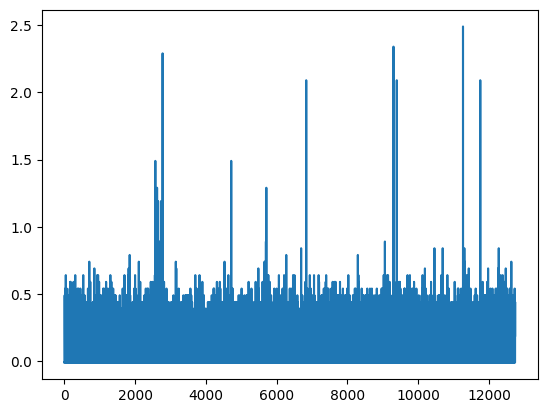

In [22]:
from trainAi import Trainer
trainer = Trainer(gym)
plt.plot(np.arange(len(good_data[:,2])),good_data[:,2])
plt.show()

In [52]:
trainer.trainOnAllData(1,1,True)

GATHERING DATA...
TRAINING MODEL...


2023-08-28 08:26:57.361299: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1592020000 exceeds 10% of free system memory.
2023-08-28 08:27:29.737618: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1592020000 exceeds 10% of free system memory.


KeyboardInterrupt: 

In [24]:
predictions = trainer.gym.agent.model.predict(np.array(all_data[:,0].tolist()))

2023-08-28 08:23:09.983729: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1591580000 exceeds 10% of free system memory.


4974/4974 [==============================] - 29s 6ms/step


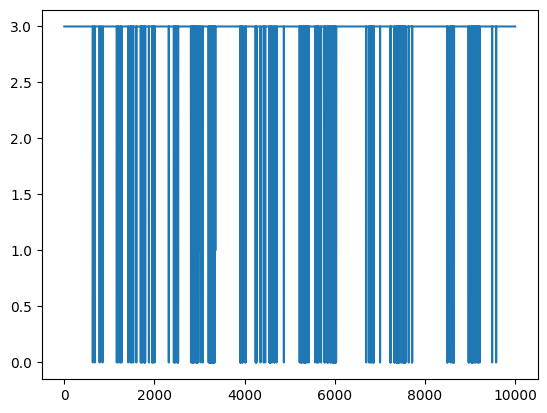

In [26]:
argmax_movements = np.argmax(predictions[0],1)[:10000]
plt.plot(np.arange(len(argmax_movements)),argmax_movements)

In [ ]:
trainer.trainOnData(original=all_data, epochs=4, epochsBeforeUpdating=4, use_target=False)

In [ ]:
temp = trainer.improveQualityOfData(all_data)

In [28]:
gym.manager.saveSession(gym.agent, 9999)

INFO:tensorflow:Assets written to: ./models/model_9999/assets


INFO:tensorflow:Assets written to: ./models/model_9999/assets


In [ ]:
from trainAi import Trainer
trainer = Trainer(gym)
trainer.trainOnAllData(2, 1)

In [ ]:
gym.trainOnPrevData(10000)

[[0.84310526 0.72746205 0.7382133  0.8854821  0.6751983 ]]
[[3.67063   3.7955236]]
AI wants to move down
AI wants to do nothing


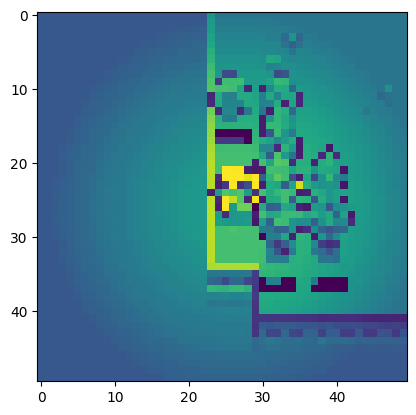

In [50]:
states = gym.manager.loadRandomSample(seed=time.time())
state = states[random.randint(0, len(states)-1)][0]
plt.imshow(state)

prediction = gym.agent.predictRewardsForActions(state)
print(prediction[0])
print(prediction[1])

if np.argmax(prediction[0]) == 0:
    print("AI wants to move right")
elif np.argmax(prediction[0]) == 1:
    print("AI wants to move left")
elif np.argmax(prediction[0]) == 2:
    print("AI wants to move up")
elif np.argmax(prediction[0]) == 3:
    print("AI wants to move down")
else:
    print("AI wants to do nothing")

if np.argmax(prediction[1]) == 0:
    print("AI wants to mine")
elif np.argmax(prediction[1]) == 1:
    print("AI wants to do nothing")